# Bài tập lớn: Phân tích tương tác và nội dung của một tài khoản Tiktok
Môn học: Lập trình xử lý dữ liệu với Python.
Thành viên:
- Chu Thị Phương Anh.
- Phạm Hà Anh.
- Tô Tiến Đạt.

# I. Phân tích tài khoản 'Dòng Máu Việt'

# Phần 1: Xử lý dữ liệu (Data Cleaning)

Tải các thư viện cần để xử lý dữ liệu

In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import hashlib
import ast
import matplotlib as mpl
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import random
from ast import literal_eval
from time import sleep
from datetime import datetime
from ast import literal_eval
import numpy as np
import csv
import os
import re
import hashlib
import httpx
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

Đọc file dữ liệu

In [131]:
read_df = pd.read_csv('Data/data.csv',  encoding='ISO-8859-1')

In [132]:
read_df.info()
# ⇒ Dữ liệu chúng ta thu thập được sẽ có 863 bài post và có 80 cột dữ liệu được kéo về

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863 entries, 0 to 862
Data columns (total 80 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   ï»¿"authorMeta/avatar"                    863 non-null    object 
 1   authorMeta/bioLink                        0 non-null      float64
 2   authorMeta/commerceUserInfo/commerceUser  863 non-null    bool   
 3   authorMeta/digg                           863 non-null    int64  
 4   authorMeta/fans                           863 non-null    int64  
 5   authorMeta/following                      863 non-null    int64  
 6   authorMeta/friends                        863 non-null    int64  
 7   authorMeta/heart                          863 non-null    int64  
 8   authorMeta/id                             863 non-null    int64  
 9   authorMeta/name                           863 non-null    object 
 10  authorMeta/nickName                   

In [133]:
# Tiếp tục với quá trình xử lý dữ liệu, chúng ta sẽ xóa đi những cột có giá trị null hoàn toàn 
read_df = read_df.dropna(axis='columns', how='all')

In [134]:
# ⇒ Với cách này chúng ta đã loại bỏ đi được 2 cột dữ liệu không có giá trị phân tích 
# => Còn lại 78 cột
read_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863 entries, 0 to 862
Data columns (total 78 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   ï»¿"authorMeta/avatar"                    863 non-null    object 
 1   authorMeta/commerceUserInfo/commerceUser  863 non-null    bool   
 2   authorMeta/digg                           863 non-null    int64  
 3   authorMeta/fans                           863 non-null    int64  
 4   authorMeta/following                      863 non-null    int64  
 5   authorMeta/friends                        863 non-null    int64  
 6   authorMeta/heart                          863 non-null    int64  
 7   authorMeta/id                             863 non-null    int64  
 8   authorMeta/name                           863 non-null    object 
 9   authorMeta/nickName                       863 non-null    object 
 10  authorMeta/originalAvatarUrl          

In [135]:
# Tính tỷ lệ giá trị null cho mỗi cột
Null_Percentage = read_df.isnull().mean()

# Lấy các cột có tỷ lệ giá trị null lớn hơn 99%
Null_more_ninety = Null_Percentage[Null_Percentage > 0.99].index

# Xóa các cột có tỷ lệ giá trị null lớn hơn 99%
read_df = read_df.drop(columns=Null_more_ninety)

In [136]:
# ⇒ Với cách này chúng ta đã loại bỏ đi được 12 cột dữ liệu không có giá trị phân tích 
# => Còn 66 cột
read_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863 entries, 0 to 862
Data columns (total 66 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   ï»¿"authorMeta/avatar"                    863 non-null    object 
 1   authorMeta/commerceUserInfo/commerceUser  863 non-null    bool   
 2   authorMeta/digg                           863 non-null    int64  
 3   authorMeta/fans                           863 non-null    int64  
 4   authorMeta/following                      863 non-null    int64  
 5   authorMeta/friends                        863 non-null    int64  
 6   authorMeta/heart                          863 non-null    int64  
 7   authorMeta/id                             863 non-null    int64  
 8   authorMeta/name                           863 non-null    object 
 9   authorMeta/nickName                       863 non-null    object 
 10  authorMeta/originalAvatarUrl          

In [137]:
# Lấy các cột có tỷ lệ giá trị null lớn hơn 50% và bé hơn 99%
Null_Percentage[(Null_Percentage > 0.5) & (Null_Percentage < 0.99)].index

Index(['detailedMentions/0/id', 'detailedMentions/0/nickName',
       'detailedMentions/0/profileUrl', 'detailedMentions/1/id',
       'detailedMentions/1/name', 'detailedMentions/1/nickName',
       'detailedMentions/1/profileUrl', 'hashtags/3/name', 'hashtags/4/name',
       'hashtags/5/name', 'hashtags/6/name', 'hashtags/7/name', 'mentions/0',
       'mentions/1', 'videoMeta/subtitleLinks/0/downloadLink',
       'videoMeta/subtitleLinks/0/language',
       'videoMeta/subtitleLinks/0/tiktokLink'],
      dtype='object')

## **Xóa các cột chứa đường link**

## 1. Cột 'videoMeta/subtitleLinks/0/tiktokLink'

In [140]:
# # Ở đây chúng ta sẽ có một số các cột chứa các đường link, chúng ta sẽ kiểm tra xem các đường link đó có truy cập được không nếu không thì chúng ta sẽ xóa nó đi 
# Hàm kiểm tra link
def check_link(link, expected_hash_value):
    try:
        with httpx.Client(timeout=5) as client:
            response = client.get(link)
        if response.status_code == 200:
            sha256_hash = hashlib.sha256(link.encode()).hexdigest()
            if sha256_hash == expected_hash_value:
                return link
    except (httpx.RequestError, httpx.TimeoutException):
        pass
    return np.nan

# Hàm xử lý song song với tiến trình
def process_links(links, expected_hash_value):
    with ThreadPoolExecutor(max_workers=min(10, len(links))) as executor:
        results = list(tqdm(executor.map(lambda link: check_link(link, expected_hash_value), links), total=len(links)))
    return results

# Lọc các giá trị hợp lệ
expected_hash_value = "098f6bcd4621d373cade4e832627b4f6"
valid_links = read_df['videoMeta/subtitleLinks/0/tiktokLink'].dropna()

# Xử lý các giá trị hợp lệ
processed_links = process_links(valid_links, expected_hash_value)

# Tạo một bản sao cột để lưu kết quả
processed_column = read_df['videoMeta/subtitleLinks/0/tiktokLink'].copy()

# Gán kết quả đã xử lý vào đúng vị trí
processed_column.loc[valid_links.index] = processed_links

# Cập nhật cột trong DataFrame
read_df['videoMeta/subtitleLinks/0/tiktokLink'] = processed_column

# Kiểm tra và loại bỏ cột nếu cần
if not read_df['videoMeta/subtitleLinks/0/tiktokLink'].isna().all():
    read_df.drop(columns=['videoMeta/subtitleLinks/0/tiktokLink'], inplace=True)


100%|██████████| 408/408 [01:31<00:00,  4.48it/s]


In [141]:
#In ra tỉ lệ giá trị Null của cột này:
Null_Percentage['videoMeta/subtitleLinks/0/tiktokLink']

0.5272305909617613

In [142]:
#Tỉ lệ lớn lớn 50% ->Xóa
columns_to_drop = ['videoMeta/subtitleLinks/0/tiktokLink', 'videoMeta/subtitleLinks/0/tiktokLink_valid']
read_df = read_df.drop(columns=[col for col in columns_to_drop if col in read_df.columns])

In [143]:
read_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863 entries, 0 to 862
Data columns (total 65 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   ï»¿"authorMeta/avatar"                    863 non-null    object 
 1   authorMeta/commerceUserInfo/commerceUser  863 non-null    bool   
 2   authorMeta/digg                           863 non-null    int64  
 3   authorMeta/fans                           863 non-null    int64  
 4   authorMeta/following                      863 non-null    int64  
 5   authorMeta/friends                        863 non-null    int64  
 6   authorMeta/heart                          863 non-null    int64  
 7   authorMeta/id                             863 non-null    int64  
 8   authorMeta/name                           863 non-null    object 
 9   authorMeta/nickName                       863 non-null    object 
 10  authorMeta/originalAvatarUrl          

## 2. Cột 'videoMeta/subtitleLinks/0/downloadLink'

In [145]:
print(read_df.columns.tolist())

['ï»¿"authorMeta/avatar"', 'authorMeta/commerceUserInfo/commerceUser', 'authorMeta/digg', 'authorMeta/fans', 'authorMeta/following', 'authorMeta/friends', 'authorMeta/heart', 'authorMeta/id', 'authorMeta/name', 'authorMeta/nickName', 'authorMeta/originalAvatarUrl', 'authorMeta/privateAccount', 'authorMeta/profileUrl', 'authorMeta/region', 'authorMeta/signature', 'authorMeta/ttSeller', 'authorMeta/verified', 'authorMeta/video', 'collectCount', 'commentCount', 'createTime', 'createTimeISO', 'detailedMentions/0/id', 'detailedMentions/0/nickName', 'detailedMentions/0/profileUrl', 'detailedMentions/1/id', 'detailedMentions/1/name', 'detailedMentions/1/nickName', 'detailedMentions/1/profileUrl', 'diggCount', 'hashtags/0/name', 'hashtags/1/name', 'hashtags/2/name', 'hashtags/3/name', 'hashtags/4/name', 'hashtags/5/name', 'hashtags/6/name', 'hashtags/7/name', 'id', 'input', 'isPinned', 'isSlideshow', 'isSponsored', 'mentions/0', 'mentions/1', 'musicMeta/coverMediumUrl', 'musicMeta/musicAuthor'

In [146]:
# Hàm kiểm tra link
def check_link(link, expected_hash_value):
    try:
        with httpx.Client(timeout=5) as client:
            response = client.get(link)
        if response.status_code == 200:
            sha256_hash = hashlib.sha256(link.encode()).hexdigest()
            if sha256_hash == expected_hash_value:
                return link
    except (httpx.RequestError, httpx.TimeoutException):
        pass
    return np.nan

# Hàm xử lý song song với tiến trình
def process_links(links, expected_hash_value):
    with ThreadPoolExecutor(max_workers=min(10, len(links))) as executor:
        results = list(tqdm(executor.map(lambda link: check_link(link, expected_hash_value), links), total=len(links)))
    return results

# Lọc các giá trị hợp lệ
expected_hash_value = "098f6bcd4621d373cade4e832627b4f6"
valid_links = read_df['videoMeta/subtitleLinks/0/downloadLink'].dropna()

# Xử lý các giá trị hợp lệ
processed_links = process_links(valid_links, expected_hash_value)

# Tạo một bản sao cột để lưu kết quả
processed_column = read_df['videoMeta/subtitleLinks/0/downloadLink'].copy()

# Gán kết quả đã xử lý vào đúng vị trí
processed_column.loc[valid_links.index] = processed_links

# Cập nhật cột trong DataFrame
read_df['videoMeta/subtitleLinks/0/downloadLink'] = processed_column

# Kiểm tra và loại bỏ cột nếu cần
if not read_df['videoMeta/subtitleLinks/0/downloadLink'].isna().all():
    read_df.drop(columns=['videoMeta/subtitleLinks/0/downloadLink'], inplace=True)


100%|██████████| 408/408 [01:22<00:00,  4.93it/s]


In [147]:
#Tỉ lệ Null của cột này:
Null_Percentage['videoMeta/subtitleLinks/0/downloadLink']

0.5272305909617613

In [148]:
# ⇒ Kết quả lớn hơn 50% ⇒ Xóa cột này đi 
columns_to_drop = ['videoMeta/subtitleLinks/0/downloadLink', 'videoMeta/subtitleLinks/0/downloadLink_valid']
read_df = read_df.drop(columns=[col for col in columns_to_drop if col in read_df.columns])

In [149]:
read_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863 entries, 0 to 862
Data columns (total 64 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   ï»¿"authorMeta/avatar"                    863 non-null    object 
 1   authorMeta/commerceUserInfo/commerceUser  863 non-null    bool   
 2   authorMeta/digg                           863 non-null    int64  
 3   authorMeta/fans                           863 non-null    int64  
 4   authorMeta/following                      863 non-null    int64  
 5   authorMeta/friends                        863 non-null    int64  
 6   authorMeta/heart                          863 non-null    int64  
 7   authorMeta/id                             863 non-null    int64  
 8   authorMeta/name                           863 non-null    object 
 9   authorMeta/nickName                       863 non-null    object 
 10  authorMeta/originalAvatarUrl          

## 3. Đối với các cột khác chúng ta sẽ kiểm tra dữ liệu của từng cột và đánh giá xem dữ liệu trong cột đó có sử dụng được hay có giá trị hay không

Dựa vào Index(['detailedMentions/0/id', 'detailedMentions/0/nickName',
       'detailedMentions/0/profileUrl', 'detailedMentions/1/id',
       'detailedMentions/1/name', 'detailedMentions/1/nickName',
       'detailedMentions/1/profileUrl', 'hashtags/3/name', 'hashtags/4/name',
       'hashtags/5/name', 'hashtags/6/name', 'hashtags/7/name', 'mentions/0',
       'mentions/1',
       'videoMeta/subtitleLinks/0/language',],
      dtype='object')

In [152]:
read_df['detailedMentions/0/id'].dropna().head(200)

# Dữ liệu ở cột này không có giá trị phân tích => Cột này sẽ bị xóa
read_df = read_df.drop(columns = 'detailedMentions/0/id')

In [153]:
read_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863 entries, 0 to 862
Data columns (total 63 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   ï»¿"authorMeta/avatar"                    863 non-null    object 
 1   authorMeta/commerceUserInfo/commerceUser  863 non-null    bool   
 2   authorMeta/digg                           863 non-null    int64  
 3   authorMeta/fans                           863 non-null    int64  
 4   authorMeta/following                      863 non-null    int64  
 5   authorMeta/friends                        863 non-null    int64  
 6   authorMeta/heart                          863 non-null    int64  
 7   authorMeta/id                             863 non-null    int64  
 8   authorMeta/name                           863 non-null    object 
 9   authorMeta/nickName                       863 non-null    object 
 10  authorMeta/originalAvatarUrl          

**Tương tự với các cột 'detailedMentions/0/nickName',
       'detailedMentions/0/profileUrl', 'detailedMentions/1/id',
       'detailedMentions/1/name', 'detailedMentions/1/nickName',
       'detailedMentions/1/profileUrl', 'hashtags/3/name', 'hashtags/4/name',
       'hashtags/5/name', 'hashtags/6/name', 'hashtags/7/name', 'mentions/0',
       'mentions/1',**

In [155]:
coloumns_drop_many = ['detailedMentions/0/nickName',
       'detailedMentions/0/profileUrl', 
       'detailedMentions/1/id',
       'detailedMentions/1/name', 
       'detailedMentions/1/nickName',
       'detailedMentions/1/profileUrl', 
       'hashtags/3/name', 'hashtags/4/name',
       'hashtags/5/name', 'hashtags/6/name', 
       'hashtags/7/name', 'mentions/0',
       'mentions/1',
       'videoMeta/subtitleLinks/0/language']

read_df = read_df.drop(columns=coloumns_drop_many)

In [156]:
# => Còn 49 cột
read_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863 entries, 0 to 862
Data columns (total 49 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   ï»¿"authorMeta/avatar"                    863 non-null    object
 1   authorMeta/commerceUserInfo/commerceUser  863 non-null    bool  
 2   authorMeta/digg                           863 non-null    int64 
 3   authorMeta/fans                           863 non-null    int64 
 4   authorMeta/following                      863 non-null    int64 
 5   authorMeta/friends                        863 non-null    int64 
 6   authorMeta/heart                          863 non-null    int64 
 7   authorMeta/id                             863 non-null    int64 
 8   authorMeta/name                           863 non-null    object
 9   authorMeta/nickName                       863 non-null    object
 10  authorMeta/originalAvatarUrl              863 non-

In [157]:
read_df["ï»¿\"authorMeta/avatar\""].dropna().head(200)
#Dữ liệu dẫn đến link avatar của chủ sở hữu
# => Xóa
read_df = read_df.drop(columns="ï»¿\"authorMeta/avatar\"")

In [158]:
read_df["authorMeta/commerceUserInfo/commerceUser"].dropna().head(200)
#Dữ liệu chỉ toàn giá trị False
# => Xóa vì không có giá trị phân tích
read_df = read_df.drop(columns="authorMeta/commerceUserInfo/commerceUser")

In [159]:
read_df["authorMeta/digg"].dropna().head(200)
#Dữ liệu chỉ toàn giá trị 0
# => Xóa vì không có giá trị phân tích
read_df = read_df.drop(columns="authorMeta/digg")

In [160]:
#Loại bỏ các cột có dữ liệu bất biến
for col in read_df.columns:
    if read_df[col].nunique() == 1:
        read_df = read_df.drop(columns=col)

read_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863 entries, 0 to 862
Data columns (total 25 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   collectCount                      863 non-null    int64 
 1   commentCount                      863 non-null    int64 
 2   createTime                        863 non-null    int64 
 3   createTimeISO                     863 non-null    object
 4   diggCount                         863 non-null    int64 
 5   hashtags/0/name                   835 non-null    object
 6   hashtags/1/name                   813 non-null    object
 7   hashtags/2/name                   674 non-null    object
 8   id                                863 non-null    int64 
 9   musicMeta/coverMediumUrl          863 non-null    object
 10  musicMeta/musicAuthor             863 non-null    object
 11  musicMeta/musicId                 863 non-null    int64 
 12  musicMeta/musicName   

In [161]:
coloumns_drop_many = ['musicMeta/coverMediumUrl','musicMeta/musicId',
                      'musicMeta/musicName','musicMeta/originalCoverMediumUrl','musicMeta/playUrl']
#Tương tự với các cột có dữ liệu không thể phân tích được của tag musicMeta
read_df = read_df.drop(columns=coloumns_drop_many)

In [162]:
coloumns_drop_many = ['videoMeta/coverUrl','videoMeta/definition',
                      'videoMeta/height','videoMeta/originalCoverUrl','videoMeta/width']
#Tương tự với các cột có dữ liệu không thể phân tích được của tag videoMeta
read_df = read_df.drop(columns=coloumns_drop_many)

In [163]:
read_df["id"].dropna().head(200)
#Dữ liệu là các con số
# => Xóa vì không có giá trị phân tích
read_df = read_df.drop(columns="id")

In [164]:
read_df["webVideoUrl"].dropna().head(200)
#Dữ liệu là các con số
# => Xóa vì không có giá trị phân tích
read_df = read_df.drop(columns="webVideoUrl")

In [165]:
#Vậy chúng ta có được 13 cột dữ liệu phân tích
read_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863 entries, 0 to 862
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   collectCount           863 non-null    int64 
 1   commentCount           863 non-null    int64 
 2   createTime             863 non-null    int64 
 3   createTimeISO          863 non-null    object
 4   diggCount              863 non-null    int64 
 5   hashtags/0/name        835 non-null    object
 6   hashtags/1/name        813 non-null    object
 7   hashtags/2/name        674 non-null    object
 8   musicMeta/musicAuthor  863 non-null    object
 9   playCount              863 non-null    int64 
 10  shareCount             863 non-null    int64 
 11  text                   862 non-null    object
 12  videoMeta/duration     863 non-null    int64 
dtypes: int64(7), object(6)
memory usage: 87.8+ KB


Chuyển dữ liệu thời gian về định dạng chuẩn

In [167]:
from datetime import datetime
from dateutil import parser
import pytz
vietnam_tz = pytz.timezone("Asia/Ho_Chi_Minh")
read_df['createTimeISO'] = read_df['createTimeISO'].astype(str)
read_df['createTimeISO'] = read_df['createTimeISO'].apply(
    lambda x: parser.isoparse(x).astimezone(vietnam_tz)
)
read_df['createTimeISO'] = read_df['createTimeISO'].astype(str)

read_df['createTimeISO'] = read_df['createTimeISO'].apply(
    lambda x: datetime.fromisoformat(x).astimezone(vietnam_tz)
)
read_df['date'] = read_df['createTimeISO'].apply(lambda x: x.date())  # Chỉ lấy ngày
read_df['hour'] = read_df['createTimeISO'].apply(lambda x: x.hour)   # Chỉ lấy giờ
read_df['year'] = read_df['date'].apply(lambda x: x.year)
read_df['month'] = read_df['date'].apply(lambda x: x.month)
read_df['day'] = read_df['date'].apply(lambda x: x.day)
read_df.drop(columns=['createTimeISO', 'date'])


,collectCount,commentCount,createTime,diggCount,hashtags/0/name,hashtags/1/name,hashtags/2/name,musicMeta/musicAuthor,playCount,shareCount,text,videoMeta/duration,hour,year,month,day
0,1392,231,1732165470,26900,dongmauviet,NaN,NaN,DÃ²ng MÃ¡u Viá»t,499600,299,4 Vá» TÆ°á»ng CÃºi Äáº§u TrÆ°á»c 1 Vá» Tr...,108,12,2024,11,21
1,275,45,1731913011,3128,dongmauviet,NaN,NaN,DÃ²ng MÃ¡u Viá»t,33600,203,Lá»ch Sá»­ NgÃ y NhÃ GiÃ¡o Viá»t Nam 20/11....,47,13,2024,11,18
2,184,34,1731554729,3192,dongmauviet,NaN,NaN,DÃ²ng MÃ¡u Viá»t,36300,31,Chiáº¿c MÅ© Huyá»n Thoáº¡i Cá»§a Ãng Cha. ...,87,10,2024,11,14
3,691,226,1731216293,17700,dongmauviet,NaN,NaN,DÃ²ng MÃ¡u Viá»t,305200,176,"Máº¹ Thá»©, HÆ¡n Cáº£ Sá»± VÄ© Äáº¡i ... #...",75,12,2024,11,10
4,1544,708,1730886398,38300,dongmauviet,NaN,NaN,DÃ²ng MÃ¡u Viá»t,1000000,364,PhÃ©p MÃ u Viá»t Nam ... #dongmauviet,88,16,2024,11,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
858,641,2285,1621612142,150200,dongmauviet,lichsuvietnam,vietnam,DÃ²ng MÃ¡u Viá»t,1300000,1064,Má»i ngÆ°á»i vÃ o kÃªnh youtube : dÃ²ng mÃ¡u...,107,22,2021,5,21
859,125,282,1621556153,16200,dongmauviet,lichsuvietnam,vietnam,DÃ²ng MÃ¡u Viá»t,145000,155,Xin má»i ngÆ°á»i 1 bÃ¬nh luáº­n Äá» kÃªnh ...,159,7,2021,5,21
860,407,1195,1621471433,73700,dongmauviet,lichsuvietnam,vietnam,DÃ²ng MÃ¡u Viá»t,434800,293,Xin má»i ngÆ°á»i 1 cháº¥m vÃ o bÃ¬nh luáº­n ...,68,7,2021,5,20
861,248,77,1621385927,14000,dongmauviet,lichsuvietnam,vietnam,DÃ²ng MÃ¡u Viá»t,139000,138,Má»i ngÆ°á»i cho mÃ¬nh xin 1 cháº¥m vÃ o bÃ¬...,58,7,2021,5,19


Tạo cột text_lenght bao gồm số lượng kí tự của text

In [169]:
read_df['text']=read_df['text'].astype(str)
read_df['text_length']=read_df['text'].apply(lambda x: len(list(x.split(" "))))

Chỉnh text về lỗi về đúng định dạng chữ tiếng Việt

In [171]:
read_df['text']= read_df['text'].apply(lambda x: x.encode('latin1').decode('utf-8'))
read_df['text'].dropna().head(200)

0      4 Vị Tướng Cúi Đầu Trước 1 Vị Trung Tá.   #don...
1      Lịch Sử Ngày Nhà Giáo Việt Nam 20/11.  #dongma...
2      Chiếc Mũ Huyền Thoại Của Ông Cha.   #dongmauviet 
3          Mẹ Thứ, Hơn Cả Sự Vĩ Đại ...    #dongmauviet 
4                  Phép Màu Việt Nam ...   #dongmauviet 
                             ...                        
195          #dongmauviet #dcgr #vietnam #lichsuvietnam 
196          #dongmauviet #dcgr #vietnam #lichsuvietnam 
197                         #dongmauviet #dcgr #vietnam 
198          #dongmauviet #dcgr #vietnam #lichsuvietnam 
199                         #dongmauviet #dcgr #vietnam 
Name: text, Length: 200, dtype: object

# Phần 2. Khám phá dữ liệu (Data Exploration)

## 1. Về xu hướng đăng bài của tài khoản

### 1.1 Tần suất đăng bài

In [175]:
read_df['date'] = pd.to_datetime(read_df[['year', 'month', 'day']])
read_df['day_of_week'] = read_df['date'].dt.day_name()
day_counts = read_df['day_of_week'].value_counts()
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts = day_counts.reindex(days_of_week, fill_value=0)
print(day_counts)

day_of_week
Monday       134
Tuesday      117
Wednesday    136
Thursday     124
Friday       126
Saturday     121
Sunday       105
Name: count, dtype: int64


Trung bình: 123.28571428571429
Độ lệch chuẩn tổng thể: 9.735271449943324


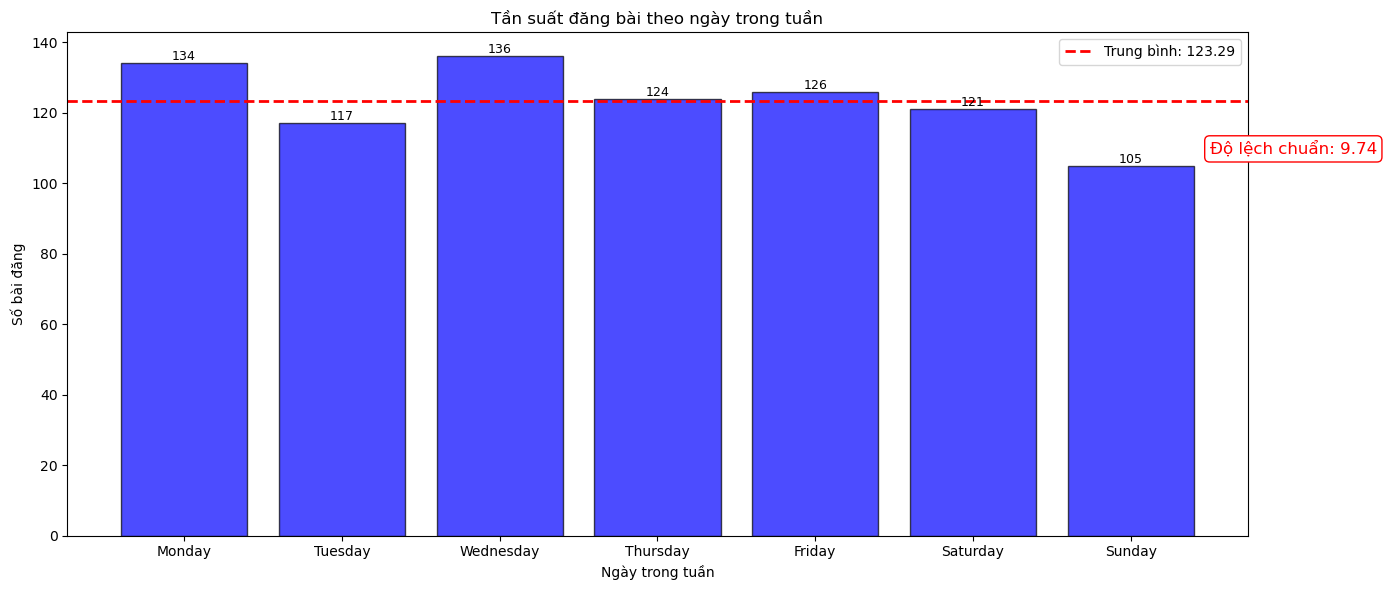

In [176]:
mean = day_counts.mean()
print("Trung bình:", mean)
population_std = np.std(day_counts)
print("Độ lệch chuẩn tổng thể:", population_std)

fig, day_plot = plt.subplots(figsize=(14, 6))
day_plot.bar(days_of_week, day_counts, color='blue', alpha=0.7, edgecolor='black')
day_plot.axhline(mean, color='red', linestyle='--', linewidth=2, label=f"Trung bình: {mean:.2f}")

day_plot.set_xlabel('Ngày trong tuần')
day_plot.set_ylabel('Số bài đăng')
day_plot.set_title('Tần suất đăng bài theo ngày trong tuần')

for i, count in enumerate(day_counts):
    day_plot.text(i, count, int(count), ha='center', va='bottom', fontsize=9, color='black')

plt.text(
    6.5, mean - 15, f"Độ lệch chuẩn: {population_std:.2f}", color='red', fontsize=12, 
    bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.3')
)

day_plot.legend()
plt.tight_layout()
plt.show()

**Biểu đồ tròn**

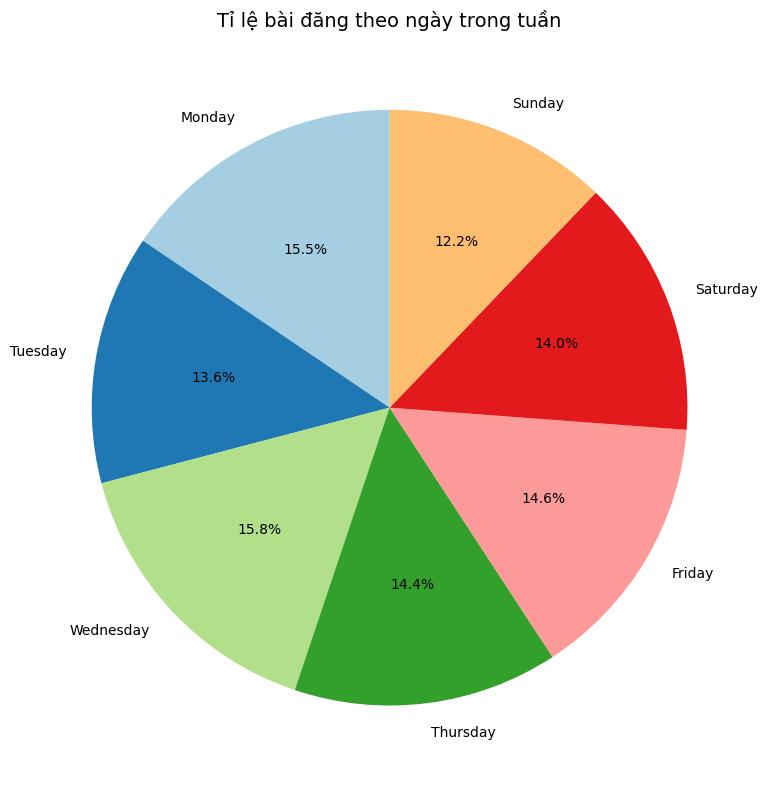

In [178]:
fig, ax = plt.subplots(figsize=(8, 8))
colors = plt.cm.Paired(range(len(days_of_week)))

ax.pie(
    day_counts, 
    labels=days_of_week, 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=colors, 
    textprops={'fontsize': 10}
)

ax.set_title('Tỉ lệ bài đăng theo ngày trong tuần', fontsize=14)

plt.tight_layout()
plt.show()

- Giá trị trung bình là 123.29 bài
- Độ lệch chuẩn là 9.74 cho thấy dữ liệu không quá biến động, nghĩa là tần suất đăng bài giữa các ngày khá ổn định
- Ngày có số lượng đăng bài cao nhất: Wednesday với 136 bài
- Ngày có số lượng đăng bài thấp nhất: Sunday với 105 bài
- Các ngày giữa tuần (Monday đến Friday) thường có số lượng bài đăng cao hơn so với cuối tuần (Saturday và Sunday)

In [180]:
read_df['date'] = pd.to_datetime(read_df[['year', 'month', 'day']])
read_df['day_of_month'] = read_df['date'].dt.day
day_counts = read_df['day_of_month'].value_counts().sort_index()

mean = day_counts.mean()
population_std = np.std(day_counts)
print('Giá trị trung bình là: ' + str(mean))
print('Độ lệch chuẩn là: ' + str(population_std))

Giá trị trung bình là: 27.838709677419356
Độ lệch chuẩn là: 4.711665510565743


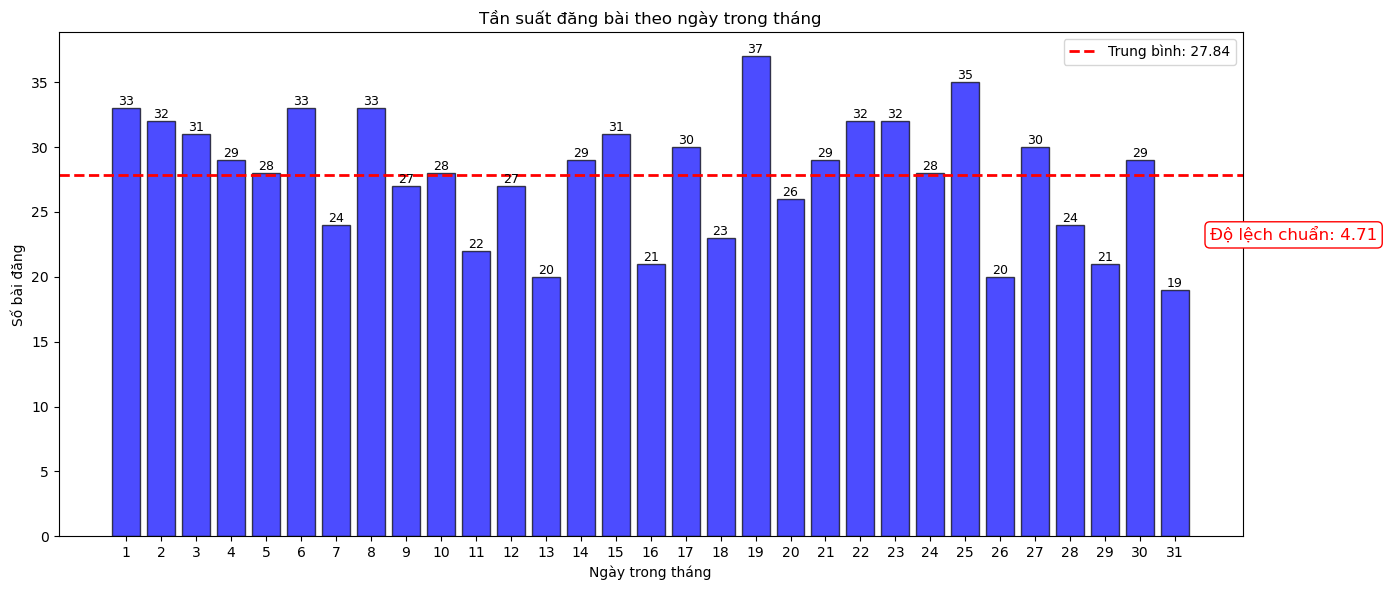

In [181]:
fig, day_plot = plt.subplots(figsize=(14, 6))
day_plot.bar(day_counts.index, day_counts, color='blue', alpha=0.7, edgecolor='black')

day_plot.axhline(mean, color='red', linestyle='--', linewidth=2, label=f"Trung bình: {mean:.2f}")
day_plot.set_xlabel('Ngày trong tháng')
day_plot.set_ylabel('Số bài đăng')
day_plot.set_title('Tần suất đăng bài theo ngày trong tháng')
day_plot.set_xticks(day_counts.index)  

for i, count in enumerate(day_counts):
    day_plot.text(i + 1, count, int(count), ha='center', va='bottom', fontsize=9, color='black')

plt.text(
    max(day_counts.index) + 1, mean - 5, f"Độ lệch chuẩn: {population_std:.2f}", color='red', fontsize=12, 
    bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.3')
)
day_plot.legend()
plt.tight_layout()
plt.show()

In [182]:
read_df['date'] = pd.to_datetime(read_df[['year', 'month', 'day']])
daily_counts = read_df.groupby('date').size().reset_index(name='post_count')

mean_posts = daily_counts['post_count'].mean()  
std_posts = daily_counts['post_count'].std()   
median_posts = daily_counts['post_count'].median() 
max_posts = daily_counts['post_count'].max()  
min_posts = daily_counts['post_count'].min()  

# In ra các giá trị tính toán
print(f"Trung bình số bài đăng theo ngày: {mean_posts:.2f}")
print(f"Độ lệch chuẩn của số bài đăng theo ngày: {std_posts:.2f}")
print(f"Trung vị số bài đăng theo ngày: {median_posts:.2f}")
print(f"Số bài đăng ngày cao nhất: {max_posts}")
print(f"Số bài đăng ngày thấp nhất: {min_posts}")

Trung bình số bài đăng theo ngày: 1.27
Độ lệch chuẩn của số bài đăng theo ngày: 0.49
Trung vị số bài đăng theo ngày: 1.00
Số bài đăng ngày cao nhất: 3
Số bài đăng ngày thấp nhất: 1


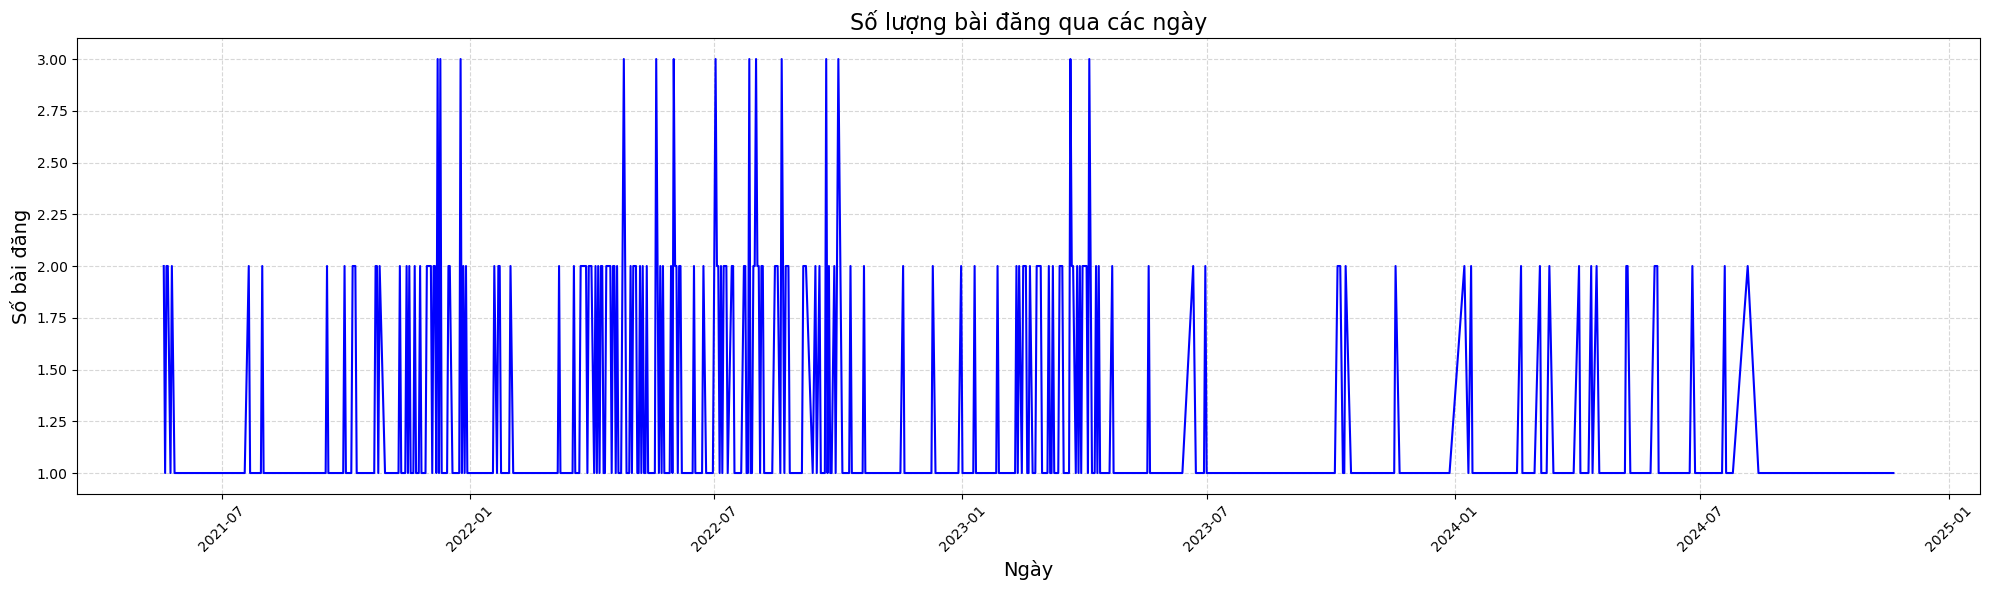

In [183]:
plt.figure(figsize=(20, 6))
sns.lineplot(data=daily_counts, x='date', y='post_count', color='blue')

plt.title('Số lượng bài đăng qua các ngày', fontsize=16)
plt.xlabel('Ngày', fontsize=14)
plt.ylabel('Số bài đăng', fontsize=14)
plt.xticks(rotation=45)  
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

- Tần suất đăng bài khá ổn định với nhiều ngày có mức bài đăng tối thiểu (1 bài/ngày).
- Có một số thời điểm tài khoản này hoạt động tích cực hơn, với số bài đăng dao động từ 2-3 bài/ngày.

In [185]:
import matplotlib.dates as mdates
read_df['Date'] = pd.to_datetime(read_df[['year', 'month', 'day']])

weekly_posts = read_df.resample('W', on='Date').size()
mean_posts = weekly_posts.mean() 
std_posts = weekly_posts.std()   
median_posts = weekly_posts.median()  
max_posts = weekly_posts.max()  
min_posts = weekly_posts.min() 

print(f"Trung bình số bài đăng theo tuần: {mean_posts:.2f}")
print(f"Độ lệch chuẩn của số bài đăng theo tuần: {std_posts:.2f}")
print(f"Trung vị số bài đăng theo tuần: {median_posts:.2f}")
print(f"Số bài đăng tuần cao nhất: {max_posts}")
print(f"Số bài đăng tuần thấp nhất: {min_posts}")

Trung bình số bài đăng theo tuần: 4.69
Độ lệch chuẩn của số bài đăng theo tuần: 3.25
Trung vị số bài đăng theo tuần: 4.00
Số bài đăng tuần cao nhất: 13
Số bài đăng tuần thấp nhất: 0


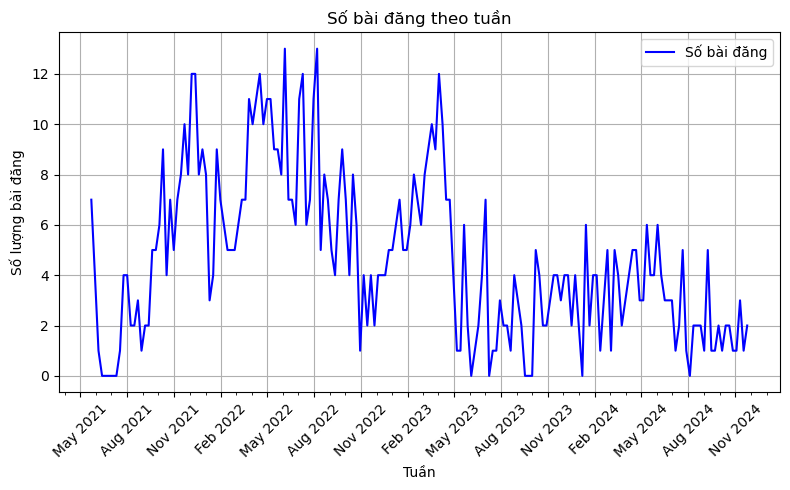

In [186]:
plt.figure(figsize=(8, 5))
plt.plot(weekly_posts.index, weekly_posts.values, label='Số bài đăng', color='blue')
plt.title('Số bài đăng theo tuần')
plt.xlabel('Tuần')
plt.ylabel('Số lượng bài đăng')
plt.grid(True)
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  
plt.xticks(rotation=45) 

plt.tight_layout()
plt.show()

- Trung bình số bài đăng theo tuần: 4.69
- Xu hướng tổng thể cho thấy số lượng bài đăng theo tuần có xu hướng cao điểm vào năm 2022 và năm 2023.
- Sau giai đoạn này, tần suất đăng bài có xu hướng giảm dần.

In [188]:
read_df['Date'] = pd.to_datetime(read_df[['year', 'month', 'day']])
monthly_posts = read_df.resample('ME', on='Date').size()
mean_posts = monthly_posts.mean()  
std_posts = monthly_posts.std()   
median_posts = monthly_posts.median() 
max_posts = monthly_posts.max()  
min_posts = monthly_posts.min()  

print(f"Trung bình số bài đăng theo tháng: {mean_posts:.2f}")
print(f"Độ lệch chuẩn của số bài đăng theo tháng: {std_posts:.2f}")
print(f"Trung vị số bài đăng theo tháng: {median_posts:.2f}")
print(f"Số bài đăng tháng cao nhất: {max_posts}")
print(f"Số bài đăng tháng thấp nhất: {min_posts}")

Trung bình số bài đăng theo tháng: 20.07
Độ lệch chuẩn của số bài đăng theo tháng: 12.53
Trung vị số bài đăng theo tháng: 16.00
Số bài đăng tháng cao nhất: 46
Số bài đăng tháng thấp nhất: 0


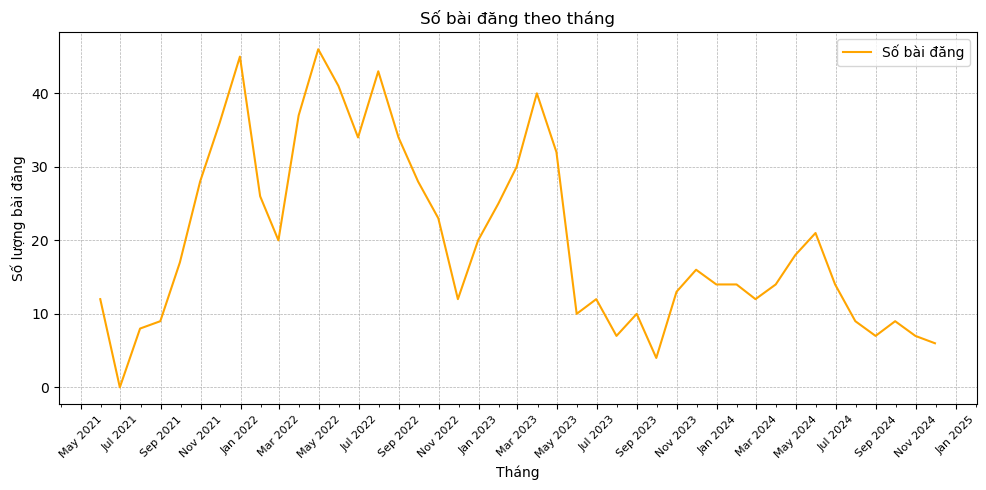

In [189]:
plt.figure(figsize=(10, 5))  
plt.plot(monthly_posts.index, monthly_posts.values, label='Số bài đăng', color='orange')
plt.title('Số bài đăng theo tháng')
plt.xlabel('Tháng')
plt.ylabel('Số lượng bài đăng')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2)) 
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator()) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y')) 
plt.xticks(rotation=45, fontsize=8) 

plt.tight_layout()
plt.show()

- Giai đoạn từ cuối năm 2021 đến đầu năm 2023 là thời điểm hoạt động mạnh nhất, với số lượng bài đăng cao, đạt đỉnh trên 40 bài/tháng.
- Sau đỉnh cao này, hoạt động giảm mạnh từ giữa năm 2023, duy trì ở mức thấp hơn 13 bài/tháng.

In [191]:
read_df['Date'] = pd.to_datetime(read_df[['year', 'month', 'day']])

yearly_posts = read_df.resample('YE', on='Date').size()
mean_posts = yearly_posts.mean() 
std_posts = yearly_posts.std()   
median_posts = yearly_posts.median()  
max_posts = yearly_posts.max()  
min_posts = yearly_posts.min()

print("Số bài đăng từng năm:")
print(yearly_posts)
print(f"Trung bình số bài đăng theo năm: {mean_posts:.2f}")
print(f"Độ lệch chuẩn của số bài đăng theo năm: {std_posts:.2f}")
print(f"Trung vị số bài đăng theo năm: {median_posts:.2f}")
print(f"Số bài đăng năm cao nhất: {max_posts}")
print(f"Số bài đăng năm thấp nhất: {min_posts}")

Số bài đăng từng năm:
Date
2021-12-31    155
2022-12-31    364
2023-12-31    213
2024-12-31    131
Freq: YE-DEC, dtype: int64
Trung bình số bài đăng theo năm: 215.75
Độ lệch chuẩn của số bài đăng theo năm: 104.66
Trung vị số bài đăng theo năm: 184.00
Số bài đăng năm cao nhất: 364
Số bài đăng năm thấp nhất: 131


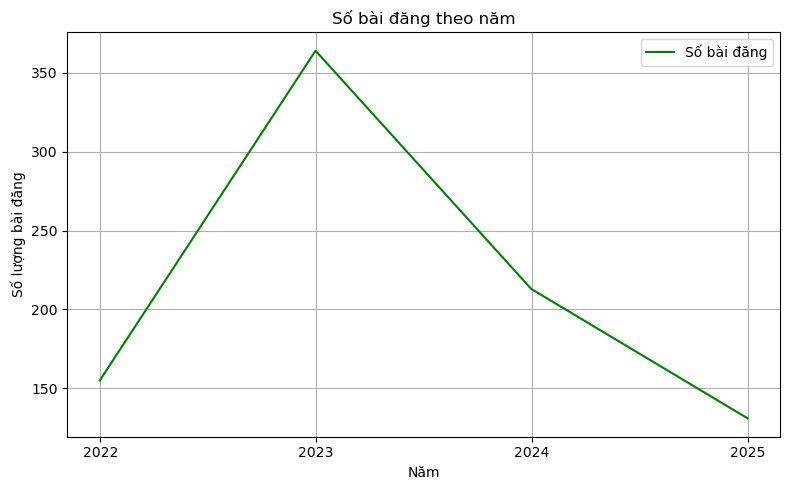

In [192]:
plt.figure(figsize=(8, 5))
plt.plot(yearly_posts.index, yearly_posts.values, label='Số bài đăng', color='green')
plt.title('Số bài đăng theo năm')
plt.xlabel('Năm')
plt.ylabel('Số lượng bài đăng')
plt.grid(True)
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.show()


- Dựa vào đồ thị, chúng ta có thể thấy được:
    + Số lượng bài đăng có xu hướng tăng lên từ năm 2022 đến năm 2023, đạt đỉnh ở khoảng 350 bài.
    + Sau năm 2023, số lượng bài đăng bắt đầu giảm dần.

### 1.2 Khung giờ đăng bài trong ngày 

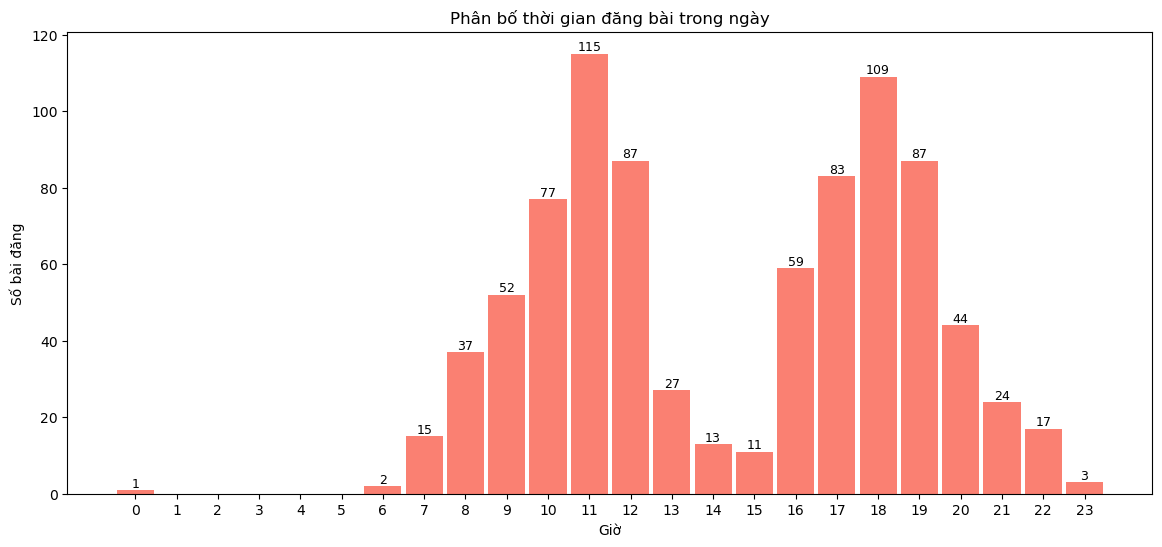

In [195]:
fig, time = plt.subplots(figsize=(14, 6))
time.hist(read_df['hour'], bins=np.arange(0, 25, 1), color='salmon', rwidth=0.9,align='left')
time.set_xticks(range(0, 24))
time.set_xlabel('Giờ')
time.set_ylabel('Số bài đăng')
time.set_title('Phân bố thời gian đăng bài trong ngày')
for patch in time.patches:
    height = patch.get_height()
    if height > 0:
        time.text(patch.get_x() + patch.get_width() / 2,
                  height,
                  int(height),
                  ha='center', va='bottom', fontsize=9, color='black')
plt.show()


Từ dữ biểu đồ trên, ta dễ dàng có thể thấy 2 khung giờ đăng bài phổ biến nhất là từ 10 - 12h và từ 17 - 19h. Đây là các thời gian nghỉ trưa, nghỉ buổi chiều của đa số mọi người, khung giờ dễ lấy được tương tác là thời gian mọi người rảnh để có thể vào xem.

### 1.3 Thời lượng video 

In [198]:
# Trung bình độ dài video:
Median = read_df["videoMeta/duration"].median()
Mean = read_df["videoMeta/duration"].mean()
print("Trung bình thời lượng video là: " + str(float(Median)))
print("Trung vị độ dài video là: "+ str(float(Mean)))

Trung bình thời lượng video là: 79.0
Trung vị độ dài video là: 112.70683661645423


In [199]:
#Độ dài tối thiểu, tối đa:
Max_video = read_df['videoMeta/duration'].max()
Min_video = read_df['videoMeta/duration'].min()

Standard_deviation = read_df['videoMeta/duration'].std()
print("Độ dài video tối thiểu là: " + str(float(Min_video)))
print("Độ dài video tối đa là: " + str(float(Max_video)))
print("Độ lệch chuẩn: " + str(float(Standard_deviation)))

Độ dài video tối thiểu là: 7.0
Độ dài video tối đa là: 597.0
Độ lệch chuẩn: 96.07552634751077


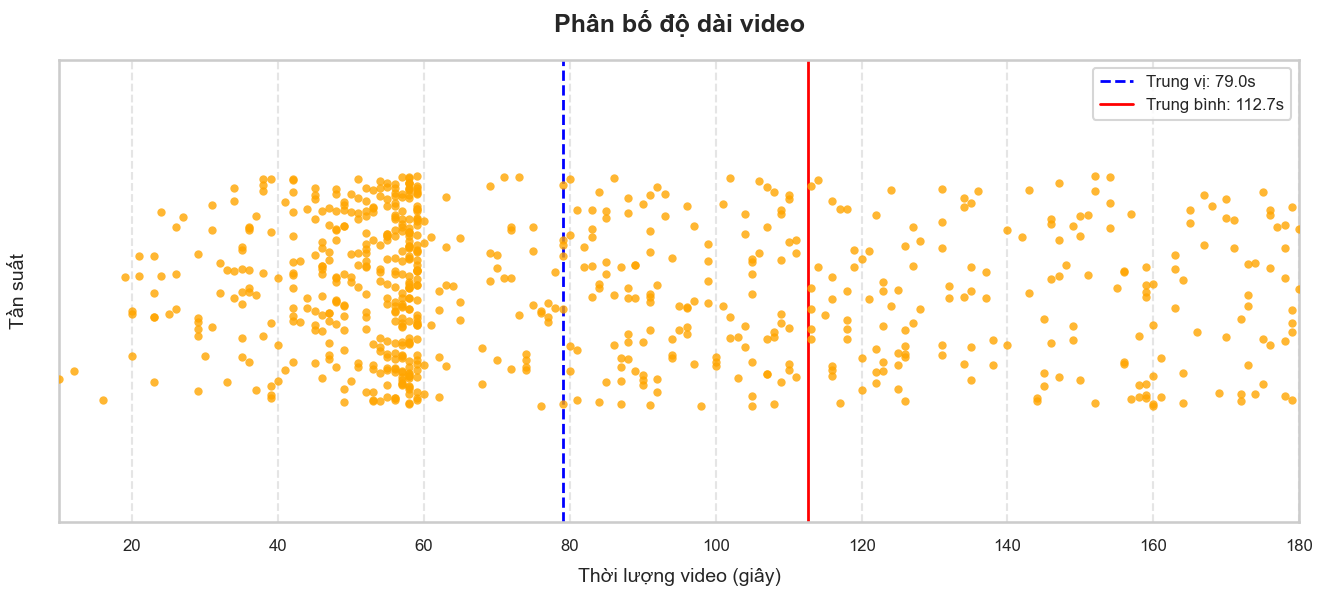

In [200]:
plt.figure(figsize=(16, 6))  
sns.set_theme(style="whitegrid", context="talk")

sns.stripplot(
    data=read_df, 
    x="videoMeta/duration", 
    color="orange", 
    jitter=0.25,         
    size=6,              
    alpha=0.8            
)


plt.axvline(Median, color='blue', linestyle='--', label=f'Trung vị: {Median:.1f}s', linewidth=2)
plt.axvline(Mean, color='red', linestyle='-', label=f'Trung bình: {Mean:.1f}s', linewidth=2)

plt.title("Phân bố độ dài video", fontsize=18, fontweight='bold', pad=20)
plt.xlabel("Thời lượng video (giây)", fontsize=14, labelpad=10)
plt.ylabel("Tần suất", fontsize=14, labelpad=10)

plt.xticks(fontsize=12, rotation=0)  
plt.yticks(fontsize=12)
plt.xlim(10, 180)  

# Chú thích
plt.legend(fontsize=12, loc='upper right')

# Thêm lưới nhẹ
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()


Ta có thể thấy rằng thời lượng video được phân bố khá đều từ khoảng 10 giây đến 180 giây. Trong đó với trung vị khoảng 79.0s và giá trị tủng bình khoảng 112.7s 
=> Đây là đặc trưng thời lượng video của ứng dụng giải trí nhanh giúp người xem dễ dàng tiếp thu kiến thức qua các video ngắn, dễ hiểu, dễ nhớ

Thêm vào đó, dựa vào biểu đồ, xu hướng up video của kênh thường tập trung nhiều vào các video dài 40s-60s, đây là khoảng thời gian lý tưởng để tối ưu hóa nội dung cho người xem khi xem một video về lịch sử



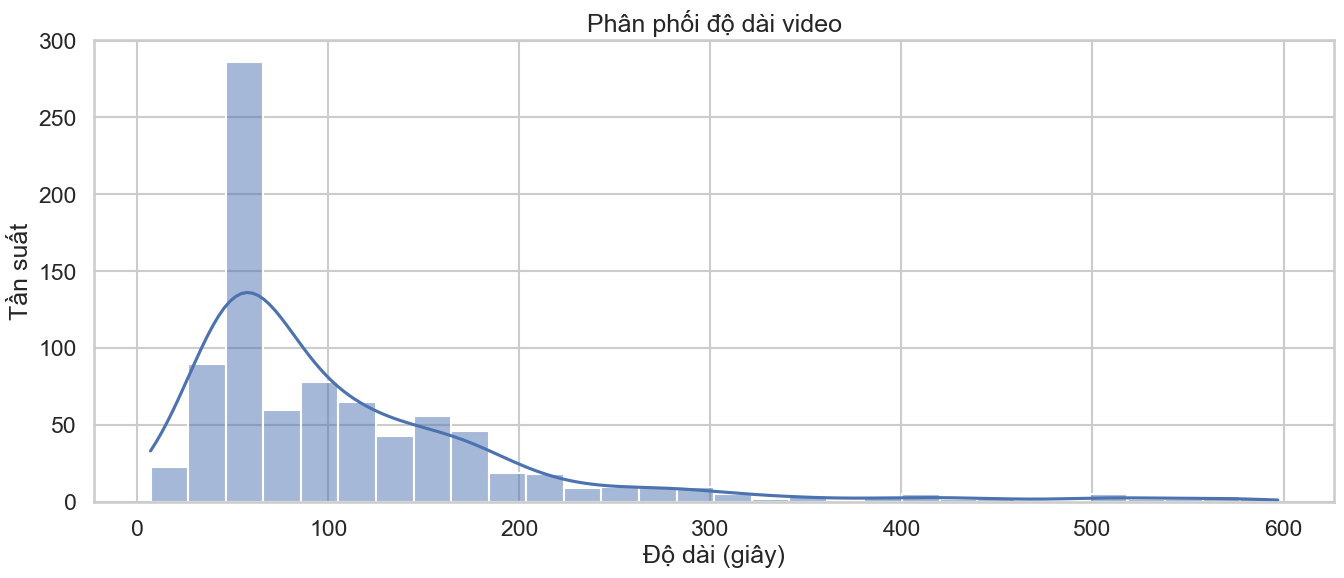

In [202]:
plt.figure(figsize=(16, 6))  
sns.set_theme(style="whitegrid", context="talk")
# Biểu đồ phân phối
sns.histplot(read_df["videoMeta/duration"], bins=30, kde=True)
plt.title('Phân phối độ dài video')
plt.xlabel('Độ dài (giây)')
plt.ylabel('Tần suất')
plt.show()

Dựa vào biểu đồ ta có thể thấy rằng: Khi độ dài video tăng (lớn hơn 100 giây), tần suất giảm dần, cho thấy ít video có thời lượng dài hơn. Bên cạnh đó, phân phối có xu hướng lệch phải, đặc trưng bởi số lượng lớn các video ngắn và giảm dần khi độ dài tăng lên.

**Tổng quan thời lượng video qua các ngày**

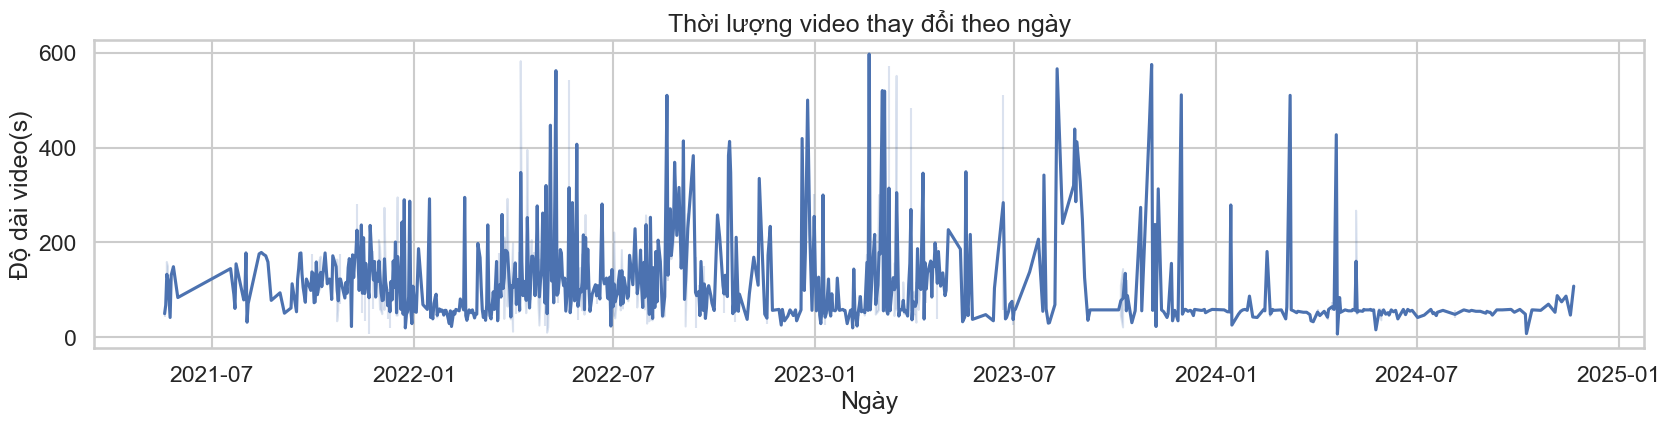

In [205]:
plt.figure(figsize=(20,4))
sns.lineplot(data = read_df, x = read_df['date'], y= read_df['videoMeta/duration'])
plt.title('Thời lượng video thay đổi theo ngày')
plt.xlabel('Ngày')
plt.ylabel('Độ dài video(s)')
plt.show()

Từ năm 2022-2023, thời lượng của video khá lớn và giữ vững giá trị tủng bình, tuy nhiên đến năm 2024, tần suất dài của video giảm mạnh dù vẫn đạt các cột mốc lượng trung bình của video tăng mạnh

**Phân tích độ dài video theo thời gian**

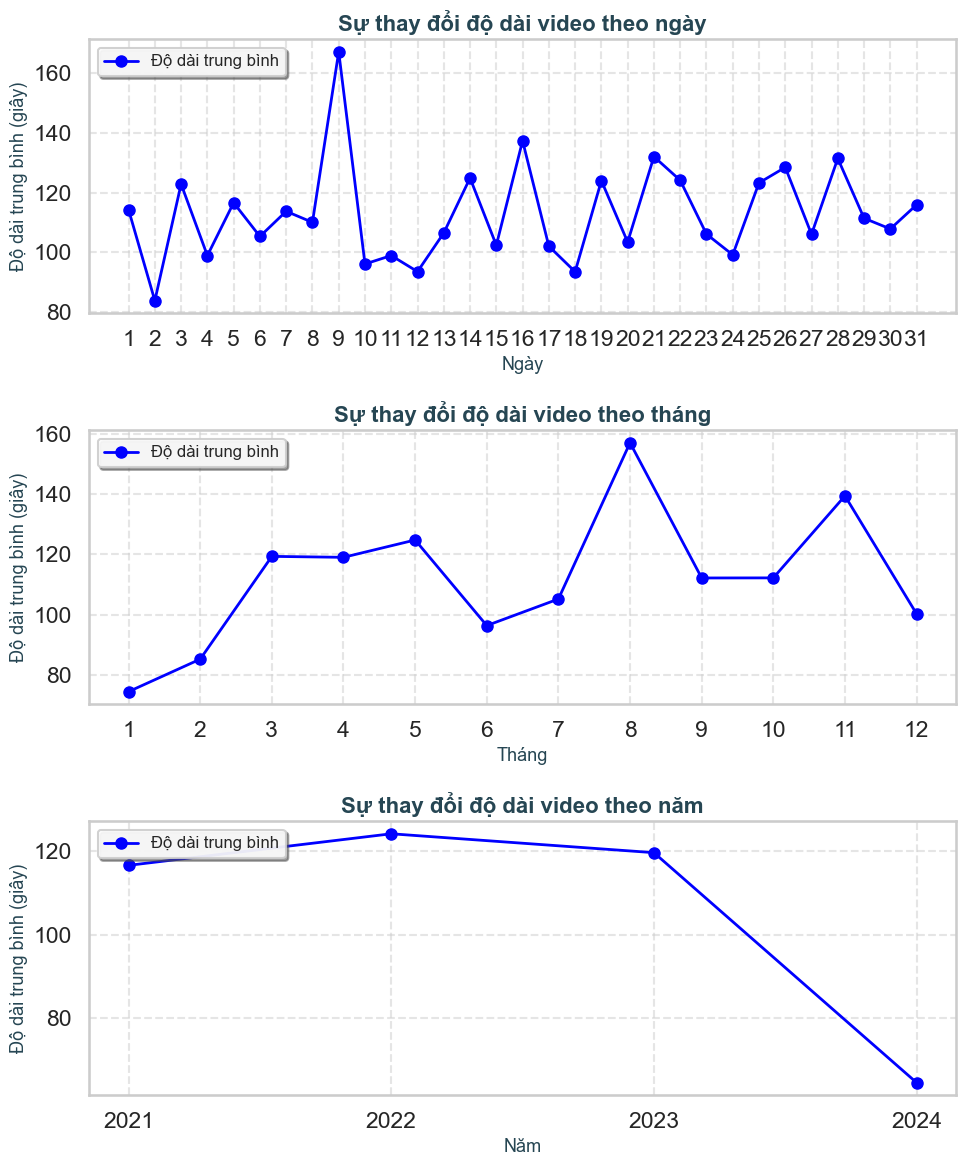

In [208]:
avgl_day = read_df.groupby('day')['videoMeta/duration'].mean().reset_index(name='avgl_day')
avgl_month = read_df.groupby('month')['videoMeta/duration'].mean().reset_index(name='avgl_month')
avgl_year = read_df.groupby('year')['videoMeta/duration'].mean().reset_index(name='avgl_year')

# Thiết lập kiểu và palette
sns.set_style('whitegrid')

# Tạo figure và các axes
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=False)

# Vẽ biểu đồ cho ngày
axes[0].plot(
    avgl_day['day'].astype(str),
    avgl_day['avgl_day'],
    marker='o',
    linestyle='-',
    linewidth=2,
    markersize=8,
    color='blue',
    label='Độ dài trung bình'
)
axes[0].set_title('Sự thay đổi độ dài video theo ngày', fontsize=16, fontweight='bold', color='#264653')
axes[0].set_xlabel('Ngày', fontsize=13, color='#264653')
axes[0].set_ylabel('Độ dài trung bình (giây)', fontsize=13, color='#264653')
axes[0].legend(fontsize=12, loc='upper left', frameon=True, framealpha=0.9, shadow=True)
axes[0].grid(True, linestyle='--', alpha=0.5)

axes[1].plot(
    avgl_month['month'].astype(str),
    avgl_month['avgl_month'],
    marker='o',
    linestyle='-',
    linewidth=2,
    markersize=8,
    color='blue',
    label='Độ dài trung bình'
)
axes[1].set_title('Sự thay đổi độ dài video theo tháng', fontsize=16, fontweight='bold', color='#264653')
axes[1].set_xlabel('Tháng', fontsize=13, color='#264653')
axes[1].set_ylabel('Độ dài trung bình (giây)', fontsize=13, color='#264653')
axes[1].legend(fontsize=12, loc='upper left', frameon=True, framealpha=0.9, shadow=True)
axes[1].grid(True, linestyle='--', alpha=0.5)

axes[2].plot(
    avgl_year['year'].astype(str),
    avgl_year['avgl_year'],
    marker='o',
    linestyle='-',
    linewidth=2,
    markersize=8,
    color='blue',
    label='Độ dài trung bình'
)
axes[2].set_title('Sự thay đổi độ dài video theo năm', fontsize=16, fontweight='bold', color='#264653')
axes[2].set_xlabel('Năm', fontsize=13, color='#264653')
axes[2].set_ylabel('Độ dài trung bình (giây)', fontsize=13, color='#264653')
axes[2].legend(fontsize=12, loc='upper left', frameon=True, framealpha=0.9, shadow=True)
axes[2].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


Dựa vào biểu đồ, độ dài trung bình của video có xu hướng giảm xuống, giảm mạnh nhất theo từng năm

**Dạng Barplot**

In [211]:
video_duration_by_week = pd.DataFrame()
video_duration_by_week['Week'] = pd.to_datetime(read_df['createTimeISO']).dt.strftime('%Y-%W')
video_duration_by_week = video_duration_by_week.sort_values('Week')
video_duration_by_week = video_duration_by_week.groupby('Week').size().reset_index(name='Video Duration')

video_duration_by_month = pd.DataFrame()
video_duration_by_month['Month'] = pd.to_datetime(read_df['createTimeISO']).dt.strftime('%Y-%m')
video_duration_by_month = video_duration_by_month.sort_values('Month')
video_duration_by_month = video_duration_by_month.groupby('Month').size().reset_index(name='Video Duration')

video_duration_by_year = pd.DataFrame()
video_duration_by_year['Year'] = pd.to_datetime(read_df['createTimeISO']).dt.strftime('%Y')
video_duration_by_year = video_duration_by_year.sort_values('Year')
video_duration_by_year = video_duration_by_year.groupby('Year').size().reset_index(name='Video Duration')



Text(0.5, 1.0, 'Video Duration by Year')

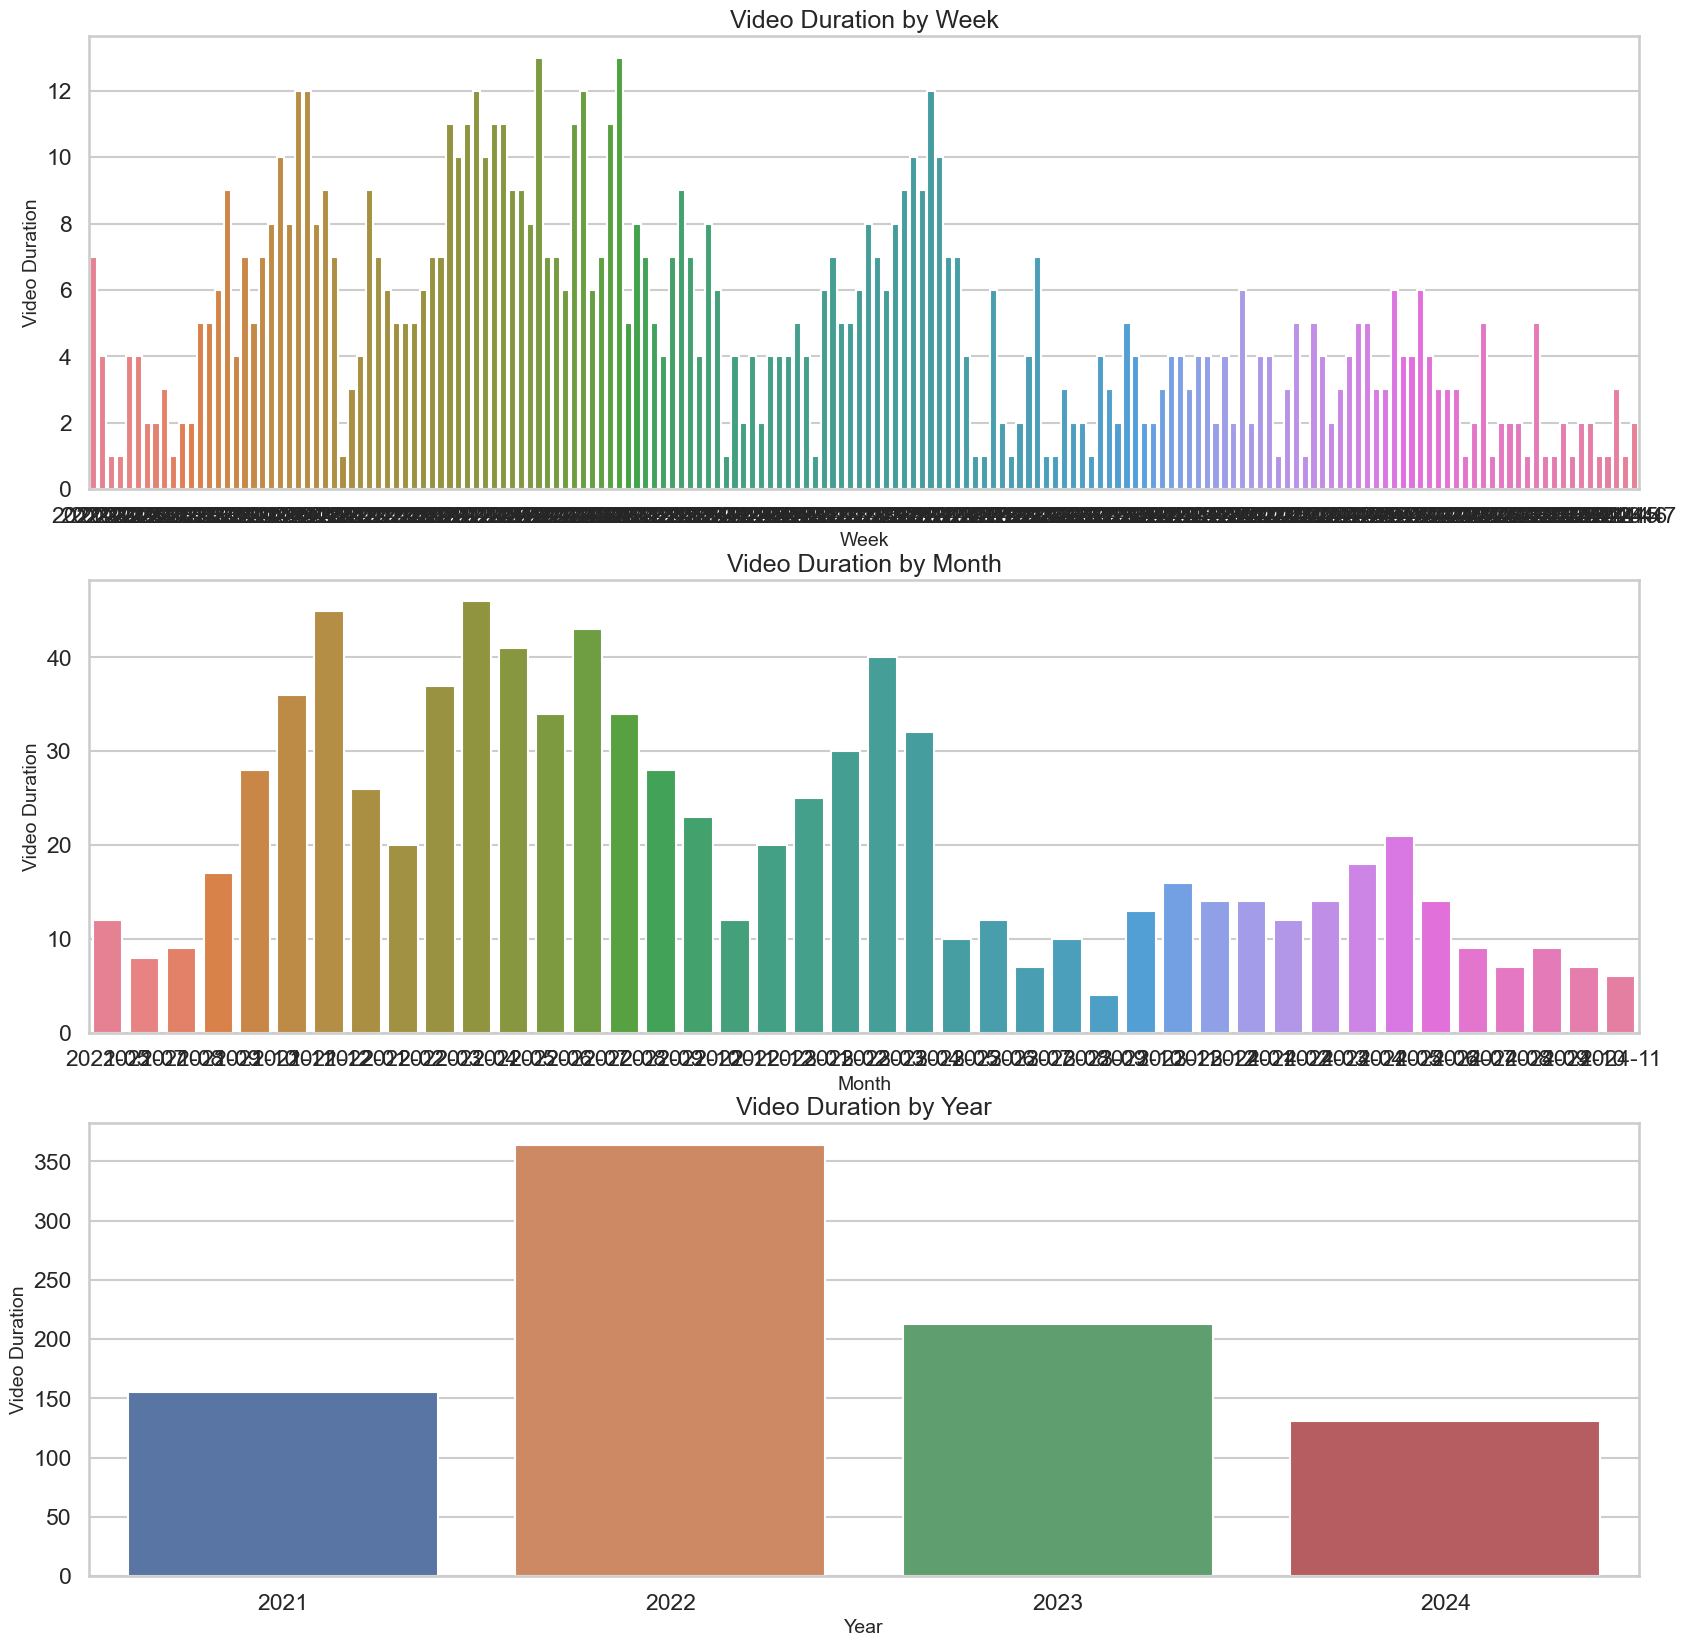

In [212]:
fig, axes = plt.subplots(3,1,figsize = (20,20))
sns.barplot(data= video_duration_by_week, x = 'Week', y='Video Duration', ax=axes[0], hue = 'Week')
axes[0].set_xlabel('Week', fontsize = 14)
axes[0].set_ylabel('Video Duration', fontsize = 14)
axes[0].set_title('Video Duration by Week', fontsize =18)

sns.barplot(data= video_duration_by_month, x = 'Month', y='Video Duration', ax=axes[1], hue = 'Month')
axes[1].set_xlabel('Month', fontsize = 14)
axes[1].set_ylabel('Video Duration', fontsize = 14)
axes[1].set_title('Video Duration by Month', fontsize =18)

sns.barplot(data= video_duration_by_year, x ='Year', y='Video Duration', ax=axes[2], hue = 'Year')
axes[2].set_xlabel('Year', fontsize = 14)
axes[2].set_ylabel('Video Duration', fontsize = 14)
axes[2].set_title('Video Duration by Year', fontsize =18)


Ta có thể thấy rằng thời lượng video có xu hướng tăng mạnh vào năm 2022 và giảm dần về sau nhưng vẫn duy trì khá ổn định

In [214]:
video_duration_contrb_by_year = pd.DataFrame()
video_duration_contrb_by_year['Month'] = pd.to_datetime(read_df['createTimeISO']).dt.strftime('%Y-%M')
video_duration_contrb_by_year['Year'] = read_df['year']
video_duration_contrb_by_year['Date'] = read_df['date']
video_duration_contrb_by_year['Video Duration'] = read_df['videoMeta/duration']

In [215]:
video_duration_contrb_by_year

,Month,Year,Date,Video Duration
0,2024-04,2024,2024-11-21,108
1,2024-56,2024,2024-11-18,47
2,2024-25,2024,2024-11-14,87
3,2024-24,2024,2024-11-10,75
4,2024-46,2024,2024-11-06,88
...,...,...,...,...
858,2021-49,2021,2021-05-21,107
859,2021-15,2021,2021-05-21,159
860,2021-43,2021,2021-05-20,68
861,2021-58,2021,2021-05-19,58


Text(0, 0.5, 'Video Duration')

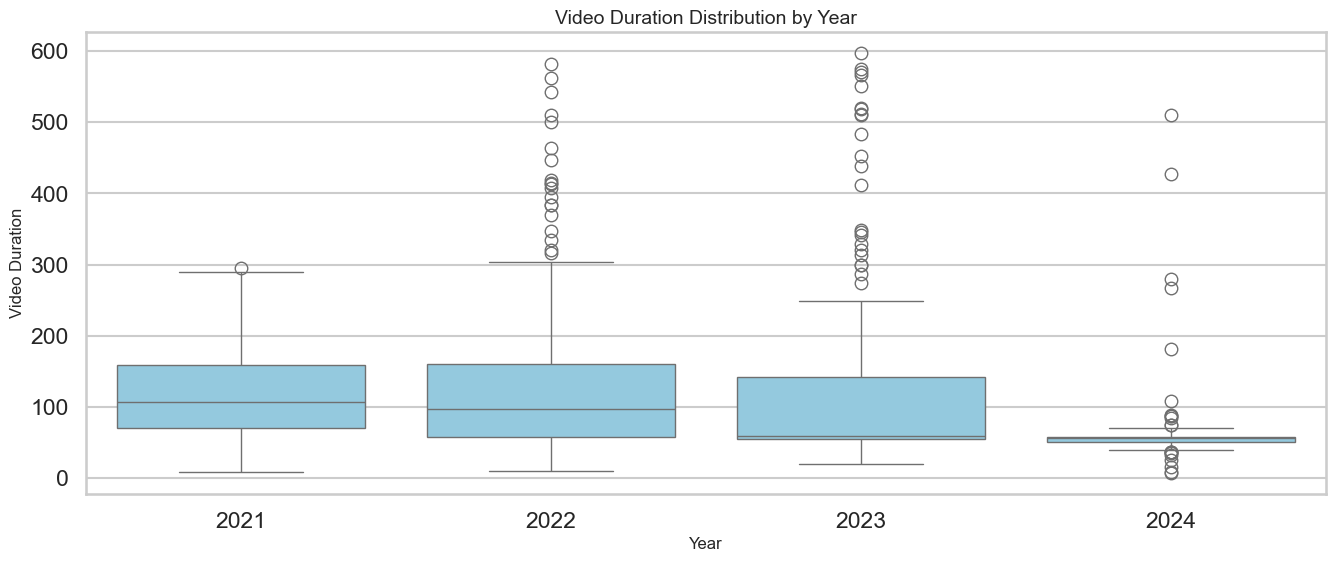

In [216]:
plt.figure(figsize=(16, 6))
sns.boxplot(x='Year', y='Video Duration', data=video_duration_contrb_by_year, color='skyblue')

plt.title('Video Duration Distribution by Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Video Duration', fontsize=12)


Dựa vào biểu đồ, ta thấy rằng xu hướng thời lượng video trung bình tăng cao trong 2022 và 2023, sau đó giảm đáng kể trong 2024.
Phân tán dữ liệu (IQR) lớn nhất trong 2022 và 2023, cho thấy sự đa dạng về thời lượng video trong giai đoạn này.
2024 có thời lượng video giảm mạnh, với dữ liệu ít phân tán hơn.
Ngoại lệ (Outliers):

Số lượng outliers lớn nhất trong 2022 và 2023, có thể do một số video có thời lượng bất thường.
2021 và 2024 có ít outliers hơn, với giá trị thời lượng thấp hơn.



### 1.4 Phân bố độ dài caption của video

In [219]:
read_df['text_length'].dropna().head(200)

0      14
1      11
2      11
3      13
4       9
       ..
195     5
196     5
197     4
198     5
199     4
Name: text_length, Length: 200, dtype: int64

Giá trị trung bình là: 6.530706836616454
Trung vị là: 3.0


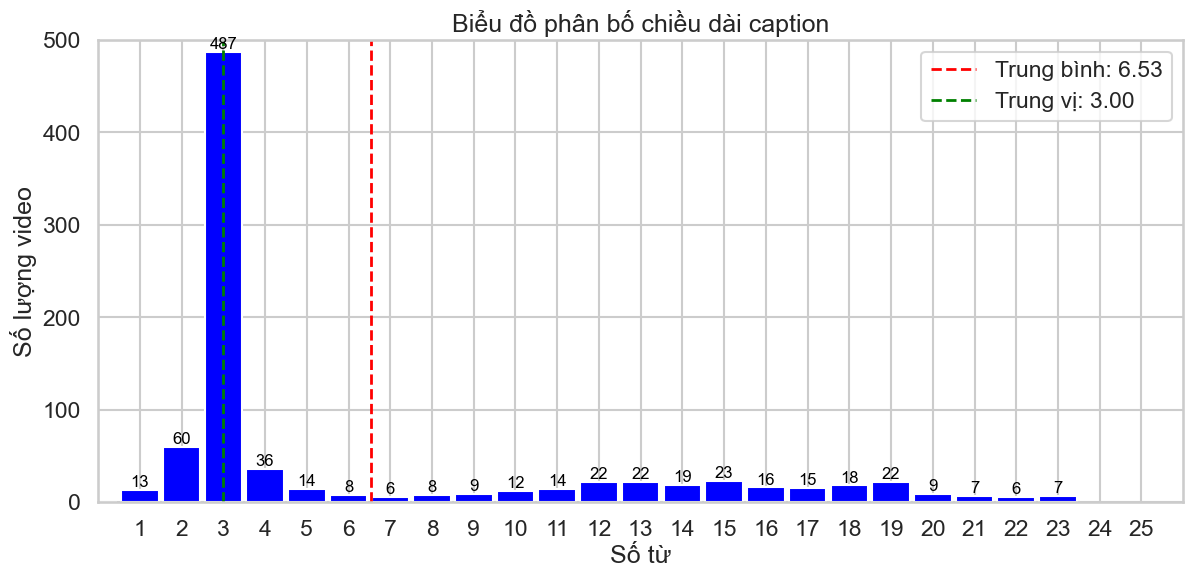

In [220]:
fig, text_length = plt.subplots(figsize=(14, 6))
text_length.hist(read_df['text_length'], bins=np.arange(0, 25, 1), color='blue', rwidth=0.9,align='left')
text_length.set_xlim(0,26)
text_length.set_ylim(0,500)
text_length.set_xticks(range(1,26,1))
text_length.set_xlabel('Số từ')
text_length.set_ylabel('Số lượng video')
text_length.set_title('Biểu đồ phân bố chiều dài caption')

for patch in text_length.patches:
    height = patch.get_height()
    if height > 0:
        text_length.text(patch.get_x() + patch.get_width() / 2,
                  height,
                  int(height),
                  ha='center', va='bottom', fontsize=12, color='black')
mean_value = read_df['text_length'].mean()
median_value = read_df['text_length'].median()
print('Giá trị trung bình là: ' + str(mean_value))
print('Trung vị là: '+ str(median_value))
text_length.axvline(mean_value, color='red', linestyle='--', linewidth=2, label=f'Trung bình: {mean_value:.2f}')
text_length.axvline(median_value, color='green', linestyle='--', linewidth=2, label=f'Trung vị: {median_value:.2f}')
text_length.legend()
plt.show()


In [221]:
text_lengths = read_df['text_length']
df_result = text_lengths.value_counts().reset_index()
df_result.columns = ['Số từ', 'Số lượng video']
df_result = df_result.sort_values(by='Số từ').reset_index(drop=True)

print(df_result)

    Số từ  Số lượng video
0       1              13
1       2              60
2       3             487
3       4              36
4       5              14
5       6               8
6       7               6
7       8               8
8       9               9
9      10              12
10     11              14
11     12              22
12     13              22
13     14              19
14     15              23
15     16              16
16     17              15
17     18              18
18     19              22
19     20               9
20     21               7
21     22               6
22     23               6
23     24               1
24     25               6
25     26               2
26     29               1
27     53               1


Chiều dài caption của các video hầu hết nằm trong khoảng 2 đến 4 kí tự với giá trị trung bình của độ dài là 6.53, giá trị trung vị là 3.00. Đây là giá trị phù hợp vì hầu hết các video tiktok cung cấp lượng lớn thông tin qua nội dung video, caption mang hàm lượng thông tin thấp, chủ yếu là chú thích và tóm tắt thêm cho nội dung video. Đây là xu hướng hiện tại của giới trẻ khi sẽ ưu tiên việc nghe nhiều hơn đọc.

## 2. Phân tích tương tác

### 2.1 Tổng quan về tương tác của tài khoản

In [225]:
print('Trung bình lượt thích là: ' + str(read_df['diggCount'].mean()))
print('Trung bình lượt bình luận là: ' + str(read_df['commentCount'].mean()))
print('Trung bình lượt lưu lại là: ' + str(read_df['collectCount'].mean()))
print('Trung bình lượt chia sẻ là: ' + str(read_df['shareCount'].mean()))
print('Trung bình lượt phát là: ' + str(read_df['playCount'].mean()))


Trung bình lượt thích là: 70468.66164542294
Trung bình lượt bình luận là: 1099.9617612977984
Trung bình lượt lưu lại là: 1763.3047508690613
Trung bình lượt chia sẻ là: 697.106604866744
Trung bình lượt phát là: 1054663.3835457705


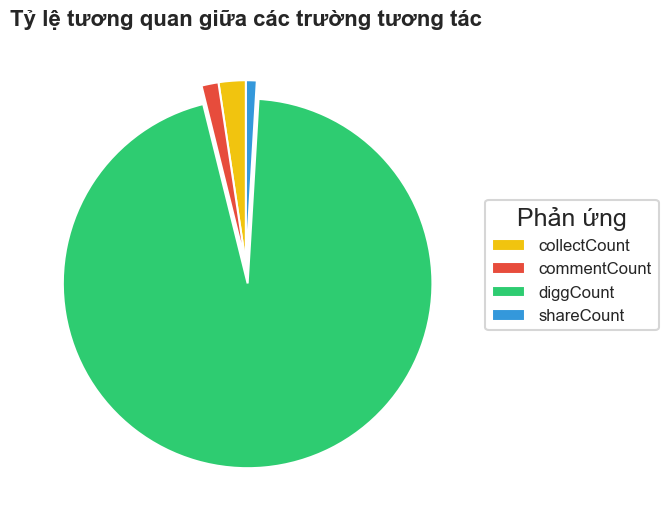

In [226]:
reaction_count = read_df[['collectCount', 'commentCount', 'diggCount', 'shareCount']].copy()

reactions = ['collectCount', 'commentCount', 'diggCount', 'shareCount']

read_df['ReactionCount'] = read_df['collectCount'] + read_df['commentCount'] + read_df['diggCount'] + read_df['shareCount']

reaction_sum = [read_df['collectCount'].sum(), read_df['commentCount'].sum(), read_df['diggCount'].sum(), read_df['shareCount'].sum() ]

mycolor = ['#f1c40f', '#e74c3c', '#2ecc71', '#3498db']  
plt.figure(figsize=(18, 6))
explode = (0, 0, 0.1, 0)  
plt.pie(reaction_sum, 
        colors=mycolor, 
        startangle=90, 
        explode=explode) 
plt.title('Tỷ lệ tương quan giữa các trường tương tác', fontsize=16, fontweight='bold')
plt.legend(reactions, 
           title="Phản ứng", 
           loc="center left", 
           bbox_to_anchor=(1, 0.5),  
           fontsize=12)



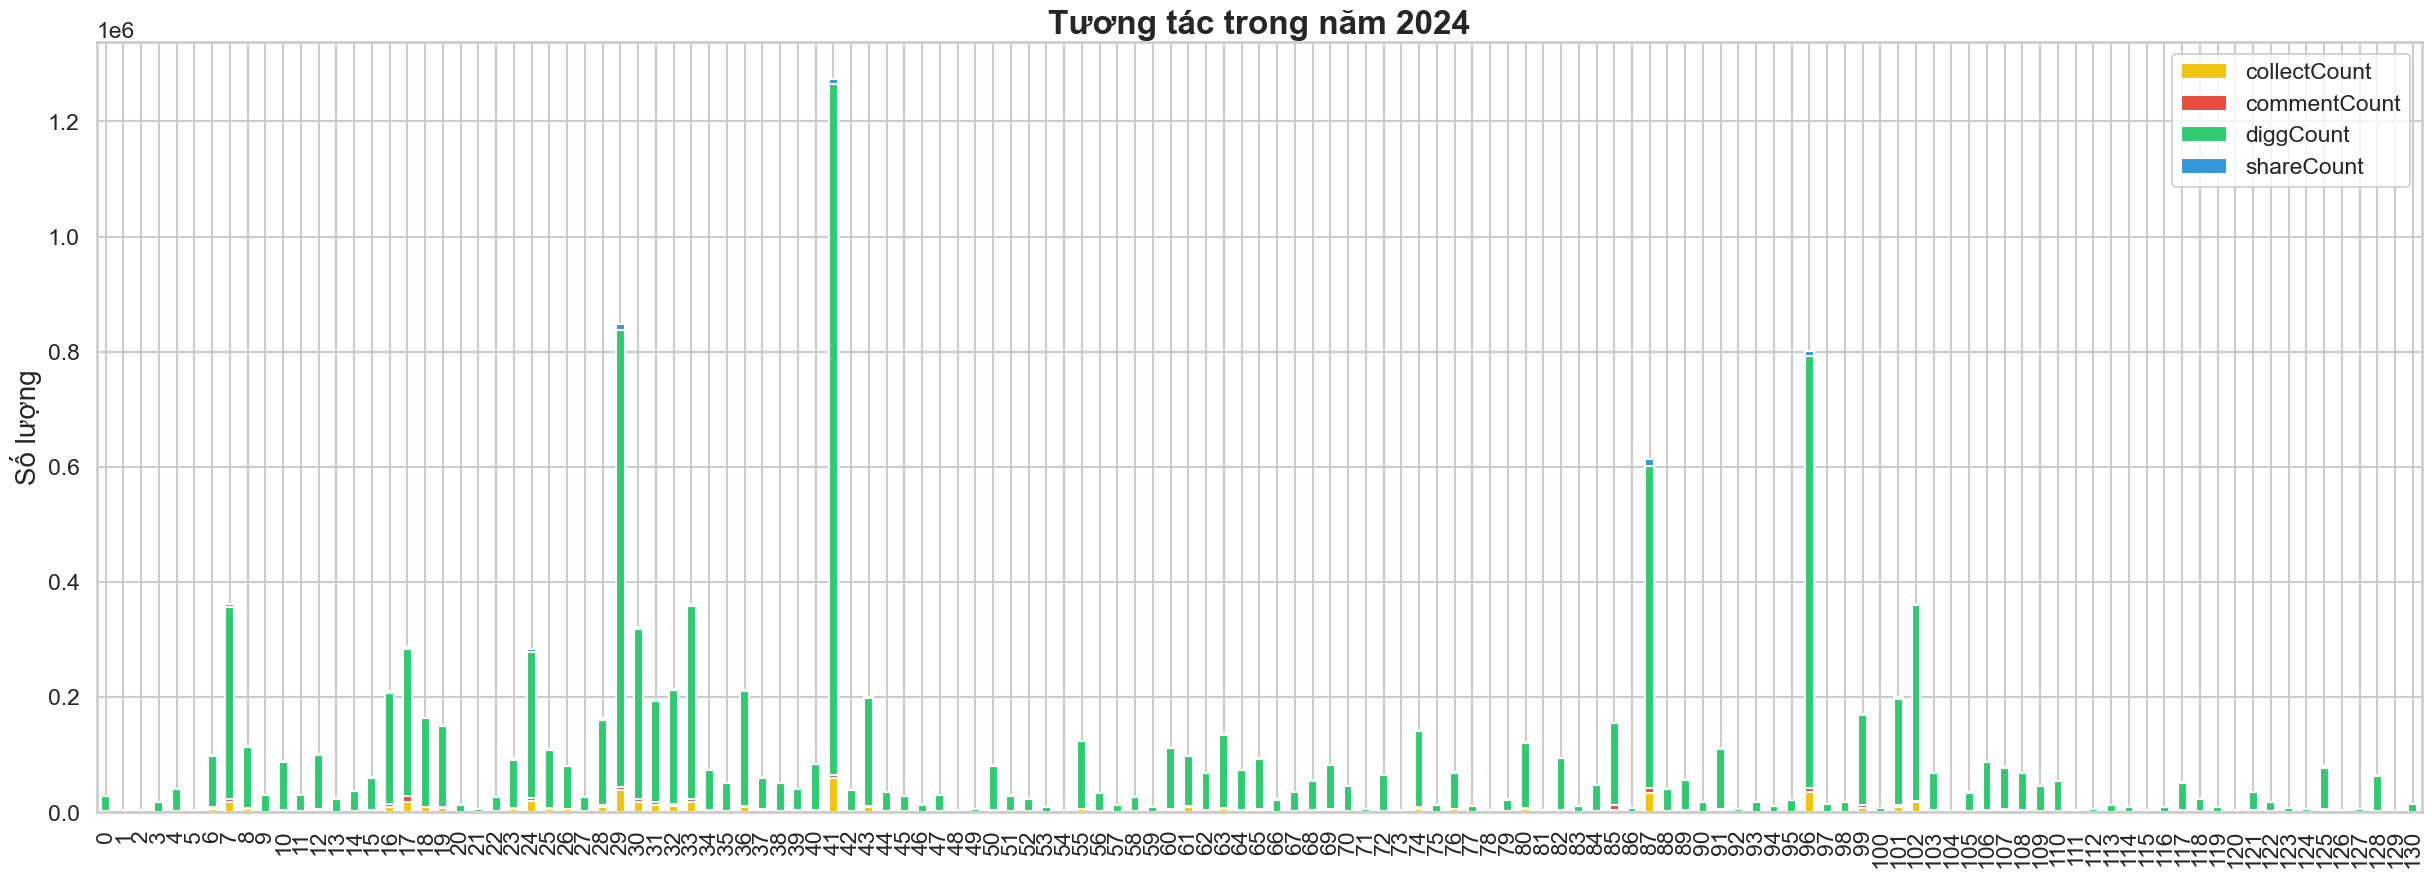

In [227]:
reaction_count_2024 = read_df[read_df['year'] == 2024][['collectCount', 'commentCount', 'diggCount', 'shareCount']]
reaction_count_2024.plot(kind='bar', stacked=True, figsize=(30, 10), color=['#f1c40f', '#e74c3c', '#2ecc71', '#3498db'])

plt.title('Tương tác trong năm 2024', fontsize=24, fontweight='bold')
plt.xlabel('', fontsize=20)
plt.ylabel('Số lượng', fontsize=20)

plt.show()


Lượt tương tác trong năm nhẩy vọt vào khoảng quý 2 sau đó giảm mạnh, duy trì , vọt lên vào cuối quý 3, đầu quý 4 trong năm, cho thấy xu hướng tương tác nhìn chung không có nhiều biến động nhưng giảm dần về cuối năm

### 2.2 Phân tích tỉ lệ tương tác, lấy ra top 10 bài có tỉ lệ tương tác cao nhất

In [230]:
rate_reaction = read_df.copy()
rate_reaction['ER'] = ((rate_reaction['diggCount'] + rate_reaction['commentCount'] + rate_reaction['shareCount']) / rate_reaction['playCount']) * 100

top_10_er = rate_reaction.nlargest(10, 'ER')


In [231]:
top_10_er['ind'] = np.arange(1, 11)
print(top_10_er[['diggCount', 'commentCount', 'shareCount', 'playCount', 'ER']])


     diggCount  commentCount  shareCount  playCount         ER
788      51500          1466         282     305900  17.406996
860      73700          1195         293     434800  17.292548
813      15300           333         146     102300  15.424242
620      59200           544         120     405300  14.770294
803     470800          6512        1952    3300000  14.523152
845     137200          6262        1030    1000000  14.449200
232      42000           476         418     301500  14.226866
792      23800           330          84     172400  14.045244
553      13300           263          70      97100  14.040165
819     123000          3006        1283     917300  13.876485


Có sự chênh lệch khá cao trong top 10 bài tương tác, thể hiện sự nhảy vọt tương tác của tài khoản

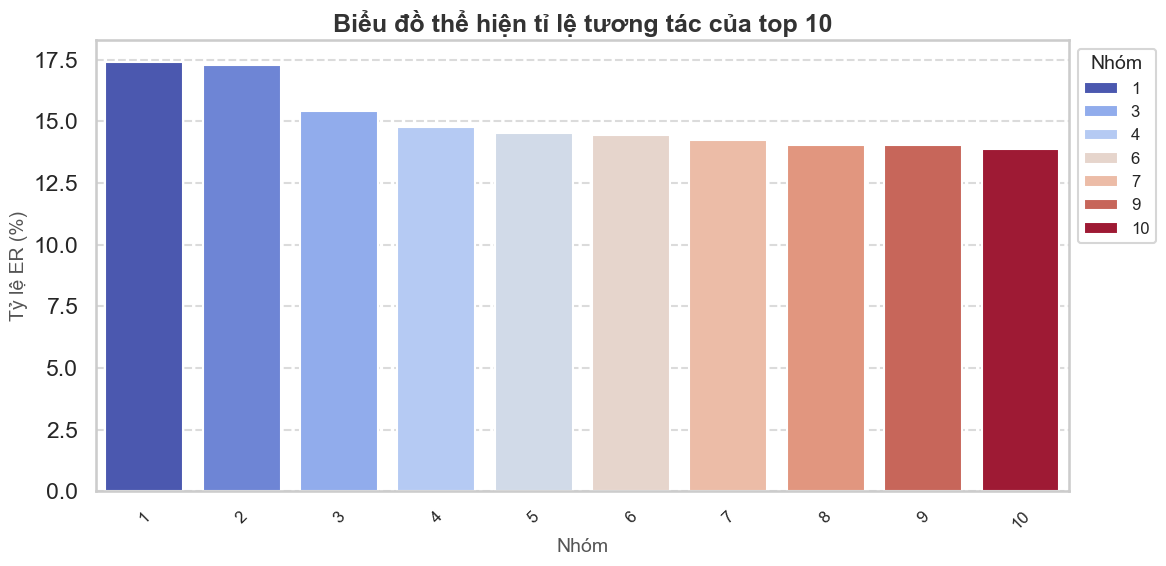

In [233]:
plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_er, x='ind', y='ER', hue='ind', palette='coolwarm')
plt.title('Biểu đồ thể hiện tỉ lệ tương tác của top 10', fontsize=18, fontweight='bold', color='#333')
plt.xlabel('Nhóm', fontsize=14, color='#555')
plt.ylabel('Tỷ lệ ER (%)', fontsize=14, color='#555')
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Nhóm', loc='upper left', bbox_to_anchor=(1, 1), fontsize=12, title_fontsize=14, frameon=True)
plt.tight_layout()
plt.show()



### 2.3 So sánh tỉ lệ tương tác của các ngày trong tuần

In [235]:
reaction_by_week = read_df[['collectCount', 'commentCount', 'diggCount', 'shareCount', 'playCount', 'createTimeISO', 'hour']].copy()
reaction_by_week['rate of reaction'] = (reaction_by_week['diggCount'] + reaction_by_week['shareCount'] + reaction_by_week['commentCount'])/(reaction_by_week['playCount'])*100
reaction_by_week['day of week'] = reaction_by_week['createTimeISO'].dt.day_of_week

In [236]:
print('Độ lệch chuẩn là: ' + str(reaction_by_week['rate of reaction'].std()))
print('Phương sai: ' + str(reaction_by_week['rate of reaction'].var()))


Độ lệch chuẩn là: 2.47373249723896
Phương sai: 6.1193524678961


<Figure size 1500x600 with 0 Axes>

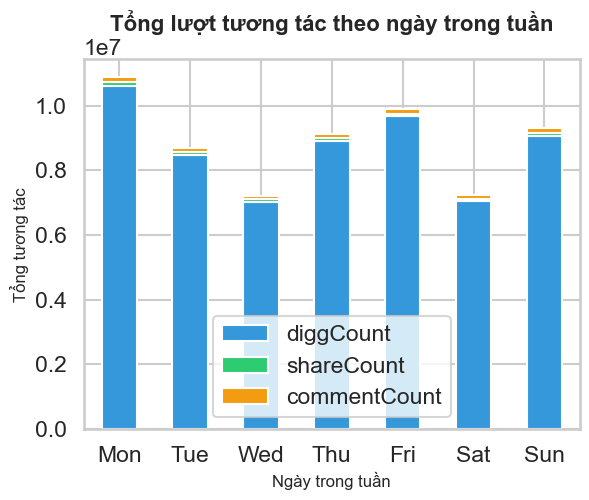

In [237]:
reaction_by_week_grouped = reaction_by_week.groupby('day of week')[['diggCount', 'shareCount', 'commentCount']].sum()
plt.figure(figsize=(15, 6))
reaction_by_week_grouped.plot(kind='bar', stacked=True, color=['#3498db', '#2ecc71', '#f39c12'])
plt.title('Tổng lượt tương tác theo ngày trong tuần', fontsize=16, fontweight='bold')
plt.xlabel('Ngày trong tuần', fontsize=12)
plt.ylabel('Tổng tương tác', fontsize=12)
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)
plt.show()


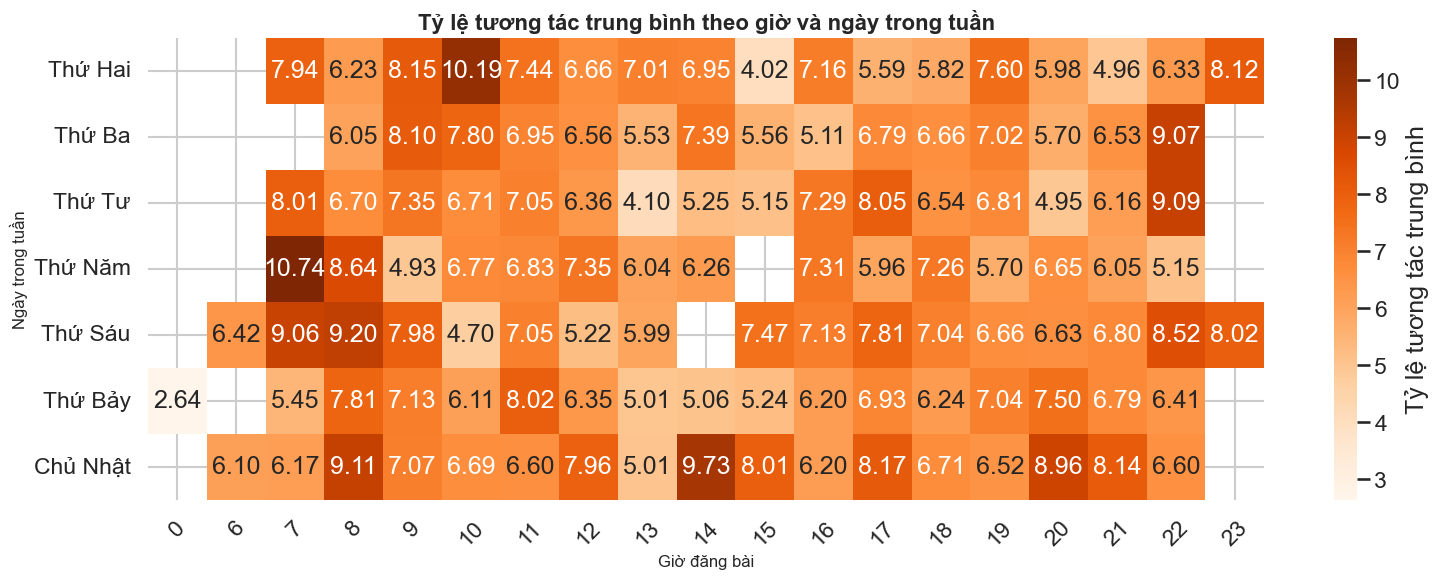

In [238]:
heatmap_data = reaction_by_week.groupby(['day of week', 'hour'])['rate of reaction'].mean().unstack()
new_labels = ["Thứ Hai", "Thứ Ba", "Thứ Tư", "Thứ Năm", "Thứ Sáu", "Thứ Bảy", "Chủ Nhật"]
heatmap_data.index = new_labels
plt.figure(figsize=(18, 6))
sns.heatmap(
    heatmap_data, 
    annot=True, 
    fmt=".2f", 
    cmap="Oranges" ,
    cbar_kws={'label': 'Tỷ lệ tương tác trung bình'}
)
plt.title("Tỷ lệ tương tác trung bình theo giờ và ngày trong tuần", fontsize=16, fontweight='bold')
plt.xlabel("Giờ đăng bài", fontsize=12)
plt.ylabel("Ngày trong tuần", fontsize=12)
plt.xticks(rotation=45)
plt.show()

Tỉ lệ tương tác trong tuần rất ổn định, xấp xỉ 7%. Trong đó cao nhất là vào Chủ nhật, với lượt tương tác xấp xỉ 7,1%
Qua đó dễ dàng nhận định lượng tương tác vào cuối tuần hoặc đầu tuần thường có xu hướng cao hơn các ngày trong tuần


### 2.4 Phân tích tương tác của tài khoản qua comment

In [242]:
comment_data = read_df.copy()
print('Tổng số lượt comment là: ' + str(comment_data['commentCount'].sum()))
print('Trung bình lượt commnet là: ' + str(comment_data['commentCount'].mean()))
print('Trung vị số comment là: ' + str(comment_data['commentCount'].median()))


Tổng số lượt comment là: 949267
Trung bình lượt commnet là: 1099.9617612977984
Trung vị số comment là: 369.0


In [243]:
#Video có lượt comment cao nhất:
cmt_max_comment = comment_data['commentCount'].max()
print_max = comment_data[comment_data['commentCount'] == cmt_max_comment]
print_max


,collectCount,commentCount,createTime,createTimeISO,diggCount,hashtags/0/name,hashtags/1/name,hashtags/2/name,musicMeta/musicAuthor,playCount,...,date,hour,year,month,day,text_length,day_of_week,day_of_month,Date,ReactionCount
643,6391,31000,1647739480,2022-03-20 08:24:40+07:00,662300,dongmauviet,dcgr,vietnam,DÃ²ng MÃ¡u Viá»t,7500000,...,2022-03-20,8,2022,3,20,3,Sunday,20,2022-03-20,710691


In [244]:
#Video có lượt comment thấp nhất:
cmt_min_comment = comment_data['commentCount'].min()
print_min = comment_data[comment_data['commentCount'] == cmt_min_comment]
print_min


,collectCount,commentCount,createTime,createTimeISO,diggCount,hashtags/0/name,hashtags/1/name,hashtags/2/name,musicMeta/musicAuthor,playCount,...,date,hour,year,month,day,text_length,day_of_week,day_of_month,Date,ReactionCount
290,44,5,1677556303,2023-02-28 10:51:43+07:00,811,dongmauviet,dcgr,lichsuvietnam,DÃ²ng MÃ¡u Viá»t,23400,...,2023-02-28,10,2023,2,28,3,Tuesday,28,2023-02-28,867


In [245]:
#Top 10 video có lượt commnet nhiều nhất
top_10_comments = comment_data.nlargest(10, 'commentCount')
top_10_comments

,collectCount,commentCount,createTime,createTimeISO,diggCount,hashtags/0/name,hashtags/1/name,hashtags/2/name,musicMeta/musicAuthor,playCount,...,date,hour,year,month,day,text_length,day_of_week,day_of_month,Date,ReactionCount
643,6391,31000,1647739480,2022-03-20 08:24:40+07:00,662300,dongmauviet,dcgr,vietnam,DÃ²ng MÃ¡u Viá»t,7500000,...,2022-03-20,8,2022,3,20,3,Sunday,20,2022-03-20,710691
247,21800,14800,1680349705,2023-04-01 18:48:25+07:00,672200,dongmauviet,dcgr,lichsuvietnam,DÃ²ng MÃ¡u Viá»t,8300000,...,2023-04-01,18,2023,4,1,3,Saturday,1,2023-04-01,714689
649,6544,13800,1647229850,2022-03-14 10:50:50+07:00,836700,dongmauviet,dcgr,lichsuvietnam,DÃ²ng MÃ¡u Viá»t,10600000,...,2022-03-14,10,2022,3,14,3,Monday,14,2022-03-14,862385
755,6413,13200,1638157010,2021-11-29 10:36:50+07:00,746200,dongmauviet,dcgr,lichsuvietnam,DÃ²ng MÃ¡u Viá»t,11700000,...,2021-11-29,10,2021,11,29,3,Monday,29,2021-11-29,770776
816,8144,11900,1633089103,2021-10-01 18:51:43+07:00,1000000,dongmauviet,lichsuvietnam,NaN,DÃ²ng MÃ¡u Viá»t,8300000,...,2021-10-01,18,2021,10,1,2,Friday,1,2021-10-01,1025749
17,17200,11000,1725771065,2024-09-08 11:51:05+07:00,254900,dongmauviet,NaN,NaN,DÃ²ng MÃ¡u Viá»t,4500000,...,2024-09-08,11,2024,9,8,9,Sunday,8,2024-09-08,287977
805,1162,10700,1633752002,2021-10-09 11:00:02+07:00,444700,dongmauviet,NaN,NaN,DÃ²ng MÃ¡u Viá»t,5600000,...,2021-10-09,11,2021,10,9,1,Saturday,9,2021-10-09,460158
297,19300,10600,1676911601,2023-02-20 23:46:41+07:00,553300,dongmauviet,dcgr,lichsuvietnam,DÃ²ng MÃ¡u Viá»t,7000000,...,2023-02-20,23,2023,2,20,3,Monday,20,2023-02-20,587501
662,18400,10100,1646044755,2022-02-28 17:39:15+07:00,887000,dongmauviet,dcgr,lichsuvietnam,DÃ²ng MÃ¡u Viá»t,11400000,...,2022-02-28,17,2022,2,28,3,Monday,28,2022-02-28,943100
497,13700,9252,1656819593,2022-07-03 10:39:53+07:00,434200,dongmauviet,dcgr,lichsuvietnam,DÃ²ng MÃ¡u Viá»t,5400000,...,2022-07-03,10,2022,7,3,3,Sunday,3,2022-07-03,459594


In [246]:
video_comment_by_week = pd.DataFrame()
video_comment_by_week['Week'] = pd.to_datetime(read_df['createTimeISO']).dt.strftime('%Y-%W')
video_comment_by_week = video_comment_by_week.sort_values('Week')
video_comment_by_week = video_comment_by_week.groupby('Week').size().reset_index(name='commentCount')

video_comment_by_month = pd.DataFrame()
video_comment_by_month['Month'] = pd.to_datetime(read_df['createTimeISO']).dt.strftime('%Y-%m')
video_comment_by_month= video_comment_by_month.sort_values('Month')
video_comment_by_month= video_comment_by_month.groupby('Month').size().reset_index(name='commentCount')

video_comment_by_year = pd.DataFrame()
video_comment_by_year['Year'] = pd.to_datetime(read_df['createTimeISO']).dt.strftime('%Y')
video_comment_by_year= video_comment_by_year.sort_values('Year')
video_comment_by_year= video_comment_by_year.groupby('Year').size().reset_index(name='commentCount')

Text(0.5, 1.0, 'Video comment count by Year')

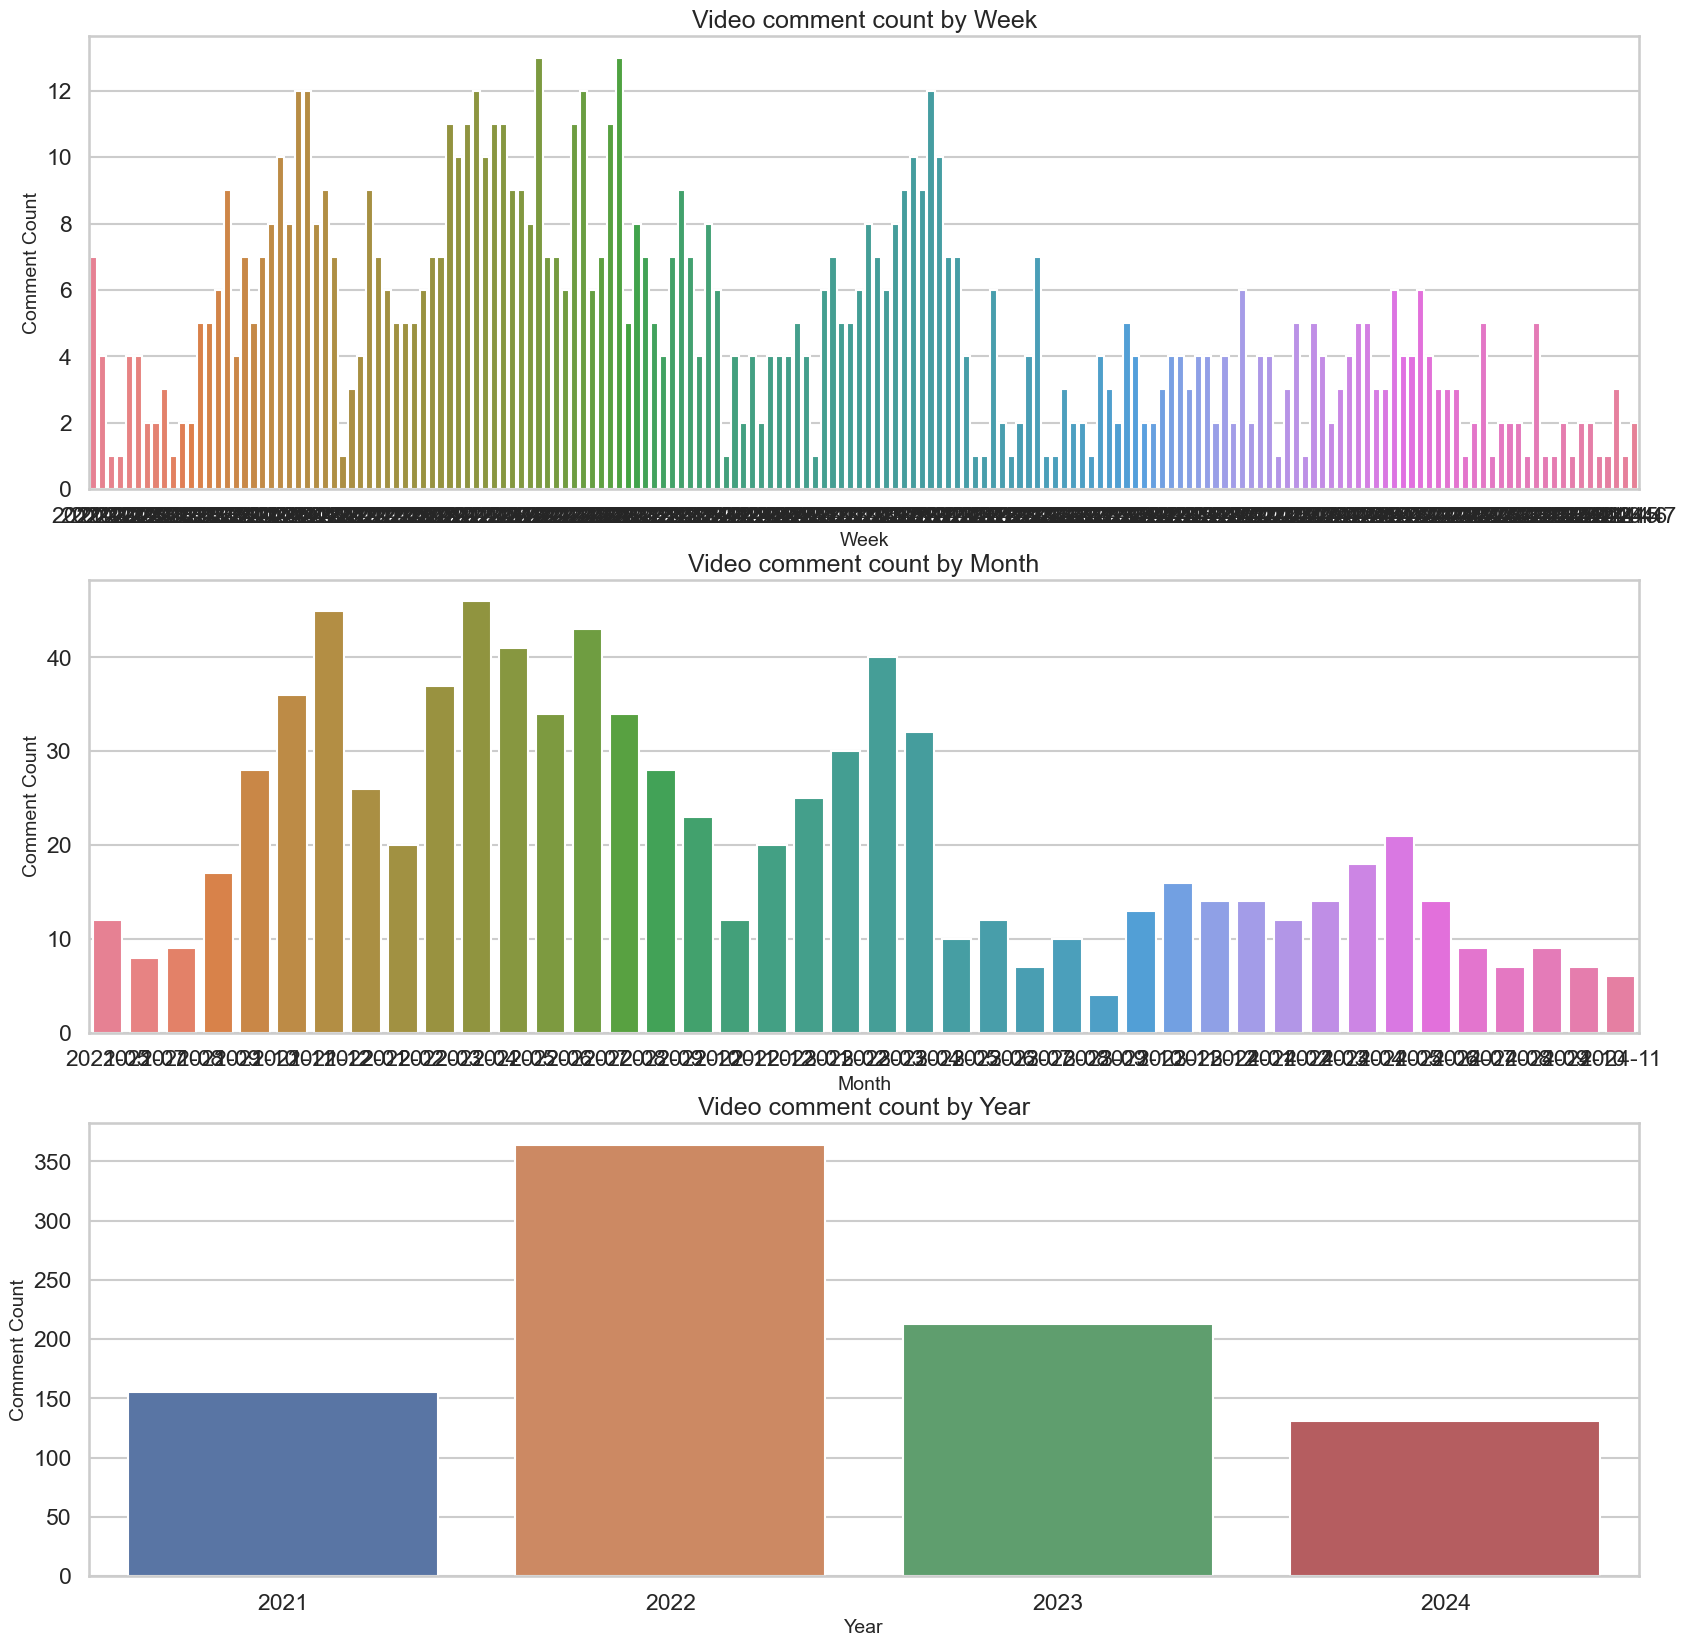

In [247]:
fig, axes = plt.subplots(3,1,figsize = (20,20))
sns.barplot(data= video_comment_by_week, x = 'Week', y='commentCount', ax=axes[0], hue = 'Week')
axes[0].set_xlabel('Week', fontsize = 14)
axes[0].set_ylabel('Comment Count', fontsize = 14)
axes[0].set_title('Video comment count by Week', fontsize =18)

sns.barplot(data= video_comment_by_month, x = 'Month', y='commentCount', ax=axes[1], hue = 'Month')
axes[1].set_xlabel('Month', fontsize = 14)
axes[1].set_ylabel('Comment Count', fontsize = 14)
axes[1].set_title('Video comment count by Month', fontsize =18)

sns.barplot(data= video_comment_by_year, x = 'Year', y='commentCount', ax=axes[2], hue = 'Year')
axes[2].set_xlabel('Year', fontsize = 14)
axes[2].set_ylabel('Comment Count', fontsize = 14)
axes[2].set_title('Video comment count by Year', fontsize =18)

### 2.5 Phân tích tương tác của tài khoản qua lượt Share

In [249]:
share_data = read_df.copy()
print('Tổng số lượt share là: ' + str(share_data['shareCount'].sum()))
print('Trung bình lượt share là: ' + str(share_data['shareCount'].mean()))
print('Trung vị số share là: ' + str(share_data['shareCount'].median()))


Tổng số lượt share là: 601603
Trung bình lượt share là: 697.106604866744
Trung vị số share là: 172.0


In [250]:
#Video có lượt share cao nhất:
share_max_comment = share_data['shareCount'].max()
print_max = share_data[share_data['shareCount'] == share_max_comment]
print_max

,collectCount,commentCount,createTime,createTimeISO,diggCount,hashtags/0/name,hashtags/1/name,hashtags/2/name,musicMeta/musicAuthor,playCount,...,date,hour,year,month,day,text_length,day_of_week,day_of_month,Date,ReactionCount
662,18400,10100,1646044755,2022-02-28 17:39:15+07:00,887000,dongmauviet,dcgr,lichsuvietnam,DÃ²ng MÃ¡u Viá»t,11400000,...,2022-02-28,17,2022,2,28,3,Monday,28,2022-02-28,943100


(18993.0, 20028.0)

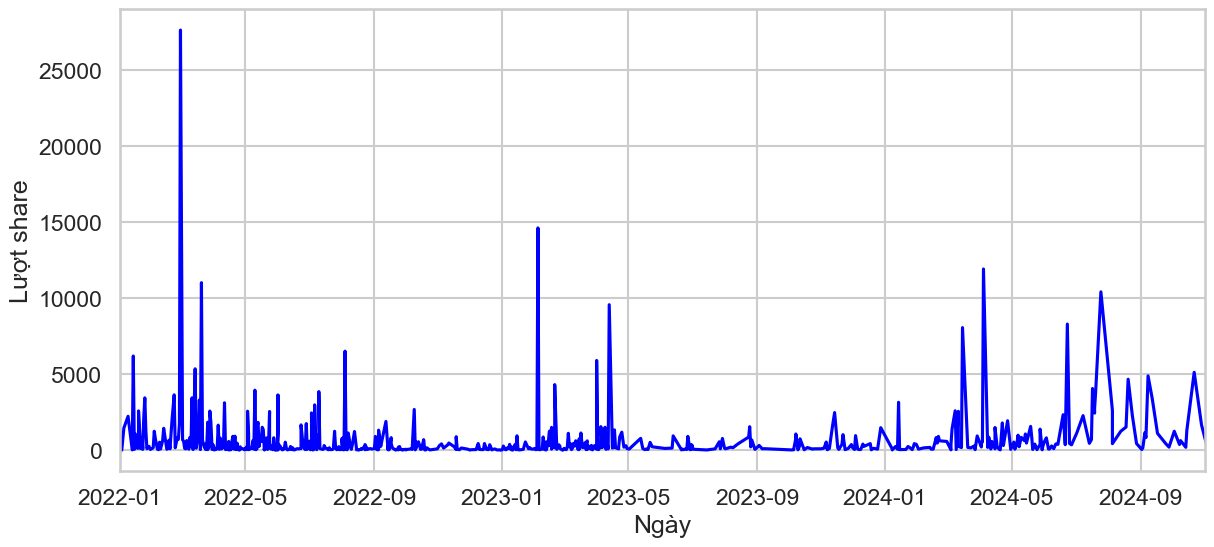

In [251]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(read_df['date'], read_df['shareCount'], color='blue')
ax.set_xlabel('Ngày')
ax.set_ylabel('Lượt share')
ax.set_xlim(pd.to_datetime('2022-01-01'), pd.to_datetime('2024-11-01'))

Biểu đồ cho thấy sự biến động rất lớn, với những đỉnh cao và sụt giảm đột ngột trong số lượng chia sẻ theo thời gian được hiển thị. Có một số đỉnh cao, nơi số lượng chia sẻ vượt quá 20.000, sau đó lại giảm đáng kể.

C:\Users\DELL\AppData\Local\Temp\ipykernel_15472\955162921.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = read_df.groupby(['day_of_week', 'hour'])['shareCount'].sum().unstack()


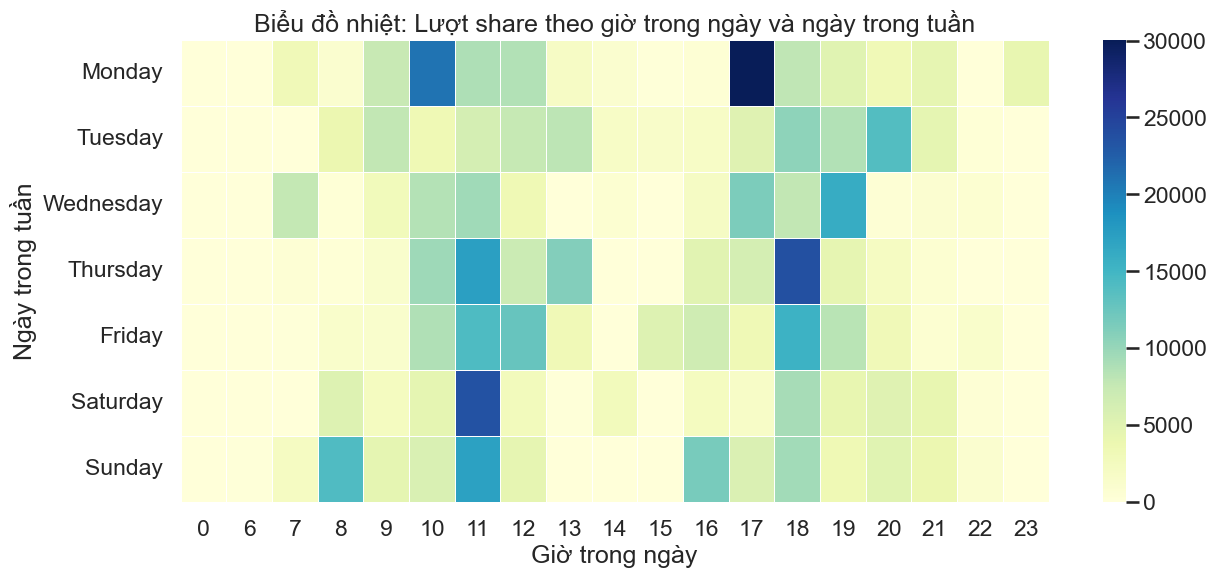

In [253]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
read_df['day_of_week'] = pd.Categorical(read_df['day_of_week'], categories=day_order, ordered=True)
heatmap_data = read_df.groupby(['day_of_week', 'hour'])['shareCount'].sum().unstack()

plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data, cmap='YlGnBu', fmt='g', linewidths=0.5)

plt.title('Biểu đồ nhiệt: Lượt share theo giờ trong ngày và ngày trong tuần')
plt.xlabel('Giờ trong ngày')
plt.ylabel('Ngày trong tuần')

plt.show()

Từ biểu đồ nhiệt trên, ta có thể dễ dàng nhận thấy lượng tương tác share tập chung chủ yếu vào các khung giờ 10-12h, 17-19 giờ, và nhiều nhất vào thứ hai.

### 2.6 Phân tích tương tác của tài khoản qua lượt Yêu thích (Collect)

In [256]:
sum_posts = read_df['collectCount'].sum()
mean_posts = read_df['collectCount'].mean()  
std_posts = read_df['collectCount'].std()    
median_posts = read_df['collectCount'].median()  

print(f"Tổng lượt yêu thích: {sum_posts:.2f}")
print(f"Trung bình lượt yêu thích: {mean_posts:.2f}")
print(f"Độ lệch chuẩn của lượt yêu thích: {std_posts:.2f}")
print(f"Trung vị của lượt yêu thích: {median_posts:.2f}")


Tổng lượt yêu thích: 1521732.00
Trung bình lượt yêu thích: 1763.30
Độ lệch chuẩn của lượt yêu thích: 4303.24
Trung vị của lượt yêu thích: 453.00


In [257]:
Collect_data = read_df.copy()
collect_max = Collect_data['collectCount'].max()  # Tìm giá trị lớn nhất của lượt yêu thích
print_max = Collect_data[Collect_data['collectCount'] == collect_max]  # Lọc dữ liệu với giá trị lớn nhất
print_max


,collectCount,commentCount,createTime,createTimeISO,diggCount,hashtags/0/name,hashtags/1/name,hashtags/2/name,musicMeta/musicAuthor,playCount,...,date,hour,year,month,day,text_length,day_of_week,day_of_month,Date,ReactionCount
41,60100,5269,1719136744,2024-06-23 16:59:04+07:00,1200000,dcgr,dongmauviet,NaN,DÃ²ng MÃ¡u Viá»t,19200000,...,2024-06-23,16,2024,6,23,20,Sunday,23,2024-06-23,1273649


In [258]:
# Video có lượt collect thấp nhất:
collect_min_count = Collect_data['collectCount'].min()
print_min = Collect_data[Collect_data['collectCount'] == collect_min_count]
print_min

,collectCount,commentCount,createTime,createTimeISO,diggCount,hashtags/0/name,hashtags/1/name,hashtags/2/name,musicMeta/musicAuthor,playCount,...,date,hour,year,month,day,text_length,day_of_week,day_of_month,Date,ReactionCount
706,3,42,1641204007,2022-01-03 17:00:07+07:00,2925,dongmauviet,dcgr,lichsuvietnam,DÃ²ng MÃ¡u Viá»t,84100,...,2022-01-03,17,2022,1,3,3,Monday,3,2022-01-03,2971
844,3,38,1627665912,2021-07-31 00:25:12+07:00,1158,NaN,dongmauviet,vietnam,DÃ²ng MÃ¡u Viá»t,45400,...,2021-07-31,0,2021,7,31,10,Saturday,31,2021-07-31,1200


In [259]:
top_10 = Collect_data.nlargest(10, 'collectCount')
top_10

,collectCount,commentCount,createTime,createTimeISO,diggCount,hashtags/0/name,hashtags/1/name,hashtags/2/name,musicMeta/musicAuthor,playCount,...,date,hour,year,month,day,text_length,day_of_week,day_of_month,Date,ReactionCount
41,60100,5269,1719136744,2024-06-23 16:59:04+07:00,1200000,dcgr,dongmauviet,NaN,DÃ²ng MÃ¡u Viá»t,19200000,...,2024-06-23,16,2024,6,23,20,Sunday,23,2024-06-23,1273649
485,40000,7841,1657462959,2022-07-10 21:22:39+07:00,1100000,dongmauviet,dcgr,vietnam,DÃ²ng MÃ¡u Viá»t,10500000,...,2022-07-10,21,2022,7,10,3,Sunday,10,2022-07-10,1151683
29,39600,4812,1721888128,2024-07-25 13:15:28+07:00,794200,dongmauviet,NaN,NaN,DÃ²ng MÃ¡u Viá»t,8500000,...,2024-07-25,13,2024,7,25,12,Thursday,25,2024-07-25,849012
96,35800,7120,1710482040,2024-03-15 12:54:00+07:00,750400,dcgr,dongmauviet,NaN,DÃ²ng MÃ¡u Viá»t,20100000,...,2024-03-15,12,2024,3,15,15,Friday,15,2024-03-15,801369
87,33400,8603,1712228567,2024-04-04 18:02:47+07:00,559900,dcgr,dongmauviet,NaN,DÃ²ng MÃ¡u Viá»t,9500000,...,2024-04-04,18,2024,4,4,11,Thursday,4,2024-04-04,613803
229,27200,5692,1681358945,2023-04-13 11:09:05+07:00,639900,dongmauviet,dcgr,lichsuvietnam,DÃ²ng MÃ¡u Viá»t,9600000,...,2023-04-13,11,2023,4,13,3,Thursday,13,2023-04-13,682345
330,23000,1181,1673782145,2023-01-15 18:29:05+07:00,465600,dongmauviet,dcgr,lichsuvietnam,DÃ²ng MÃ¡u Viá»t,4500000,...,2023-01-15,18,2023,1,15,3,Sunday,15,2023-01-15,490721
247,21800,14800,1680349705,2023-04-01 18:48:25+07:00,672200,dongmauviet,dcgr,lichsuvietnam,DÃ²ng MÃ¡u Viá»t,8300000,...,2023-04-01,18,2023,4,1,3,Saturday,1,2023-04-01,714689
315,20200,4237,1675484775,2023-02-04 11:26:15+07:00,237100,dongmauviet,dcgr,vietnam,DÃ²ng MÃ¡u Viá»t,3300000,...,2023-02-04,11,2023,2,4,3,Saturday,4,2023-02-04,276137
24,19900,5160,1724133888,2024-08-20 13:04:48+07:00,253400,dongmauviet,NaN,NaN,DÃ²ng MÃ¡u Viá»t,5200000,...,2024-08-20,13,2024,8,20,17,Tuesday,20,2024-08-20,283119


In [260]:
# Theo tuần
video_collect_by_week = pd.DataFrame()
video_collect_by_week['Week'] = pd.to_datetime(read_df['createTimeISO']).dt.strftime('%Y-%W')
video_collect_by_week = video_collect_by_week.sort_values('Week')
video_collect_by_week = video_collect_by_week.groupby('Week').size().reset_index(name='collectCount')
video_collect_by_week

# Theo tháng
video_collect_by_month = pd.DataFrame()
video_collect_by_month['Month'] = pd.to_datetime(read_df['createTimeISO']).dt.strftime('%Y-%m')
video_collect_by_month = video_collect_by_month.sort_values('Month')
video_collect_by_month = video_collect_by_month.groupby('Month').size().reset_index(name='collectCount')

# Theo năm
video_collect_by_year = pd.DataFrame()
video_collect_by_year['Year'] = pd.to_datetime(read_df['createTimeISO']).dt.strftime('%Y')
video_collect_by_year = video_collect_by_year.sort_values('Year')
video_collect_by_year = video_collect_by_year.groupby('Year').size().reset_index(name='collectCount')
video_collect_by_year


,Year,collectCount
0,2021,155
1,2022,364
2,2023,213
3,2024,131


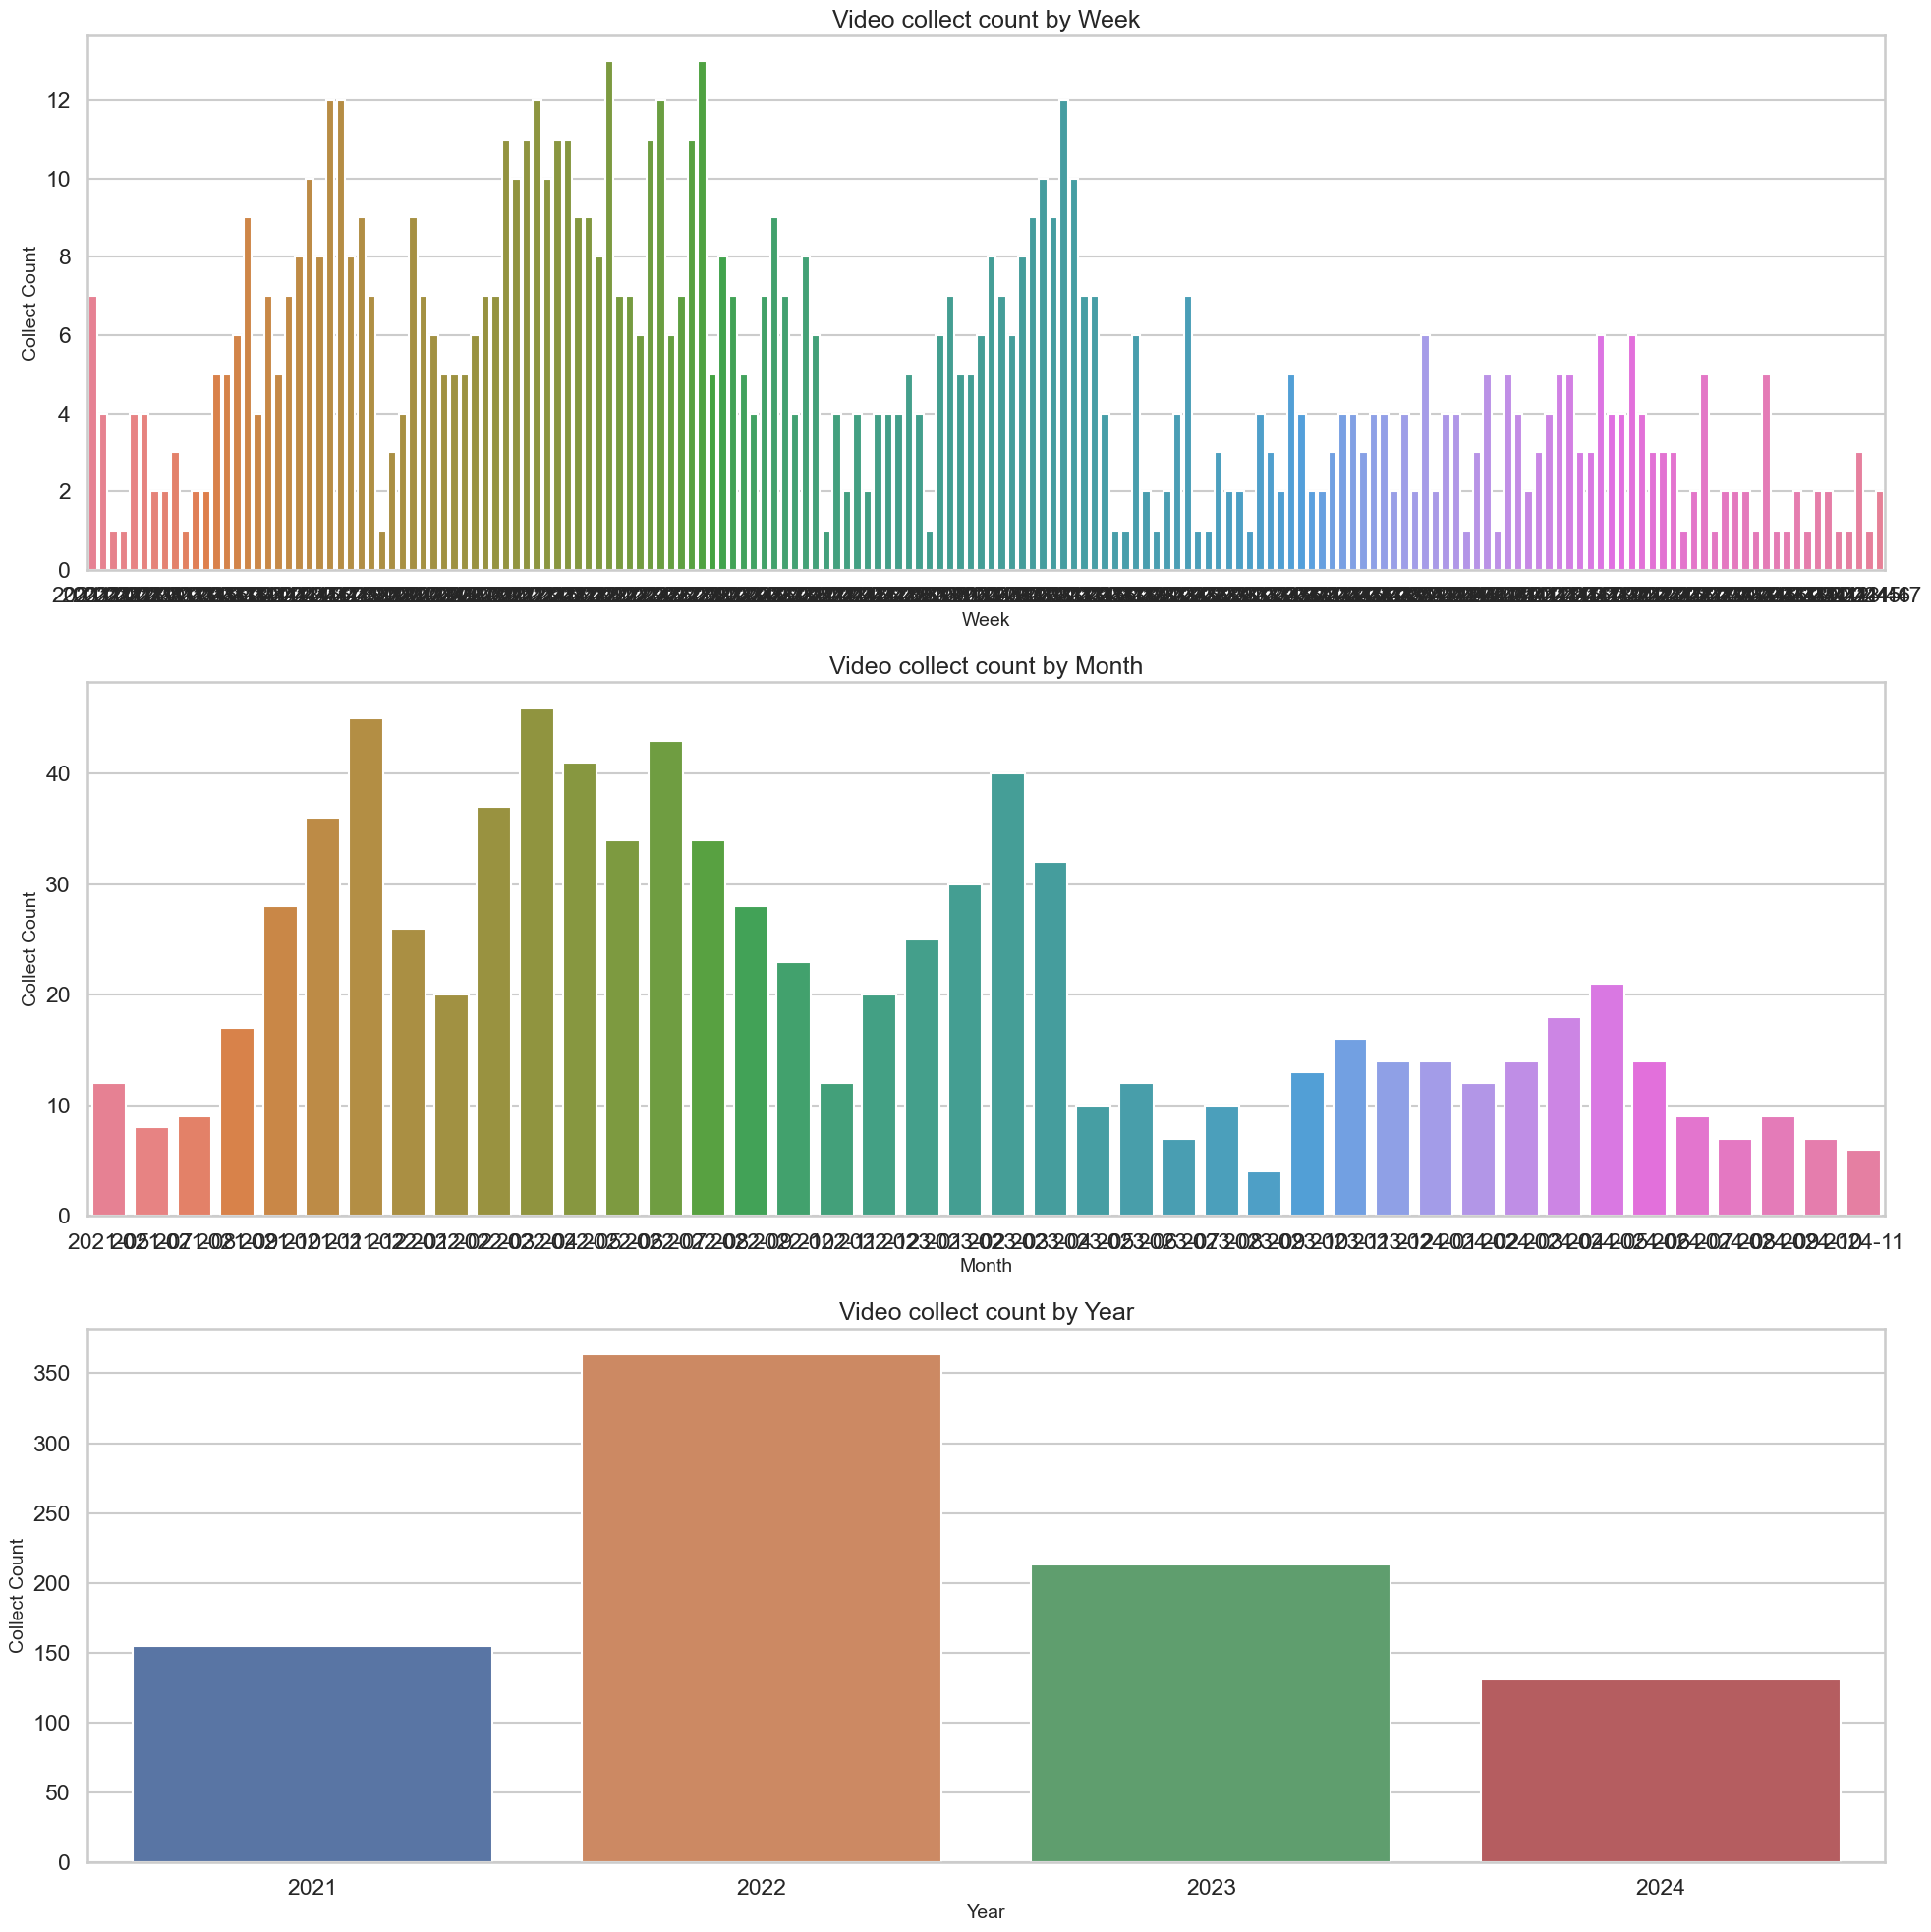

In [261]:
from matplotlib.ticker import FuncFormatter
def format_number_short(x, _):
    if x >= 1_000_000:
        return f"{x / 1_000_000:.1f}M"
    elif x >= 1_000:
        return f"{x / 1_000:.1f}K"
    else:
        return str(int(x))

fig, axes = plt.subplots(3, 1, figsize=(20, 20))

# Theo tuần
sns.barplot(data=video_collect_by_week, x='Week', y='collectCount', ax=axes[0], hue='Week')
axes[0].set_xlabel('Week', fontsize=14)
axes[0].set_ylabel('Collect Count', fontsize=14)
axes[0].set_title('Video collect count by Week', fontsize=18)
axes[0].yaxis.set_major_formatter(FuncFormatter(format_number_short))

# Theo tháng
sns.barplot(data=video_collect_by_month, x='Month', y='collectCount', ax=axes[1], hue='Month')
axes[1].set_xlabel('Month', fontsize=14)
axes[1].set_ylabel('Collect Count', fontsize=14)
axes[1].set_title('Video collect count by Month', fontsize=18)
axes[1].yaxis.set_major_formatter(FuncFormatter(format_number_short))

# Theo năm
sns.barplot(data=video_collect_by_year, x='Year', y='collectCount', ax=axes[2], hue='Year')
axes[2].set_xlabel('Year', fontsize=14)
axes[2].set_ylabel('Collect Count', fontsize=14)
axes[2].set_title('Video collect count by Year', fontsize=18)
axes[2].yaxis.set_major_formatter(FuncFormatter(format_number_short))

plt.tight_layout()
plt.show()


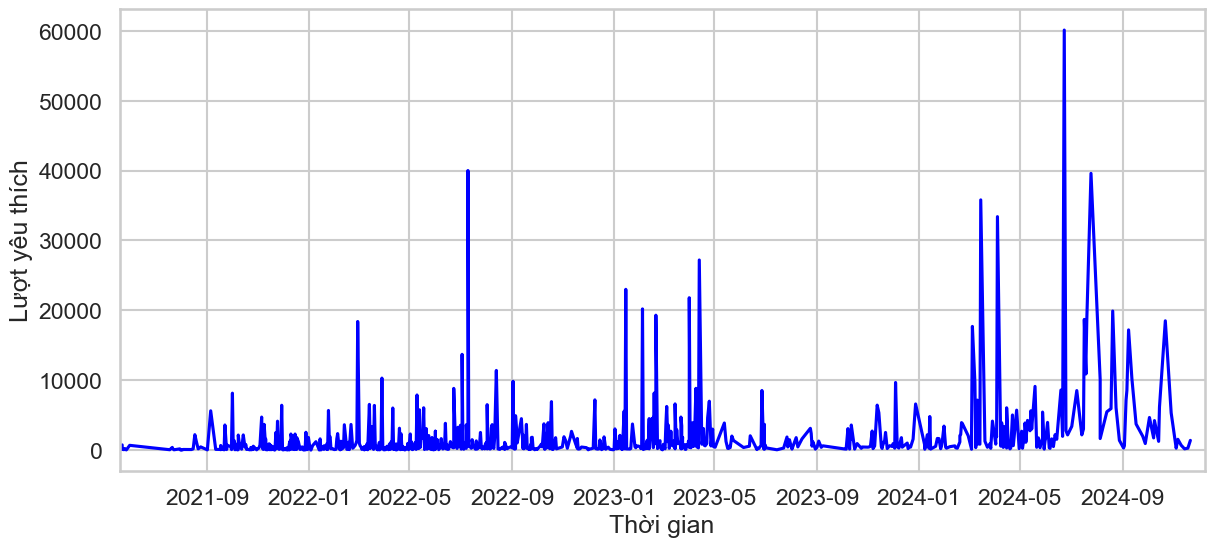

In [262]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(read_df['date'], read_df['collectCount'], color='blue')
ax.set_xlabel('Thời gian')
ax.set_ylabel('Lượt yêu thích')

# Thiết lập xlim từ ngày sớm nhất trong dữ liệu đến hiện tại
ax.set_xlim(pd.to_datetime(read_df['date'].min()), pd.Timestamp.now())
plt.show()


Biểu đồ này thể hiện lượt yêu thích được ghi nhận trên Tiktok theo trục thời gian từ cuối năm 2021 đến năm 2024.

C:\Users\DELL\AppData\Local\Temp\ipykernel_15472\2143570276.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = filtered_df.groupby(['day_of_week', 'hour'])['collectCount'].sum().unstack()


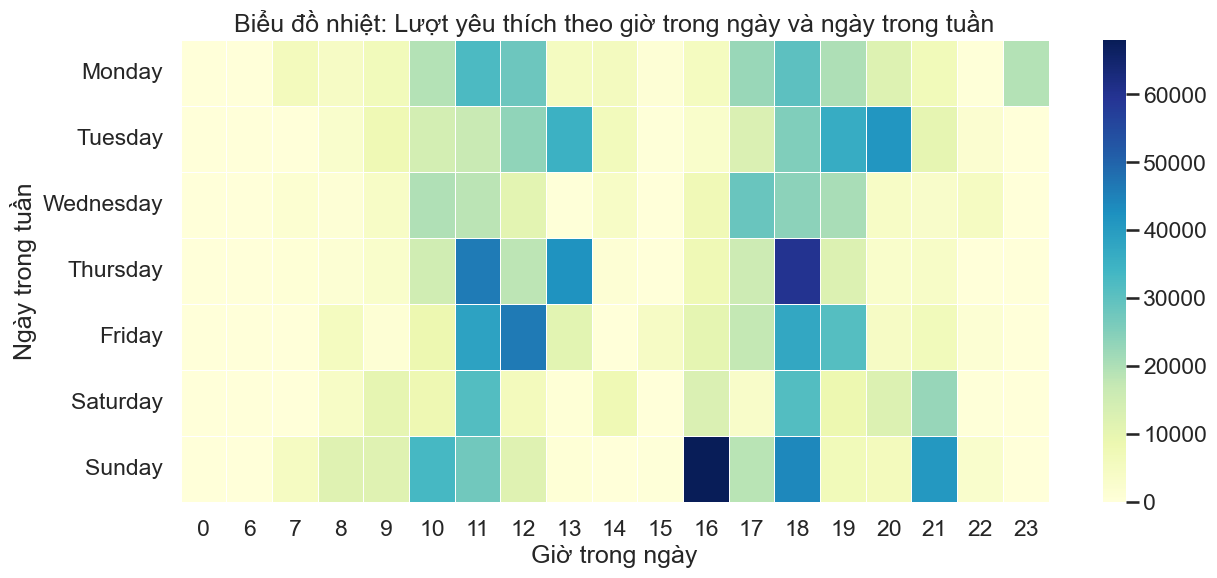

In [264]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
read_df['day_of_week'] = pd.Categorical(read_df['day_of_week'], categories=day_order, ordered=True)

start_date = pd.to_datetime(read_df['date'].min())
end_date = pd.Timestamp.now()
filtered_df = read_df[(read_df['date'] >= start_date) & (read_df['date'] <= end_date)]

heatmap_data = filtered_df.groupby(['day_of_week', 'hour'])['collectCount'].sum().unstack()

plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data, cmap='YlGnBu', fmt='g', linewidths=0.5)
plt.title('Biểu đồ nhiệt: Lượt yêu thích theo giờ trong ngày và ngày trong tuần')
plt.xlabel('Giờ trong ngày')
plt.ylabel('Ngày trong tuần')

plt.show()


Biểu đồ này thể hiện sự phân bố lượt yêu thích theo giờ trong ngày (trục ngang) và ngày trong tuần (trục dọc).

**Dựa vào biểu đồ ta thấy:**
- Theo các ngày trong tuần:
    + Lượt yêu thích tập trung vào thứ Năm và Chủ Nhật
- Theo giờ trong ngày:
    + Ta dễ dàng nhận thấy, lượt yêu thích thường tập trung từ 11 giờ đến 18 giờ. Lượt yêu thích cao nhất tại 2 khung giờ trong ngày là 11 giờ và 18 giờ -> Đây thường là thời gian mọi người nghỉ hơn, rảnh rỗi -> tỉ lệ online cao hơn.
    + Lượt yêu thích thường thấp vào buổi sáng sớm (0h - 6h) và đêm khuya, phản ánh thói quen sử dụng nền tảng của khán giả.

### 2.7 Phân tích tương tác của tài khoản qua lượt xem (Play)

In [268]:
sum_posts = read_df['playCount'].sum()
mean_posts = read_df['playCount'].mean() 
std_posts = read_df['playCount'].std()    
median_posts = read_df['playCount'].median() 

print(f"Tổng lượt xem: {sum_posts:.2f}")
print(f"Trung bình lượt xem: {mean_posts:.2f}")
print(f"Độ lệch chuẩn của lượt xem: {std_posts:.2f}")
print(f"Trung vị của lượt xem: {median_posts:.2f}")

Tổng lượt xem: 910174500.00
Trung bình lượt xem: 1054663.38
Độ lệch chuẩn của lượt xem: 1832738.56
Trung vị của lượt xem: 389400.00


In [269]:
Play_data = read_df.copy()
play_max = Play_data['playCount'].max() 
print_max = Play_data[Play_data['playCount'] == play_max]  
print_max  

,collectCount,commentCount,createTime,createTimeISO,diggCount,hashtags/0/name,hashtags/1/name,hashtags/2/name,musicMeta/musicAuthor,playCount,...,date,hour,year,month,day,text_length,day_of_week,day_of_month,Date,ReactionCount
96,35800,7120,1710482040,2024-03-15 12:54:00+07:00,750400,dcgr,dongmauviet,NaN,DÃ²ng MÃ¡u Viá»t,20100000,...,2024-03-15,12,2024,3,15,15,Friday,15,2024-03-15,801369


In [270]:
# Video có lượt xem thấp nhất:
play_min_count = Play_data['playCount'].min()  
print_min = Play_data[Play_data['playCount'] == play_min_count]  
print_min 

,collectCount,commentCount,createTime,createTimeISO,diggCount,hashtags/0/name,hashtags/1/name,hashtags/2/name,musicMeta/musicAuthor,playCount,...,date,hour,year,month,day,text_length,day_of_week,day_of_month,Date,ReactionCount
192,48,8,1689423700,2023-07-15 19:21:40+07:00,791,dongmauviet,dcgr,lichsuvietnam,DÃ²ng MÃ¡u Viá»t,13300,...,2023-07-15,19,2023,7,15,7,Saturday,15,2023-07-15,857


In [271]:
# Top 10 video có lượt xem nhiều nhất
top_10 = Play_data.nlargest(10, 'playCount')
top_10

,collectCount,commentCount,createTime,createTimeISO,diggCount,hashtags/0/name,hashtags/1/name,hashtags/2/name,musicMeta/musicAuthor,playCount,...,date,hour,year,month,day,text_length,day_of_week,day_of_month,Date,ReactionCount
96,35800,7120,1710482040,2024-03-15 12:54:00+07:00,750400,dcgr,dongmauviet,NaN,DÃ²ng MÃ¡u Viá»t,20100000,...,2024-03-15,12,2024,3,15,15,Friday,15,2024-03-15,801369
41,60100,5269,1719136744,2024-06-23 16:59:04+07:00,1200000,dcgr,dongmauviet,NaN,DÃ²ng MÃ¡u Viá»t,19200000,...,2024-06-23,16,2024,6,23,20,Sunday,23,2024-06-23,1273649
755,6413,13200,1638157010,2021-11-29 10:36:50+07:00,746200,dongmauviet,dcgr,lichsuvietnam,DÃ²ng MÃ¡u Viá»t,11700000,...,2021-11-29,10,2021,11,29,3,Monday,29,2021-11-29,770776
662,18400,10100,1646044755,2022-02-28 17:39:15+07:00,887000,dongmauviet,dcgr,lichsuvietnam,DÃ²ng MÃ¡u Viá»t,11400000,...,2022-02-28,17,2022,2,28,3,Monday,28,2022-02-28,943100
649,6544,13800,1647229850,2022-03-14 10:50:50+07:00,836700,dongmauviet,dcgr,lichsuvietnam,DÃ²ng MÃ¡u Viá»t,10600000,...,2022-03-14,10,2022,3,14,3,Monday,14,2022-03-14,862385
485,40000,7841,1657462959,2022-07-10 21:22:39+07:00,1100000,dongmauviet,dcgr,vietnam,DÃ²ng MÃ¡u Viá»t,10500000,...,2022-07-10,21,2022,7,10,3,Sunday,10,2022-07-10,1151683
229,27200,5692,1681358945,2023-04-13 11:09:05+07:00,639900,dongmauviet,dcgr,lichsuvietnam,DÃ²ng MÃ¡u Viá»t,9600000,...,2023-04-13,11,2023,4,13,3,Thursday,13,2023-04-13,682345
87,33400,8603,1712228567,2024-04-04 18:02:47+07:00,559900,dcgr,dongmauviet,NaN,DÃ²ng MÃ¡u Viá»t,9500000,...,2024-04-04,18,2024,4,4,11,Thursday,4,2024-04-04,613803
99,7149,4934,1710135705,2024-03-11 12:41:45+07:00,156600,dcgr,dongmauviet,NaN,DÃ²ng MÃ¡u Viá»t,8700000,...,2024-03-11,12,2024,3,11,15,Monday,11,2024-03-11,171233
689,1750,7142,1643075324,2022-01-25 08:48:44+07:00,458600,dongmauviet,dcgr,vietnam,DÃ²ng MÃ¡u Viá»t,8700000,...,2022-01-25,8,2022,1,25,3,Tuesday,25,2022-01-25,470926


C:\Users\DELL\AppData\Local\Temp\ipykernel_15472\3236392918.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = filtered_df.groupby(['day_of_week', 'hour'])['playCount'].sum().unstack()


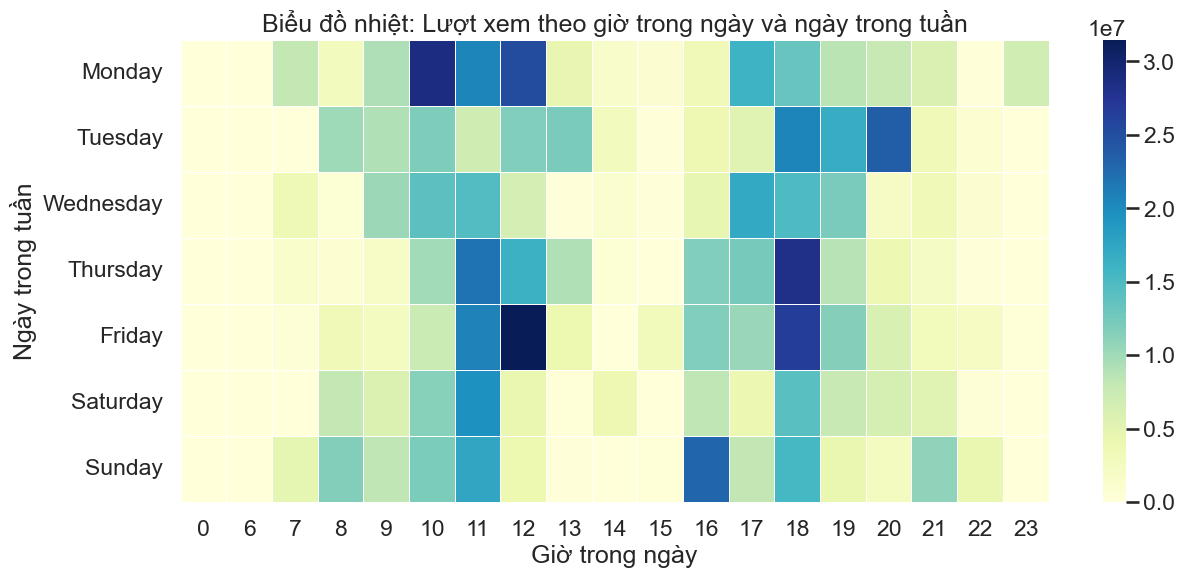

In [272]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
read_df['day_of_week'] = pd.Categorical(read_df['day_of_week'], categories=day_order, ordered=True)

start_date = pd.to_datetime(read_df['date'].min())
end_date = pd.Timestamp.now()
filtered_df = read_df[(read_df['date'] >= start_date) & (read_df['date'] <= end_date)]
heatmap_data = filtered_df.groupby(['day_of_week', 'hour'])['playCount'].sum().unstack()

plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data, cmap='YlGnBu', fmt='g', linewidths=0.5)
plt.title('Biểu đồ nhiệt: Lượt xem theo giờ trong ngày và ngày trong tuần')
plt.xlabel('Giờ trong ngày')
plt.ylabel('Ngày trong tuần')
plt.show()


**Biểu đồ này thể hiện sự phân bố lượt xem theo giờ trong ngày (trục ngang) và ngày trong tuần (trục dọc).**
- Theo các ngày trong tuần:
    + Lượt yêu thích tập trung cao vào đầu tuần đến giữa tuần (Từ Thứ Hai đến Thứ Sáu). -> Nội dung trong tuần được tác giả tập trung cao tiếp cận được nhiều người xem. 
- Theo giờ trong ngày:
    + Trong ngày thì lượt xem phân bố đều hơn. Lượt yêu thích cao nhất tại 2 khung giờ trong ngày là 10 giờ đến 12 giờ sáng và 17 giờ đến 19 giờ tối -> Đây là thời gian mọi người nghỉ hơn, giải trí sau những giờ làm việc căng thẳng -> tỉ lệ online cao hơn.
    + Lượt xem thường thấp vào buổi sáng sớm (0h - 6h) và sau 21 giờ tối, phản ánh thói quen sử dụng nền tảng của khán giả.

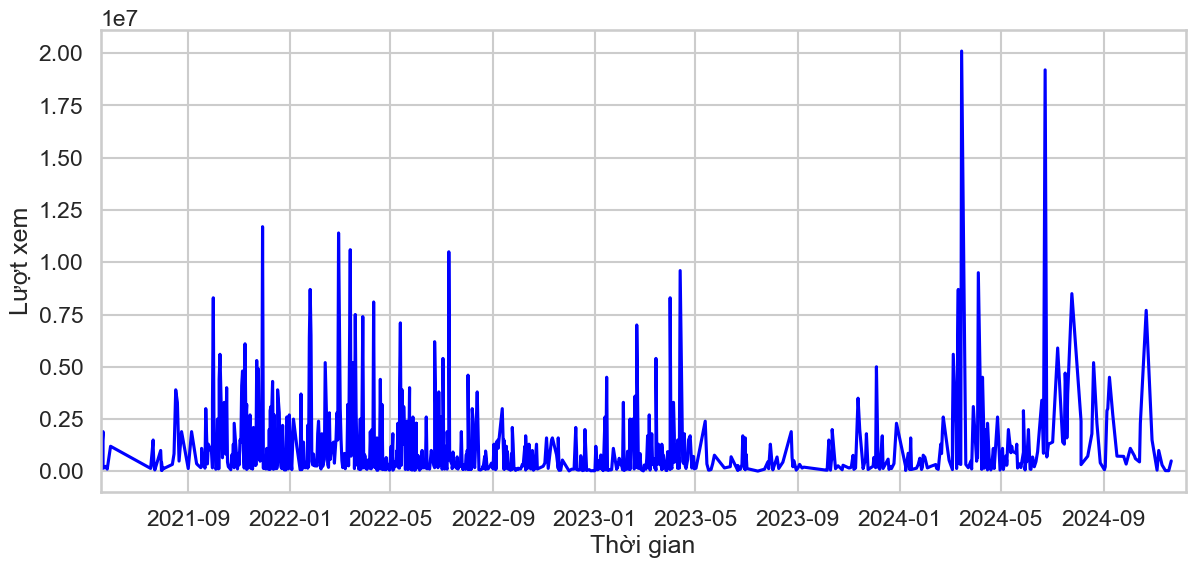

In [274]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(read_df['date'], read_df['playCount'], color='blue')
ax.set_xlabel('Thời gian')
ax.set_ylabel('Lượt xem')
ax.set_xlim(pd.to_datetime(read_df['date'].min()), pd.Timestamp.now())

plt.show()


- Ta có, tần suất đăng video theo từng năm là: Năm 2021 có 155 bài đăng, năm 2022 có 364 bài đăng, năm 2023 có 213 bài đăng, năm 2024 có 131 bài đăng, tần suất đăng bài ổn định -> lượt xem cũng khá ổn định


## 3. Phân tích sự tương quan giữa các yếu tố

### 3.1 Tương quan giữa commentCount, shareCount, diggCount, playCount và collectCount

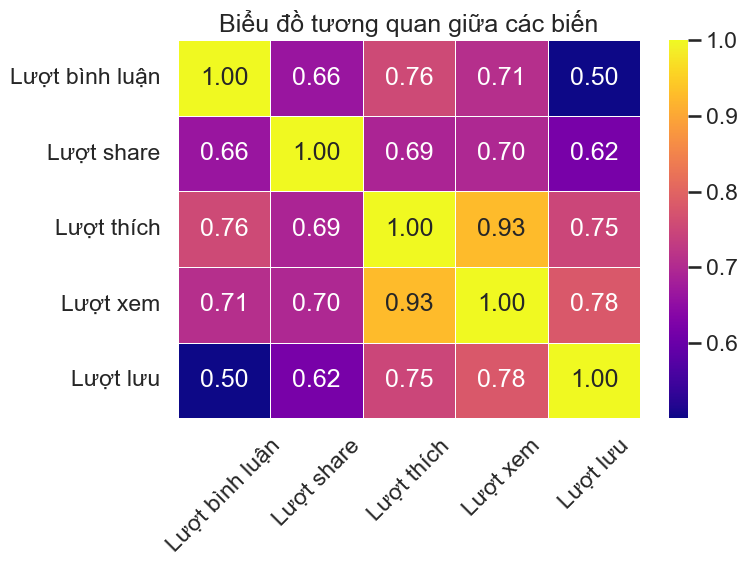

In [278]:
corr_row = read_df[['commentCount', 'shareCount', 'diggCount', 'playCount', 'collectCount']]
correlation_matrix = corr_row.corr()

# Tạo danh sách tên hiển thị
display_names = ['Lượt bình luận', 'Lượt share', 'Lượt thích', 'Lượt xem', 'Lượt lưu']

plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='plasma',
    fmt=".2f",
    linewidths=0.5,
    xticklabels=display_names,
    yticklabels=display_names
)
plt.xticks(rotation=45)
plt.title('Biểu đồ tương quan giữa các biến')
plt.tight_layout()  
plt.show()

Từ biểu đồ tương quan trên, ta dễ dàng nhận thấy các yếu tố về tương tác có sự liên hệ mật thiết với nhau:
- Lượt xem và lượt thích có độ tương quan cao nhất với: 0.93
- Lượt xem và lượt lưu: 0.78
- Lượt comment và lượt thích: 0.76
- Lượt lưu và lượt thích: 0.75
- Lượt xem và lượt lưu: 0.70
- Lượt thích và lượt chia sẻ: 0.69
- Lượt comment và lượt chia sẻ: 0.66
- lượt share và lượt lưu: 0.63
- Lượt bình luận và lượt lưu: 0.50

### 3.2 Phân tích mối tương quan giữa giờ đăng và tương tác

In [281]:
rate_of_reaction_by_hour = rate_reaction.groupby('hour')['ER'].mean().reset_index()
full_hours = pd.DataFrame({'hour': range(24)}) 
rate_of_reaction_by_hour = full_hours.merge(rate_of_reaction_by_hour, on='hour', how='left')
rate_of_reaction_by_hour['ER'] = rate_of_reaction_by_hour['ER'].fillna(0)  

rate_of_reaction_by_hour


,hour,ER
0,0,2.636564
1,1,0.000000
2,2,0.000000
3,3,0.000000
4,4,0.000000
5,5,0.000000
6,6,6.260000
7,7,7.727228
8,8,7.789815
9,9,7.366548


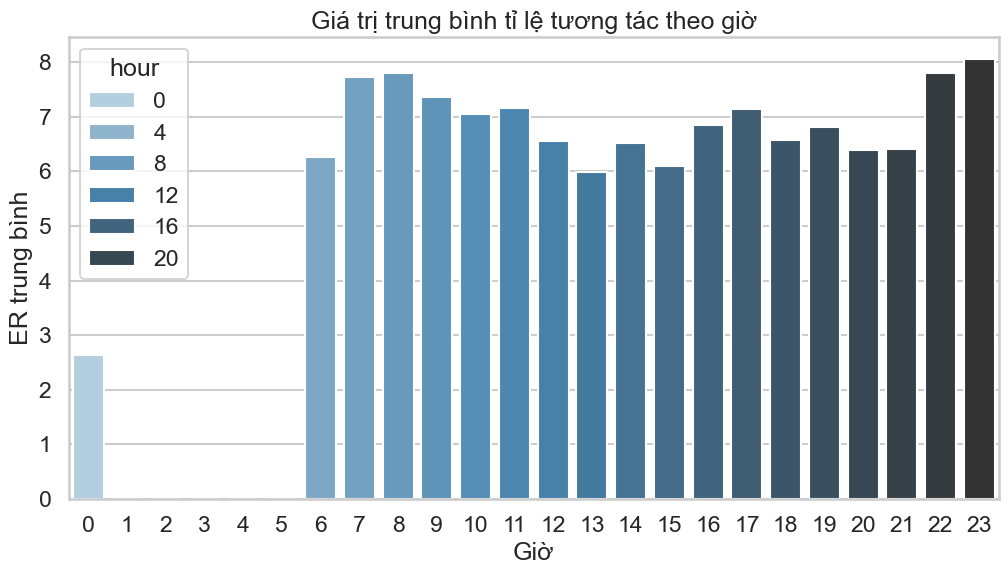

In [282]:
plt.figure(figsize=(12, 6))  
sns.barplot(data=rate_of_reaction_by_hour, x='hour', y='ER', hue='hour', palette='Blues_d')

plt.title('Giá trị trung bình tỉ lệ tương tác theo giờ')
plt.xlabel('Giờ')
plt.ylabel('ER trung bình')
plt.xticks(range(0, 24))  
plt.show()


Dựa vào biểu đồ trên ta thấy:
- Khung giờ 22-23 giờ: Đây là khung giờ có tỷ lệ tương tác cao nhất. Điều này có thể gợi ý rằng người dùng hoạt động tích cực vào buổi đêm, lúc mọi người nghỉ ngơi, giải trí sau một ngày dài làm việc. Bên cạnh đó khung giờ 7- 8h sáng cũng có lượt tương tác cao không kém.
- Buổi chiều và tối (13-23 giờ): Tỷ lệ tương tác duy trì ổn định nhưng không cao như khung giờ sáng.
- Nửa đêm đến sáng sớm (0-5 giờ): Tương tác thấp nhất, có thể do người dùng ít hoạt động trong khoảng thời gian này.


### 3.3 So sánh tương quan giữa thời lượng video và tỉ lệ tương tác

In [286]:
read_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863 entries, 0 to 862
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype                           
---  ------                 --------------  -----                           
 0   collectCount           863 non-null    int64                           
 1   commentCount           863 non-null    int64                           
 2   createTime             863 non-null    int64                           
 3   createTimeISO          863 non-null    datetime64[ns, Asia/Ho_Chi_Minh]
 4   diggCount              863 non-null    int64                           
 5   hashtags/0/name        835 non-null    object                          
 6   hashtags/1/name        813 non-null    object                          
 7   hashtags/2/name        674 non-null    object                          
 8   musicMeta/musicAuthor  863 non-null    object                          
 9   playCount              863 non-null    int6

In [287]:
vd = rate_reaction.copy()
vd['videoMeta/duration'] = read_df['videoMeta/duration']
vd

,collectCount,commentCount,createTime,createTimeISO,diggCount,hashtags/0/name,hashtags/1/name,hashtags/2/name,musicMeta/musicAuthor,playCount,...,hour,year,month,day,text_length,day_of_week,day_of_month,Date,ReactionCount,ER
0,1392,231,1732165470,2024-11-21 12:04:30+07:00,26900,dongmauviet,NaN,NaN,DÃ²ng MÃ¡u Viá»t,499600,...,12,2024,11,21,14,Thursday,21,2024-11-21,28822,5.490392
1,275,45,1731913011,2024-11-18 13:56:51+07:00,3128,dongmauviet,NaN,NaN,DÃ²ng MÃ¡u Viá»t,33600,...,13,2024,11,18,11,Monday,18,2024-11-18,3651,10.047619
2,184,34,1731554729,2024-11-14 10:25:29+07:00,3192,dongmauviet,NaN,NaN,DÃ²ng MÃ¡u Viá»t,36300,...,10,2024,11,14,11,Thursday,14,2024-11-14,3441,8.972452
3,691,226,1731216293,2024-11-10 12:24:53+07:00,17700,dongmauviet,NaN,NaN,DÃ²ng MÃ¡u Viá»t,305200,...,12,2024,11,10,13,Sunday,10,2024-11-10,18793,5.931193
4,1544,708,1730886398,2024-11-06 16:46:38+07:00,38300,dongmauviet,NaN,NaN,DÃ²ng MÃ¡u Viá»t,1000000,...,16,2024,11,6,9,Wednesday,6,2024-11-06,40916,3.937200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
858,641,2285,1621612142,2021-05-21 22:49:02+07:00,150200,dongmauviet,lichsuvietnam,vietnam,DÃ²ng MÃ¡u Viá»t,1300000,...,22,2021,5,21,26,Friday,21,2021-05-21,154190,11.811462
859,125,282,1621556153,2021-05-21 07:15:53+07:00,16200,dongmauviet,lichsuvietnam,vietnam,DÃ²ng MÃ¡u Viá»t,145000,...,7,2021,5,21,19,Friday,21,2021-05-21,16762,11.473793
860,407,1195,1621471433,2021-05-20 07:43:53+07:00,73700,dongmauviet,lichsuvietnam,vietnam,DÃ²ng MÃ¡u Viá»t,434800,...,7,2021,5,20,23,Thursday,20,2021-05-20,75595,17.292548
861,248,77,1621385927,2021-05-19 07:58:47+07:00,14000,dongmauviet,lichsuvietnam,vietnam,DÃ²ng MÃ¡u Viá»t,139000,...,7,2021,5,19,23,Wednesday,19,2021-05-19,14463,10.226619


In [288]:
top10 = vd.nlargest(10, 'ER')
top10[['videoMeta/duration', 'ER']]

,videoMeta/duration,ER
788,93,17.406996
860,68,17.292548
813,159,15.424242
620,49,14.770294
803,113,14.523152
845,79,14.449200
232,157,14.226866
792,71,14.045244
553,62,14.040165
819,99,13.876485


In [289]:
top10_ = vd.nsmallest(10,'ER')
top10_[['videoMeta/duration', 'ER']]

,videoMeta/duration,ER
358,51,1.400833
240,152,1.760740
99,58,1.886023
238,88,1.948647
152,42,2.188518
138,46,2.198706
127,50,2.244070
169,144,2.506273
844,82,2.636564
115,43,2.657005


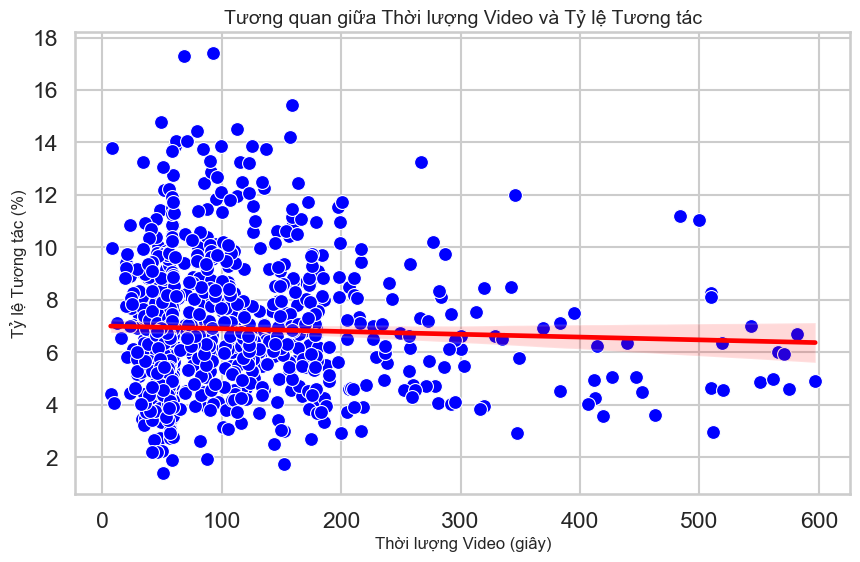

In [290]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=vd, x='videoMeta/duration', y='ER', color='blue', s=100)

sns.regplot(data=vd, x='videoMeta/duration', y='ER', scatter=False, color='red')
plt.title('Tương quan giữa Thời lượng Video và Tỷ lệ Tương tác', fontsize=14)
plt.xlabel('Thời lượng Video (giây)', fontsize=12)
plt.ylabel('Tỷ lệ Tương tác (%)', fontsize=12)
plt.grid(True)

plt.show()

**Dựa vào biểu đồ ta thấy**
- Đường xu hướng màu đỏ (trendline) biểu thị mối tương quan giữa thời lượng video và tỷ lệ tương tác. Đường này dốc xuống rất nhẹ, cho thấy có mối tương quan âm yếu giữa thời lượng video và tỷ lệ tương tác.
- Điều này có nghĩa là: Khi thời lượng video tăng, tỷ lệ tương tác có xu hướng giảm, nhưng mức giảm không lớn.

### 3.4 Phân tích mối tương quan giữa tần suất đăng bài và tỉ lệ tương tác

## 3.4.1 Tần suất đăng bài theo tuần và tỷ lệ tương tác

In [294]:
read_df['ER'] = ((read_df['diggCount'] + read_df['commentCount'] + read_df['shareCount']) / read_df['playCount']) * 100

# Tính số bài đăng mỗi tuần
weekly_posts = read_df.resample('W', on='Date').size()

weekly_er = read_df.resample('W', on='Date')['ER'].mean()
data_for_plot = pd.DataFrame({"Weekly Posts": weekly_posts, "Average ER": weekly_er}).reset_index()

In [295]:
data_for_plot

,Date,Weekly Posts,Average ER
0,2021-05-23,7,10.891084
1,2021-05-30,4,8.899762
2,2021-06-06,1,13.752917
3,2021-06-13,0,NaN
4,2021-06-20,0,NaN
...,...,...,...
179,2024-10-27,1,4.465532
180,2024-11-03,1,6.271267
181,2024-11-10,3,5.833054
182,2024-11-17,1,8.972452


**Loại biểu đồ: Scatter plot với đường hồi quy.**

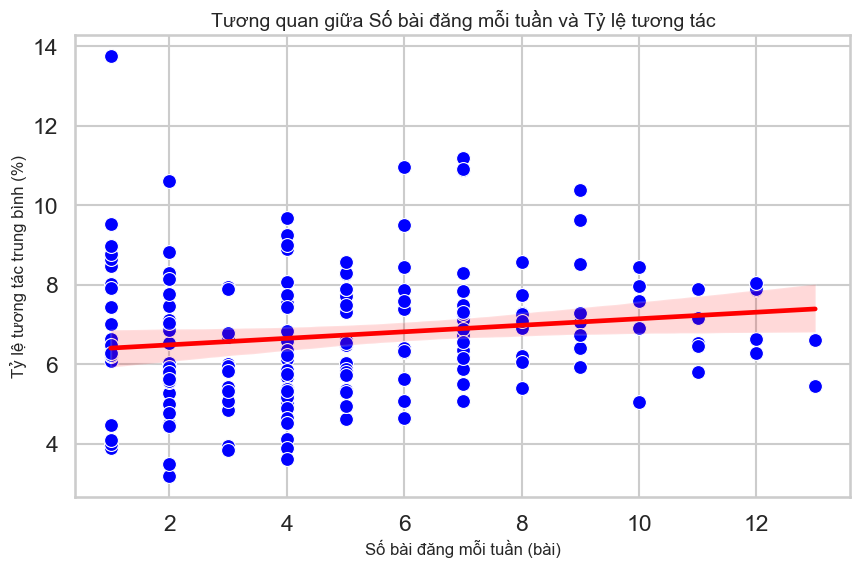

In [297]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_for_plot, x="Weekly Posts", y="Average ER", color='blue', s=100)
sns.regplot(data=data_for_plot, x="Weekly Posts", y="Average ER", scatter=False, color='red')

plt.title('Tương quan giữa Số bài đăng mỗi tuần và Tỷ lệ tương tác', fontsize=14)
plt.xlabel('Số bài đăng mỗi tuần (bài)', fontsize=12)  # Thêm đơn vị "(bài)"
plt.ylabel('Tỷ lệ tương tác trung bình (%)', fontsize=12)
plt.grid(True)

plt.show()

**Dựa vào biểu đồ trên ta thấy:**
- Các điểm dữ liệu khá rải rác, cho thấy mối tương quan không chặt chẽ giữa số bài đăng mỗi tuần và tỷ lệ tương tác trung bình.
- Đường hồi quy có độ dốc nhẹ, thể hiện mối tương quan dương rất yếu. Điều này gợi ý rằng việc tăng số bài đăng không làm tăng đáng kể tỷ lệ tương tác.
- Hầu hết tỷ lệ tương tác phân bố nhiều từ 6% - 8%. Ngoài ra, có một vài điểm nổi bật tương tác cao lên đến tận 14%.

**Loại biểu đồ: Heatmap.**

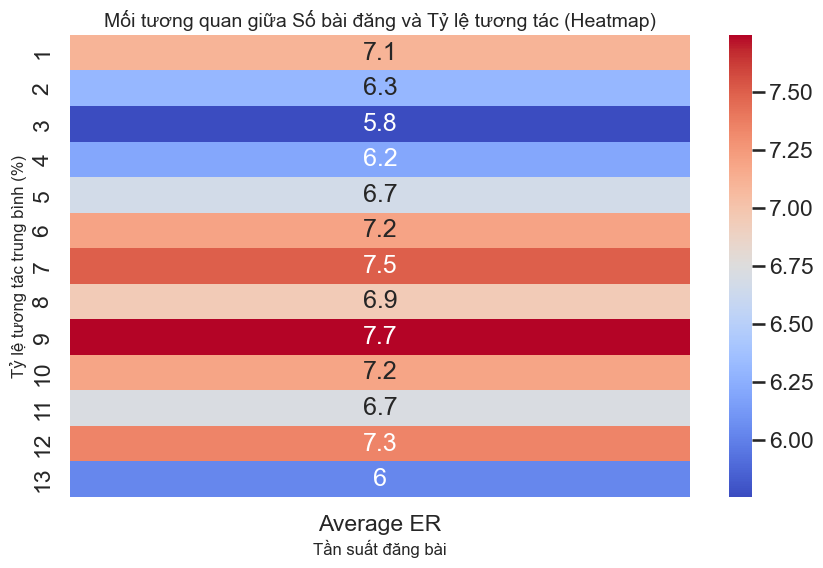

In [300]:
plt.figure(figsize=(10, 6))
heatmap_data = data_for_plot.pivot_table(index="Weekly Posts", values="Average ER", aggfunc="mean")
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", cbar=True)

plt.title("Mối tương quan giữa Số bài đăng và Tỷ lệ tương tác (Heatmap)", fontsize=14)
plt.xlabel("Tần suất đăng bài", fontsize=12)
plt.ylabel("Tỷ lệ tương tác trung bình (%)", fontsize=12)
plt.show()


Dựa vào biểu đồ trên ta thấy:
- Số bài đăng từ 6 đến 10 bài mỗi tuần có xu hướng đạt tỷ lệ tương tác cao hơn trung bình trên 7.2%. Đạt đỉnh ở 7 và 9 bài (7.5% và 7.7%).
- Khi đăng từ 2 đến 4 bài mỗi tuần tỷ lệ tương tác giảm rõ rệt chỉ từ 5.8-6.3%. Ngoài ra, số bài đăng quá nhiều từ 11 đến 13 bài mỗi tuần thì hiệu quả tương tác lại giảm, có thể do người dùng cảm thấy "bội thực nội dung".


**Kết luận**
  - Nên duy trì trong khoảng 6-10 bài mỗi tuần để đạt hiệu quả tương tác cao nhất. Đăng quá nhiều hoặc quá ít có thể gây giảm hiệu suất tương tác.
  -> Biểu đồ này cho thấy rằng số lượng bài đăng hợp lý cần được cân đối với chất lượng nội dung để đạt hiệu quả tương tác tốt nhất.

C:\Users\DELL\AppData\Local\Temp\ipykernel_15472\900873620.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data_for_plot, x="Weekly Posts", y="Average ER", palette="Set2")


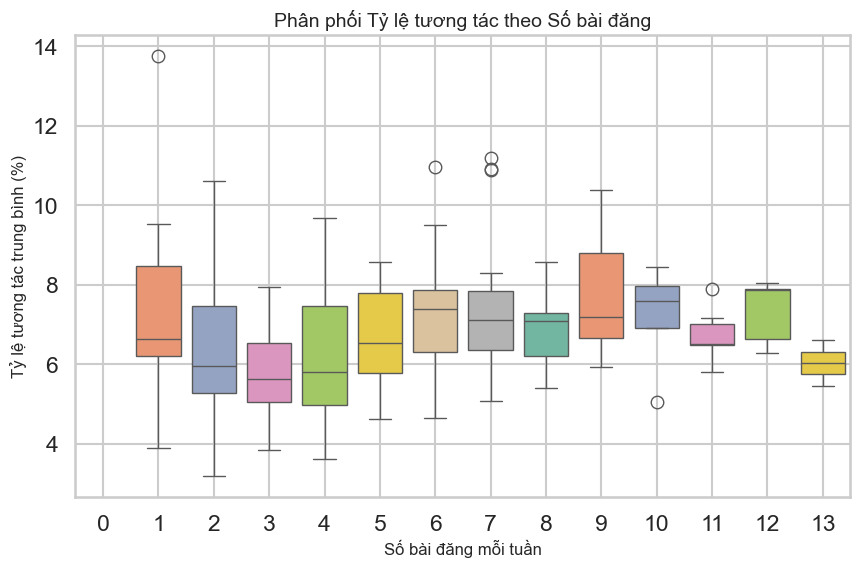

In [302]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=data_for_plot, x="Weekly Posts", y="Average ER", palette="Set2")

plt.title("Phân phối Tỷ lệ tương tác theo Số bài đăng", fontsize=14)
plt.xlabel("Số bài đăng mỗi tuần", fontsize=12)
plt.ylabel("Tỷ lệ tương tác trung bình (%)", fontsize=12)
plt.grid(True)
plt.show()


## 3.4.2 Tần suất đăng bài theo tháng và tỷ lệ tương tác

In [304]:
# Tính số bài đăng mỗi tháng
monthly_posts = read_df.resample('ME', on='Date').size()

# Tính tỷ lệ tương tác trung bình mỗi tháng
monthly_er = read_df.resample('ME', on='Date')['ER'].mean()

data_for_month_plot = pd.DataFrame({"Monthly Posts": monthly_posts, "Average ER": monthly_er}).reset_index()
data_for_month_plot

,Date,Monthly Posts,Average ER
0,2021-05-31,12,10.465796
1,2021-06-30,0,NaN
2,2021-07-31,8,7.905458
3,2021-08-31,9,6.160733
4,2021-09-30,17,8.191505
5,2021-10-31,28,10.107357
6,2021-11-30,36,7.984912
7,2021-12-31,45,7.950961
8,2022-01-31,26,7.185037
9,2022-02-28,20,7.947749


**Loại biểu đồ: Scatter plot với đường hồi quy.**

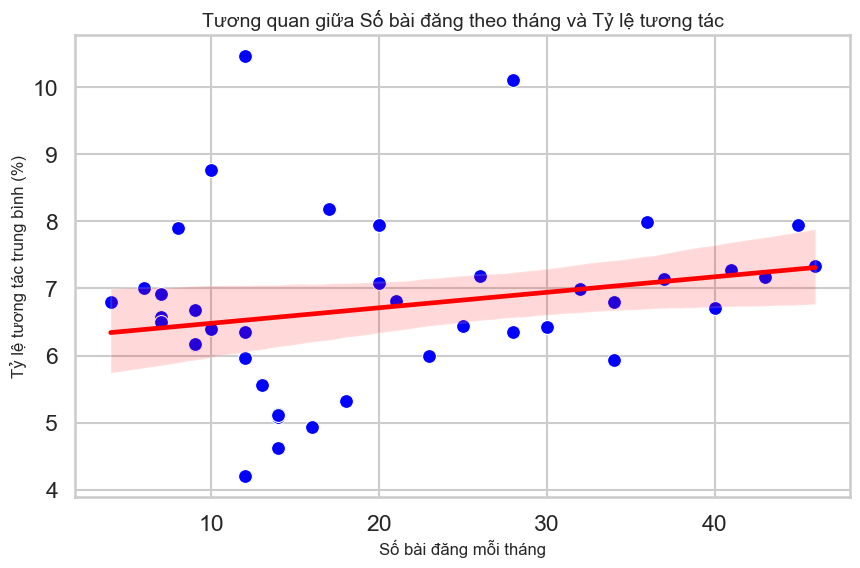

In [306]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_for_month_plot, x="Monthly Posts", y="Average ER", color='blue', s=100)
sns.regplot(data=data_for_month_plot, x="Monthly Posts", y="Average ER", scatter=False, color='red')

plt.title("Tương quan giữa Số bài đăng theo tháng và Tỷ lệ tương tác", fontsize=14)
plt.xlabel("Số bài đăng mỗi tháng", fontsize=12)
plt.ylabel("Tỷ lệ tương tác trung bình (%)", fontsize=12)
plt.grid(True)

plt.show()


- Đường hồi quy có độ dốc nhẹ, thể hiện mối tương quan dương rất yếu.
- Mặc dù có vẻ như tỷ lệ tương tác tăng lên khi số lượng bài đăng mỗi tháng tăng, mức độ tương quan không quá mạnh. Điều này có thể cho thấy rằng có các yếu tố khác ảnh hưởng đến tỷ lệ tương tác như chất lượng video hoặc nội dung, không chỉ riêng số lượng bài đăng.

**Loại biểu đồ: Heatmap.**

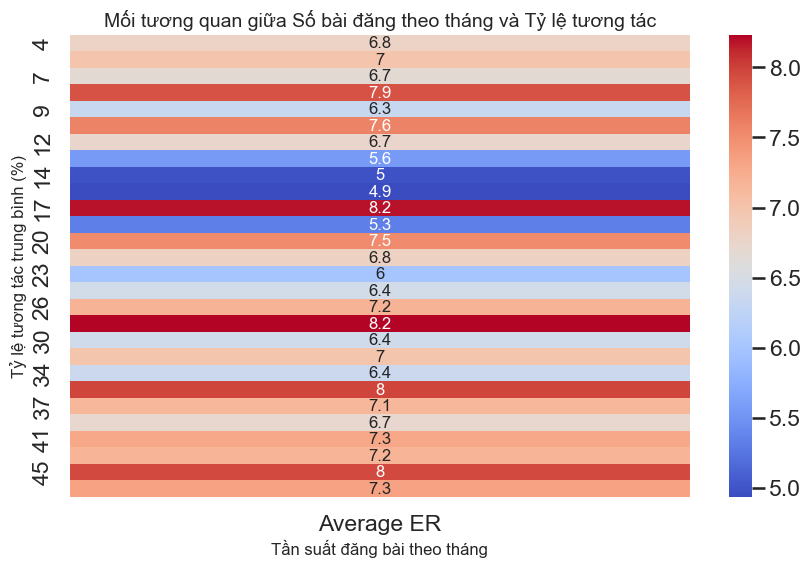

In [309]:
plt.figure(figsize=(10, 6))
heatmap_data_month = data_for_month_plot.pivot_table(index="Monthly Posts", values="Average ER", aggfunc="mean")
sns.heatmap(heatmap_data_month, annot=True, cmap="coolwarm", cbar=True, annot_kws={"size": 12})  # Thêm annot_kws để giảm kích thước chữ

plt.title("Mối tương quan giữa Số bài đăng theo tháng và Tỷ lệ tương tác", fontsize=14)
plt.xlabel("Tần suất đăng bài theo tháng", fontsize=12)
plt.ylabel("Tỷ lệ tương tác trung bình (%)", fontsize=12)
plt.show()



**Loại biểu đồ: Pair Plot.**

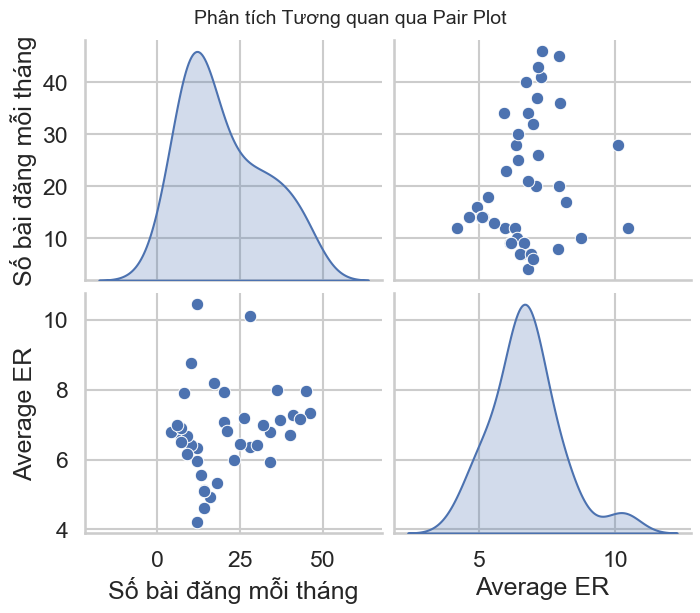

In [311]:
data_for_month_plot_vn = data_for_month_plot.rename(
    columns={"Monthly Posts": "Số bài đăng mỗi tháng"}
)
sns.pairplot(data=data_for_month_plot_vn, diag_kind='kde', height=3, aspect=1.2)
plt.suptitle("Phân tích Tương quan qua Pair Plot", y=1.02, fontsize=14)
plt.show()


### 3.5 So sánh tỷ lệ tương tác giữa bài đăng có title và không có title

In [313]:
# Tách cột title từ cột text bỏ hastag 
read_df['title'] = read_df['text'].apply(
    lambda x: re.match(r'^(.*?)(?:\s*#|$)', x).group(1).strip() if isinstance(x, str) else x
)

# Tính lượt tỷ lệ tương tác
read_df['ER'] = ((read_df['diggCount'] + read_df['commentCount'] + read_df['shareCount']) / read_df['playCount']) * 100

# Tách các bài đăng có title và không có title
df_with_title = read_df[read_df['title'] != '']
df_without_title = read_df[read_df['title'] == '']

# Tính ER trung bình của từng nhóm
er_with_title = df_with_title['ER'].mean()
er_without_title = df_without_title['ER'].mean()

print("Tỷ lệ tương tác của bài đăng có title: ",er_with_title)
print("Tỷ lệ tương tác của bài đăng không title: ",er_without_title)

Tỷ lệ tương tác của bài đăng có title:  6.179943267793272
Tỷ lệ tương tác của bài đăng không title:  7.1655807420728355


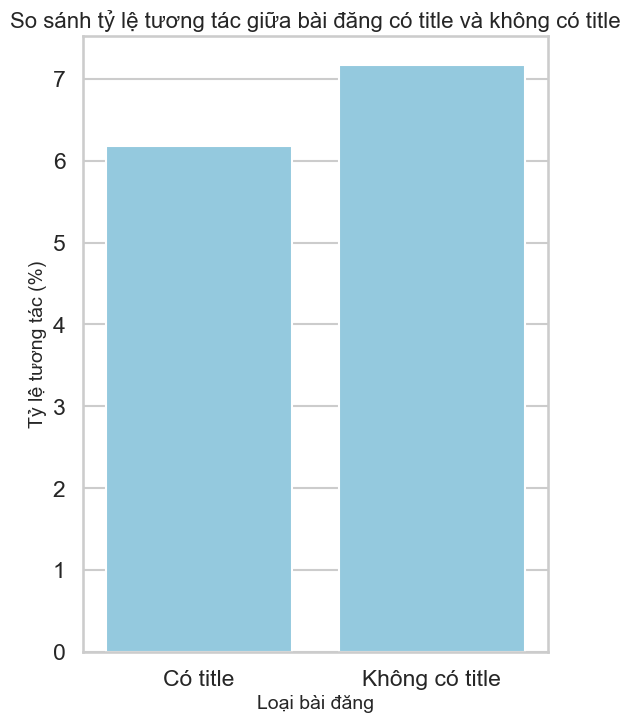

In [314]:
plt.figure(figsize=(6, 8))
sns.barplot(x=['Có title', 'Không có title'], y=[er_with_title, er_without_title], color='skyblue')

plt.xlabel('Loại bài đăng', fontsize=14)
plt.ylabel('Tỷ lệ tương tác (%)', fontsize=14)
plt.title('So sánh tỷ lệ tương tác giữa bài đăng có title và không có title', fontsize=16)
plt.show()

- Dựa vào biểu đồ ta thấy tỉ lệ tương tác của bài đăng có title và không có title đều có tỉ lệ tương tác khá cao (trên 6%)
- Sự chênh lệch của 2 loại bài đăng này không cao -> Có title hay không có title không ảnh hưởng quá nhiều đến lượt tương tác. Nguyên nhân là do nick Tiktok này thường dùng video có lời nói để kể những câu chuyện về con người và lịch sử Việt Nam nên nội dung người để trên video như tiêu đề của 1 đoạn phim ngắn luôn.

### 3.6 Từ phổ biến trong bài đăng

- Tách title từ caption bỏ hastag

In [318]:
print(read_df[['title']])

                                                 title
0              4 Vị Tướng Cúi Đầu Trước 1 Vị Trung Tá.
1                Lịch Sử Ngày Nhà Giáo Việt Nam 20/11.
2                    Chiếc Mũ Huyền Thoại Của Ông Cha.
3                         Mẹ Thứ, Hơn Cả Sự Vĩ Đại ...
4                                Phép Màu Việt Nam ...
..                                                 ...
858  Mọi người vào kênh youtube : dòng máu Việt để ...
859  Xin mọi người 1 bình luận để kênh lấy lại tươn...
860  Xin mỗi người 1 chấm vào bình luận để kênh lấy...
861  Mọi người cho mình xin 1 chấm vào bình luận để...
862  dòng máu Việt - trở lạiXin 1 chấm vào phần bìn...

[863 rows x 1 columns]


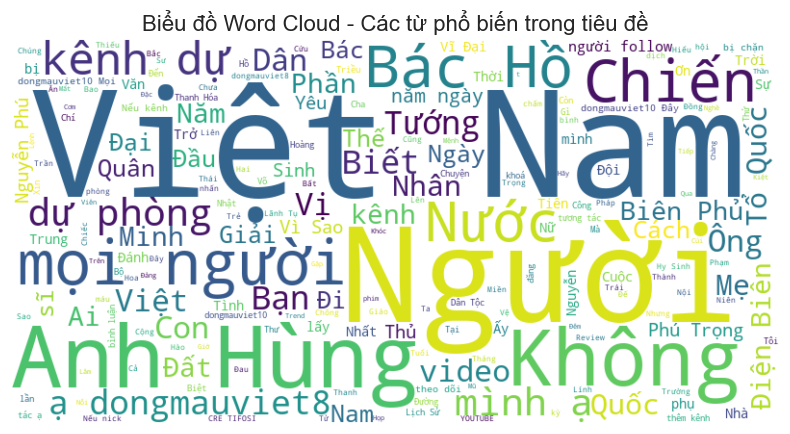

In [319]:
from wordcloud import WordCloud, STOPWORDS

text_data = " ".join(read_df['title'].dropna())  # Ghép tất cả các tiêu đề thành một chuỗi lớn

# Danh sách từ dừng tiếng Việt
vietnamese_stopwords = {"là", "và", "của", "một", "những", "có", "được", "trong", "với", 
                        "này", "các", "cho", "để", "khi", "đã", "từ", "ra", "vào", "sẽ", 
                        "thì", "như", "về", "lại", "nhiều", "đó", "nên", "hơn", "nữa", "ở", "nơi"}
# Mở rộng từ dừng WordCloud với từ dừng tiếng Việt
stopwords = STOPWORDS.union(vietnamese_stopwords)

# Tạo WordCloud với font hỗ trợ tiếng Việt
wordcloud = WordCloud(width=800, height=400, background_color="white", 
                      colormap="viridis", stopwords=stopwords).generate(text_data)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Biểu đồ Word Cloud - Các từ phổ biến trong tiêu đề", fontsize=16)
plt.show()

Các từ nổi bật như "Người", "Việt Nam", "Anh Hùng", "Chiến Tranh", "Tổ Quốc", "Bác Hồ" cho thấy nội dung tài khoản này tập trung vào lịch sử, tinh thần dân tộc và các câu chuyện liên quan đến lịch sử Việt Nam.

## 4. Xây dựng mô hình dự đoán dựa trên PCA, học máy

Xây dựng mô hình dự đoán lượt share dựa trên lượt xem, comment, like

In [323]:
from sklearn.model_selection import train_test_split
train,test,train_label,test_label=train_test_split(read_df[['playCount','shareCount','commentCount']],read_df['diggCount'],test_size=0.33,random_state=30)

from sklearn.linear_model import LinearRegression
reg=LinearRegression(fit_intercept=True)
model = reg.fit(train,train_label)
predict = model.predict(test)

from sklearn.metrics import r2_score
print(r2_score(test_label,predict))

0.8115914729902837


In [ ]:
play_count_input = float(input("Nhập lượt xem (playCount): "))
share_count_input = float(input("Nhập lượt chia sẻ (shareCount): "))
comment_count_input = float(input("Nhập lượt comment (commentCount): "))

# Tạo DataFrame từ đầu vào người dùng với tên cột giống như dữ liệu huấn luyện
user_input = pd.DataFrame([[play_count_input, share_count_input, comment_count_input]], columns=['playCount', 'shareCount', 'commentCount'])

# Dự đoán lượt thích (diggCount) từ các giá trị người dùng nhập
prediction = model.predict(user_input)

# Hiển thị kết quả dự đoán
print(f"Dự đoán lượt thích (diggCount): {prediction[0]}")

# II. Phân tích và so sánh với tài khoản 'Công Ken'

## Phần 1: Xử lý dữ liệu (Data Cleaning)

In [ ]:
read_df2 = pd.read_csv('Data/Dataset_ntcong5.csv',  encoding='ISO-8859-1')

In [ ]:
read_df2.info()

In [ ]:
# Tiếp tục với quá trình xử lý dữ liệu, chúng ta sẽ xóa đi những cột có giá trị null hoàn toàn 
read_df2 = read_df2.dropna(axis='columns', how='all')

In [ ]:
read_df2

In [ ]:
# Tính tỷ lệ giá trị null cho mỗi cột
Null_Percentage2 = read_df2.isnull().mean()

# Lấy các cột có tỷ lệ giá trị null lớn hơn 99%
Null_more_ninety2 = Null_Percentage2[Null_Percentage2 > 0.99].index

# Xóa các cột có tỷ lệ giá trị null lớn hơn 99%
read_df2 = read_df2.drop(columns=Null_more_ninety2)

Null_Percentage[(Null_Percentage > 0.5) & (Null_Percentage < 0.99)].index

In [ ]:
coloumns_drop_many22 = ['detailedMentions/0/id', 'detailedMentions/0/name',
       'detailedMentions/0/nickName', 'detailedMentions/0/postUrl',
       'detailedMentions/0/profileUrl', 'hashtags/4/name', 'hashtags/5/name',
       'hashtags/6/name', 'mentions/0', 'musicMeta/musicAlbum',
       'videoMeta/subtitleLinks/0/downloadLink',
       'videoMeta/subtitleLinks/0/language',
       'videoMeta/subtitleLinks/0/tiktokLink']

read_df2 = read_df2.drop(columns=coloumns_drop_many22)

In [ ]:
read_df2.info()

In [ ]:
read_df2["ï»¿authorMeta/avatar"].dropna().head(200)
#Dữ liệu dẫn đến link avatar của chủ sở hữu
# => Xóa
read_df2 = read_df2.drop(columns="ï»¿authorMeta/avatar")

read_df2["authorMeta/commerceUserInfo/commerceUser"].dropna().head(200)
#Dữ liệu chỉ toàn giá trị False
# => Xóa vì không có giá trị phân tích
read_df2 = read_df2.drop(columns="authorMeta/commerceUserInfo/commerceUser")

read_df2["authorMeta/digg"].dropna().head(200)
#Dữ liệu chỉ toàn giá trị 0
# => Xóa vì không có giá trị phân tích
read_df2 = read_df2.drop(columns="authorMeta/digg")

#Loại bỏ các cột có dữ liệu bất biến
for col in read_df2.columns:
    if read_df2[col].nunique() == 1:
        read_df2 = read_df2.drop(columns=col)
coloumns_drop_many3 = ['musicMeta/coverMediumUrl','musicMeta/musicId',
                      'musicMeta/musicName','musicMeta/originalCoverMediumUrl','musicMeta/playUrl']
#Tương tự với các cột có dữ liệu không thể phân tích được của tag musicMeta
read_df2 = read_df2.drop(columns=coloumns_drop_many3)
coloumns_drop_many4 = ['videoMeta/coverUrl',
                      'videoMeta/height','videoMeta/originalCoverUrl','videoMeta/width']
#Tương tự với các cột có dữ liệu không thể phân tích được của tag videoMeta
read_df2 = read_df2.drop(columns=coloumns_drop_many4)

read_df2["id"].dropna().head(200)
#Dữ liệu là các con số
# => Xóa vì không có giá trị phân tích
read_df2 = read_df2.drop(columns="id")

read_df2["webVideoUrl"].dropna().head(200)
#Dữ liệu là các con số
# => Xóa vì không có giá trị phân tích
read_df2 = read_df2.drop(columns="webVideoUrl")




In [ ]:
from datetime import datetime
from dateutil import parser
import pytz

vietnam_tz = pytz.timezone("Asia/Ho_Chi_Minh")

read_df2['createTimeISO'] = read_df2['createTimeISO'].astype(str)
read_df2['createTimeISO'] = read_df2['createTimeISO'].apply(
    lambda x: parser.isoparse(x).astimezone(vietnam_tz)
)
read_df2['createTimeISO'] = read_df2['createTimeISO'].astype(str)

read_df2['createTimeISO'] = read_df2['createTimeISO'].apply(
    lambda x: datetime.fromisoformat(x).astimezone(vietnam_tz)
)
read_df2['date'] = read_df2['createTimeISO'].apply(lambda x: x.date())  # Chỉ lấy ngày
read_df2['hour'] = read_df2['createTimeISO'].apply(lambda x: x.hour)   # Chỉ lấy giờ
read_df2['year'] = read_df2['date'].apply(lambda x: x.year)
read_df2['month'] = read_df2['date'].apply(lambda x: x.month)
read_df2['day'] = read_df2['date'].apply(lambda x: x.day)
read_df2.drop(columns=['createTimeISO', 'date'], inplace=True)


In [ ]:
read_df2 = read_df2.drop(columns="isSlideshow")
read_df2

**Vậy dữ liệu còn lại 15 cột giá trị để phân tích và so sánh**

In [ ]:
read_df2['text']=read_df2['text'].astype(str)
read_df2['text_length']=read_df2['text'].apply(lambda x: len(list(x.split(" "))))

In [ ]:
read_df2['text']= read_df2['text'].apply(lambda x: x.encode('latin1').decode('utf-8'))
read_df2['text'].dropna().head(200)

## Phần 2: Phân tích và so sánh dữ liệu

### 2.1 So sánh tần suất đăng bài của nick Dòng Máu Việt và Công Ken

In [ ]:
read_df2['date'] = pd.to_datetime(read_df2[['year', 'month', 'day']])

# Chuyển 'date' thành kiểu datetime
read_df['date'] = pd.to_datetime(read_df['date'])
read_df2['date'] = pd.to_datetime(read_df2['date'])

monthly_posts1 = read_df.resample('ME', on='date').size()
monthly_posts2 = read_df2.resample('ME', on='date').size()

mean_posts1 = monthly_posts1.mean()
mean_posts2 = monthly_posts2.mean()

print(f"Dòng Máu Việt - Trung bình bài đăng/tháng: {mean_posts1:.2f}")
print(f"Công Ken - Trung bình bài đăng/tháng: {mean_posts2:.2f}")

In [ ]:
plt.figure(figsize=(12, 6))  
# Dòng Máu Việt
plt.plot(
    monthly_posts1.index,
    monthly_posts1.values,
    label='Dòng Máu Việt',
    color='blue'
)

# Công Ken
plt.plot(
    monthly_posts2.index,
    monthly_posts2.values,
    label='Công Ken',
    color='red'
)
plt.title('So sánh tần suất đăng bài theo tháng', fontsize=16)
plt.xlabel('Tháng', fontsize=12)
plt.ylabel('Số lượng bài đăng', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Hiện mỗi tháng
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Tháng + năm
plt.xticks(rotation=45, fontsize=10)

plt.tight_layout()
plt.show()

Theo biểu đồ ta nhận thấy, Tần suất đăng bài của Dòng Máu Việt ổn định vào cao hơn Công Ken.

### 2.2 So sánh mức độ tương tác của 2 tài khoản

In [ ]:
comparison_reaction = pd.DataFrame()

comparison_reaction[''] = ['Lượt thích', 'Lượt comment', 'Lượt share']
comparison_reaction['Dòng Máu Việt'] = [read_df['diggCount'].mean(), read_df['commentCount'].mean(), read_df['shareCount'].mean()]
comparison_reaction['Công Ken'] = [read_df2['diggCount'].mean(), read_df2['commentCount'].mean(), read_df2['shareCount'].mean()]

comparison_reaction


In [ ]:
mean_values_df1 = {
    'diggCount': read_df['diggCount'].mean(),
    'commentCount': read_df['commentCount'].mean(),
    'shareCount': read_df['shareCount'].mean()
}

mean_values_df2 = {
    'diggCount': read_df2['diggCount'].mean(),
    'commentCount': read_df2['commentCount'].mean(),
    'shareCount': read_df2['shareCount'].mean()
}

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

metrics = ['diggCount', 'commentCount', 'shareCount']
titles = ['DiggCount', 'CommentCount', 'ShareCount']
colors = ['blue', 'orange']

for i, metric in enumerate(metrics):
    axs[i].bar(['Dòng Máu Việt', 'Công Ken'], [mean_values_df1[metric], mean_values_df2[metric]], color=colors)
    axs[i].set_title(f'{titles[i]}')
    axs[i].set_ylabel('Mức độ tương tác trung bình')

plt.tight_layout()
plt.show()

Nhìn chung, dù cho số lượng followers gần bằng nhau nhưng độ tương tác của Công Ken luôn cao hơn hẳn Dòng Máu Việt, chứng tỏ độ thu hút của kênh Tik tok về chủ đề giải trí hiện đại vẫn đạt lượng quan tâm cao hơn

### 2.3 So sánh hastag và từ ngữ phổ biến

## 2.3.1 So sánh hastag của 2 nick

In [ ]:
import pandas as pd

# Tách và làm sạch các cột hashtag trong read_df, loại bỏ NaN
hashtags_df1 = pd.concat([read_df['hashtags/0/name'].dropna(), 
                          read_df['hashtags/1/name'].dropna(), 
                          read_df['hashtags/2/name'].dropna()], ignore_index=True)

# Tách và làm sạch các cột hashtag trong read_df2, loại bỏ NaN
hashtags_df2 = pd.concat([read_df2['hashtags/0/name'].dropna(), 
                          read_df2['hashtags/1/name'].dropna(), 
                          read_df2['hashtags/2/name'].dropna(), 
                          read_df2['hashtags/3/name'].dropna()], ignore_index=True)

hashtags_count1 = hashtags_df1.value_counts()
hashtags_count2 = hashtags_df2.value_counts()

# Hashtag chung 
common_hashtags = hashtags_count1.index.intersection(hashtags_count2.index)

# Hashtag chỉ có trong read_df
unique_hashtags1 = hashtags_count1[~hashtags_count1.index.isin(hashtags_count2.index)]

# Hashtag chỉ có trong read_df2 
unique_hashtags2 = hashtags_count2[~hashtags_count2.index.isin(hashtags_count1.index)]

hashtags_info = {
    'Hashtag': [],
    'Dòng máu Việt': [],  
    'Công Ken': [] 
}

# Hashtag chung
for hashtag in common_hashtags:
    hashtags_info['Hashtag'].append(hashtag)
    hashtags_info['Dòng máu Việt'].append(hashtags_count1[hashtag])
    hashtags_info['Công Ken'].append(hashtags_count2[hashtag])

for hashtag, count in unique_hashtags1.items():
    hashtags_info['Hashtag'].append(hashtag)
    hashtags_info['Dòng máu Việt'].append(count)
    hashtags_info['Công Ken'].append(0)

for hashtag, count in unique_hashtags2.items():
    hashtags_info['Hashtag'].append(hashtag)
    hashtags_info['Dòng máu Việt'].append(0)
    hashtags_info['Công Ken'].append(count)

hashtags_df = pd.DataFrame(hashtags_info)

hashtags_df


In [ ]:
unique_hashtags_nick1 = hashtags_df1.nunique()  
unique_hashtags_nick2 = hashtags_df2.nunique()

print("Số lượng hashtag khác nhau của nick Dòng Máu Việt: ", unique_hashtags_nick1)
print("Số lượng hashtag khác nhau của nick Công Ken: ", unique_hashtags_nick2)


- Vì tỉ lệ tương tác của nick Công Ken cao hơn Dòng Máu Việt, tần suất đăng bài của Công Ken ít hơn. Nên ta có thể thấy sự đa dạng trong hastag có thể làm tăng tỉ lệ tương tác và tỉ lệ tiếp cận người xem cao hơn

## 2.3.2 So sánh từ ngữ phổ biến của 2 nick

*Tách title từ cột text bỏ hastag*

In [ ]:
read_df2['title'] = read_df2['text'].apply(
    lambda x: re.match(r'^(.*?)(?:\s*#|$)', x).group(1).strip() if isinstance(x, str) else x
)

print(read_df2[['title']])


In [ ]:
from wordcloud import WordCloud, STOPWORDS

text_data = " ".join(read_df2['title'].dropna())  # Ghép tất cả các tiêu đề lại thành một chuỗi lớn

# Danh sách từ dừng tiếng Việt
vietnamese_stopwords = {"là", "và", "của", "một", "những", "có", "được", "trong", "với", 
                        "này", "các", "cho", "để", "khi", "đã", "từ", "ra", "vào", "sẽ", 
                        "thì", "như", "về", "lại", "nhiều", "đó", "nên", "hơn", "nữa", "ở", "nơi"}

stopwords = STOPWORDS.union(vietnamese_stopwords)

wordcloud = WordCloud(width=800, height=400, background_color="white", 
                      colormap="viridis", stopwords=stopwords).generate(text_data)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Biểu đồ Word Cloud - Các từ phổ biến trong tiêu đề", fontsize=16)
plt.show()

**Phân tích và so sánh các từ phổ biến của 2 nick tiktok (Dòng Máu Việt và Công Ken)**
- Dòng Máu Việt: Các từ nổi bật như "Người", "Việt Nam", "Anh Hùng", "Chiến Tranh", "Tổ Quốc", "Bác Hồ" cho thấy nội dung tài khoản này tập trung vào lịch sử, tinh thần dân tộc và các câu chuyện liên quan đến lịch sử Việt Nam.
- Công Ken: Các từ như "Không", "Ko", "Quá", "Đi", "Vui", "Buồn", "Cười", "Xem" nó thể hiện sự giao tiếp giản dị, nhanh chóng và dễ tiếp cận. Ngoài ra, còn thường xuyên xuất hiện các từ ngữ giao tiếp đời sống thường ngày và cảm xúc như "Mình", "Nhé", "Ai", "Lâu", "Thấy". Những từ này giúp tạo sự kết nối với cộng đồng, thể hiện cảm xúc cá nhân, đồng thời khuyến khích sự tham gia và tương tác từ người xem. 

### 2.4 So sánh thời lượng video giữa 2 tài khoản

In [ ]:
video_duration_comparison = pd.DataFrame()
video_duration_comparison[''] = ['Trung bình', 'Phương sai', 'Độ lệch chuẩn', 'Thời lượng video dài nhất', 'Thời lượng video ngắn nhất']
video_duration_comparison['Dòng Máu Việt'] = [read_df['videoMeta/duration'].mean(), read_df['videoMeta/duration'].var(), read_df['videoMeta/duration'].std(), read_df['videoMeta/duration'].max(), read_df['videoMeta/duration'].min()]
video_duration_comparison['Công Ken'] = [read_df2['videoMeta/duration'].mean(), read_df2['videoMeta/duration'].var(), read_df2['videoMeta/duration'].std(), read_df2['videoMeta/duration'].max(), read_df2['videoMeta/duration'].min()]
video_duration_comparison

In [ ]:
Median_df1 = read_df['videoMeta/duration'].median()  
Mean_df1 = read_df['videoMeta/duration'].mean()   
Median_df2 = read_df2['videoMeta/duration'].median()  
Mean_df2 = read_df2['videoMeta/duration'].mean()     

plt.figure(figsize=(18, 8))
sns.set_theme(style="whitegrid", context="talk")


plt.subplot(1, 2, 1)
sns.stripplot(
    data=read_df,
    x="videoMeta/duration",
    color="orange",
    jitter=0.25,
    size=6,
    alpha=0.8
)

plt.axvline(Median_df1, color='blue', linestyle='--', label=f'Trung vị: {Median_df1:.1f}s', linewidth=2)
plt.axvline(Mean_df1, color='red', linestyle='-', label=f'Trung bình: {Mean_df1:.1f}s', linewidth=2)
plt.title("Phân bố độ dài video (Dòng Máu Việt)", fontsize=18, fontweight='bold', pad=20)
plt.xlabel("Thời lượng video (giây)", fontsize=14, labelpad=10)
plt.ylabel("Tần suất", fontsize=14, labelpad=10)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12)
plt.xlim(10, 180)
plt.legend(fontsize=12, loc='upper right')
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Biểu đồ 2: Phân bố độ dài video cho read_df2
plt.subplot(1, 2, 2)
sns.stripplot(
    data=read_df2,
    x="videoMeta/duration",
    color="green",
    jitter=0.25,
    size=6,
    alpha=0.8
)

plt.axvline(Median_df2, color='blue', linestyle='--', label=f'Trung vị: {Median_df2:.1f}s', linewidth=2)
plt.axvline(Mean_df2, color='red', linestyle='-', label=f'Trung bình: {Mean_df2:.1f}s', linewidth=2)
plt.title("Phân bố độ dài video (Công Ken)", fontsize=18, fontweight='bold', pad=20)
plt.xlabel("Thời lượng video (giây)", fontsize=14, labelpad=10)
plt.ylabel("Tần suất", fontsize=14, labelpad=10)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12)
plt.xlim(10, 180)
plt.legend(fontsize=12, loc='upper right')
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

Phân bố tần suất độ dài của Công Ken khá đồng đều, trong khi của Dòng Máu Việt lại chủ yếu phân bố dưới 60s

Thêm vào đó ta có thể thấy được rằng trong khi tần suất trung bình độ dài video của Dòng Máu Việt phân bố khá lệch phải (nhiều video dài hơn kéo trung bình cao hơn trung vị) và các video có xu hướng tập trung ở khoảng dưới 120 giây, thì đối với tài khoản Công Ken, phân bố lệch trái (nhiều video ngắn hơn kéo trung bình xuống thấp hơn trung vị) và các có xu hướng dài hơn so với Dòng Máu Việt.